<a href="https://colab.research.google.com/github/EliasNoorzad/Pose6d_project/blob/main/6Dpose_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phase 1**

In [ ]:
!pip install open3d

In [ ]:
# --- Section 1: Setup and Imports ---

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Import necessary libraries
import os
import yaml
import numpy as np
import torch
import open3d as o3d # Might need for evaluation/visualization (!pip install open3d if not installed)
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches # For drawing bounding boxes
# We won't use train_test_split as we have train.txt/test.txt files
import random # For setting seed

# 3. Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 4. Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 5. Define constants - **IMPORTANT: Verify and adjust the DATASET_ROOT path**
# This should point to the *extracted* 'Linemod_preprocessed' folder within your shortcut folder in Google Drive
# Example: If your shortcut is named '6D-pose-Dataset' in 'My Drive'
DATASET_ROOT = '/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed'

# List of object IDs available in this subset (excluding 03 and 07)
AVAILABLE_OBJECT_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
NUM_OBJECTS = len(AVAILABLE_OBJECT_IDS)
NUM_CLASSES = NUM_OBJECTS + 1 # 13 objects + 1 background class

print(f"Dataset root path set to: {DATASET_ROOT}")
print(f"Number of objects: {NUM_OBJECTS}")
print(f"Number of classes for detection: {NUM_CLASSES}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Dataset root path set to: /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed
Number of objects: 13
Number of classes for detection: 14


In [ ]:
# --- Section 2.5: Copy Dataset Locally (Optional but recommended for speed) ---

import time

local_DATASET_ROOT = '/content/dataset_local/Linemod_preprocessed'
source_DATASET_ROOT = DATASET_ROOT # Path in Google Drive defined in Section 1

print(f"Checking if local dataset exists at {local_DATASET_ROOT}...")

if not os.path.exists(local_DATASET_ROOT):
    print(f"Local dataset not found. Copying from {source_DATASET_ROOT}...")
    start_time = time.time()
    try:
        # Use cp -r for recursive copy. This might take several minutes.
        !cp -r "{source_DATASET_ROOT}" "{os.path.dirname(local_DATASET_ROOT)}"
        end_time = time.time()
        print(f"Dataset copied locally in {end_time - start_time:.2f} seconds.")
        # Verify copy
        print("\nContents of the local dataset root:")
        !ls "{local_DATASET_ROOT}"
        # --- IMPORTANT: Update DATASET_ROOT to use the local copy ---
        DATASET_ROOT = local_DATASET_ROOT
        print(f"\nDATASET_ROOT updated to: {DATASET_ROOT}")
        # ---
    except Exception as e:
        print(f"Error copying dataset locally: {e}")
        print("Proceeding with the original Google Drive path (might be slow).")

else:
    print("Local dataset already exists.")
    # --- IMPORTANT: Ensure DATASET_ROOT points to the local copy ---
    DATASET_ROOT = local_DATASET_ROOT
    print(f"DATASET_ROOT is set to local path: {DATASET_ROOT}")
    # ---

Checking if local dataset exists at /content/dataset_local/Linemod_preprocessed...
Local dataset not found. Copying from /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed...
^C
Dataset copied locally in 1.78 seconds.

Contents of the local dataset root:
ls: cannot access '/content/dataset_local/Linemod_preprocessed': No such file or directory

DATASET_ROOT updated to: /content/dataset_local/Linemod_preprocessed


In [ ]:
# --- Section 2: Verify Dataset Path ---

# Check if the specified DATASET_ROOT exists and list its contents
if os.path.exists(DATASET_ROOT):
    print(f"Dataset root found at: {DATASET_ROOT}")

    print("\nContents of the dataset root:")
    !ls "{DATASET_ROOT}"

    # Check for essential subdirectories
    data_dir = os.path.join(DATASET_ROOT, 'data')
    models_dir = os.path.join(DATASET_ROOT, 'models')

    if os.path.exists(data_dir):
        print(f"\nContents of the 'data' directory ({data_dir}):")
        !ls "{data_dir}"
    else:
        print(f"\nERROR: 'data' directory not found in {DATASET_ROOT}")

    if os.path.exists(models_dir):
        print(f"\nContents of the 'models' directory ({models_dir}):")
        !ls "{models_dir}"
    else:
        print(f"\nERROR: 'models' directory not found in {DATASET_ROOT}")

else:
    print(f"ERROR: Dataset root path not found: {DATASET_ROOT}")
    print("Please verify the DATASET_ROOT path in Section 1 points to the correct location of 'Linemod_preprocessed' in your Google Drive.")

Dataset root found at: /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed

Contents of the dataset root:
data  models  segnet_results

Contents of the 'data' directory (/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed/data):
01  02	04  05	06  08	09  10	11  12	13  14	15

Contents of the 'models' directory (/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed/models):
models_info.yml  obj_03.ply  obj_06.ply  obj_09.ply  obj_12.ply  obj_15.ply
obj_01.ply	 obj_04.ply  obj_07.ply  obj_10.ply  obj_13.ply
obj_02.ply	 obj_05.ply  obj_08.ply  obj_11.ply  obj_14.ply


In [ ]:
# --- Section 3: Dataset Class Definition (Revised for Label Mapping) ---
import os
import yaml
import numpy as np
import torch
# import open3d as o3d # Import if/when needed
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
# Make sure plotting libraries are imported if you visualize within the class (usually not needed here)
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import random
import traceback # For detailed error printing

class LineModDataset(Dataset):
    def __init__(self, DATASET_ROOT, object_ids, split='train', transform=None):
        """
        Args:
            DATASET_ROOT (str): Path to the Linemod_preprocessed directory.
            object_ids (list): List of object IDs (integers) to include.
            split (str): 'train' or 'test'.
            transform (callable, optional): Optional transform to be applied on a sample's image.
        """
        self.DATASET_ROOT = DATASET_ROOT
        self.object_ids = sorted(object_ids) # Sort IDs for consistent mapping
        self.split = split
        self.transform = transform
        self.samples = [] # List to store (folder_id_str, sample_id_str, class_idx) tuples

        # --- Create mapping from original object IDs to contiguous class indices ---
        # Class 0 is reserved for background in Faster R-CNN
        self.obj_id_to_class_idx = {obj_id: i + 1 for i, obj_id in enumerate(self.object_ids)}
        self.class_idx_to_obj_id = {v: k for k, v in self.obj_id_to_class_idx.items()} # Inverse mapping if needed
        print(f"Object ID to Class Index Mapping: {self.obj_id_to_class_idx}")
        # ---

        # Check if split is valid
        if split not in ['train', 'test']:
            raise ValueError("Split must be 'train' or 'test'")

        # Load sample list based on split files
        self.load_samples()

        # Load object models info (once)
        self.objects_info = self.load_models_info()
        if self.objects_info is None:
             raise RuntimeError("Failed to load models_info.yml")

        # Check if samples were found
        if not self.samples:
            raise ValueError(f"No samples found for split '{split}' in {self.DATASET_ROOT} for objects {object_ids}. Check paths and train/test files.")

        print(f"Initialized LineModDataset for split '{split}' with {len(self.samples)} samples for objects {object_ids}.")

    def load_samples(self):
        """Load sample indices and map obj_id to class_idx from train.txt or test.txt."""
        print(f"Loading '{self.split}' samples...")
        for obj_id in self.object_ids:
            folder_id_str = f"{obj_id:02d}" # Format as '01', '02', etc.
            split_file_path = os.path.join(self.DATASET_ROOT, 'data', folder_id_str, f"{self.split}.txt")

            if not os.path.exists(split_file_path):
                print(f"Warning: Split file not found at {split_file_path}. Skipping object ID {obj_id}.")
                continue

            # Get class index for this object
            class_idx = self.obj_id_to_class_idx.get(obj_id)
            if class_idx is None:
                 print(f"Error: Object ID {obj_id} not found in internal mapping. This should not happen.")
                 continue

            try:
                with open(split_file_path, 'r') as f:
                    sample_ids_str = [line.strip() for line in f.readlines() if line.strip()] # Read and remove empty lines
                    # Store as (folder_id_str, sample_id_str, class_idx)
                    self.samples.extend([(folder_id_str, sid_str, class_idx) for sid_str in sample_ids_str])
                # print(f" Loaded {len(sample_ids_str)} samples for object {obj_id} ({self.split} split).")
            except Exception as e:
                print(f"Error reading split file {split_file_path}: {e}")
        print(f"Total samples loaded for '{self.split}' split: {len(self.samples)}")


    def load_models_info(self):
        """Load YAML configuration file for object model info."""
        objects_info_path = os.path.join(self.DATASET_ROOT, 'models', "models_info.yml")
        if not os.path.exists(objects_info_path):
            # Try alternative common location if needed
            alt_path = os.path.join(os.path.dirname(self.DATASET_ROOT), 'models_info.yml')
            if os.path.exists(alt_path):
                 objects_info_path = alt_path
                 print(f"Using alternative models_info path: {alt_path}")
            else:
                 raise FileNotFoundError(f"Models info file not found at {objects_info_path} or {alt_path}")

        try:
            with open(objects_info_path, 'r') as f:
                # Use safe_load for potentially untrusted YAML
                objects_info = yaml.safe_load(f)
            # Ensure keys are integers if they were loaded as strings
            objects_info_int_keys = {int(k): v for k, v in objects_info.items()}
            return objects_info_int_keys
        except Exception as e:
            print(f"Error reading models info file {objects_info_path}: {e}")
            return None

    def load_camera_intrinsics(self, folder_id_str, sample_id_str):
        """Load camera intrinsics from info.yml for a specific sample."""
        info_path = os.path.join(self.DATASET_ROOT, 'data', folder_id_str, 'info.yml')
        if not os.path.exists(info_path):
            print(f"Warning: Camera info file not found at {info_path} for sample {folder_id_str}/{sample_id_str}")
            return None
        try:
            with open(info_path, 'r') as f:
                # Use safe_load for potentially untrusted YAML
                info_data = yaml.safe_load(f)

            sample_id_int = int(sample_id_str)
            # Try accessing intrinsics for the specific sample ID
            if sample_id_int in info_data and 'cam_K' in info_data[sample_id_int]:
                 cam_k = info_data[sample_id_int]['cam_K']
            # Fallback: If not found for specific ID, try using frame 0
            elif 0 in info_data and 'cam_K' in info_data[0]:
                 print(f"Warning: Intrinsics not found for sample_id {sample_id_int} in {info_path}. Using frame 0.")
                 cam_k = info_data[0]['cam_K']
            else:
                 print(f"Error: Intrinsics matrix 'cam_K' not found for sample {sample_id_int} or frame 0 in {info_path}")
                 return None # Cannot proceed without intrinsics

            # Ensure cam_k is a list of 9 numbers before reshaping
            if isinstance(cam_k, list) and len(cam_k) == 9:
                return np.array(cam_k, dtype=np.float32).reshape(3, 3)
            else:
                print(f"Error: Unexpected format for 'cam_K' in {info_path} for sample {sample_id_int}. Expected list of 9 numbers, got: {cam_k}")
                return None

        except Exception as e:
            print(f"Error reading camera info file {info_path} for sample {sample_id_int}: {e}")
            traceback.print_exc()
            return None

    def load_pose_and_bbox(self, folder_id_str, sample_id_str, class_idx): # Added class_idx input
        """Load the 6D pose and bounding box from gt.yml for the object in this sample.
           Returns class_idx (mapped) instead of original obj_id.
        """
        gt_path = os.path.join(self.DATASET_ROOT, 'data', folder_id_str, "gt.yml")
        if not os.path.exists(gt_path):
            print(f"Warning: Ground truth file not found at {gt_path} for sample {folder_id_str}/{sample_id_str}")
            return None, None, None, None

        try:
            with open(gt_path, 'r') as f:
                gt_data = yaml.safe_load(f)

            sample_id_int = int(sample_id_str)
            folder_id_int = int(folder_id_str) # Original Object ID

            if sample_id_int not in gt_data:
                print(f"Warning: Sample ID {sample_id_int} not found in gt.yml for folder {folder_id_str}.")
                return None, None, None, None

            target_obj_data = None
            # Check if the entry for the sample_id exists and is a list
            if isinstance(gt_data.get(sample_id_int), list):
                for item in gt_data[sample_id_int]:
                    # Check if item is a dictionary and contains 'obj_id'
                    # Find the item matching the original folder/object ID
                    if isinstance(item, dict) and 'obj_id' in item and item['obj_id'] == folder_id_int:
                        target_obj_data = item
                        break
            else:
                 print(f"Warning: Unexpected data format or missing sample_id {sample_id_int} in {gt_path}")
                 return None, None, None, None

            if target_obj_data is None:
                 # This might happen if the object is not present in this specific frame's GT
                 # print(f"Info: Object ID {folder_id_int} not present in gt.yml for sample {sample_id_int}. Returning None for GT.")
                 return None, None, None, None # Return None for all values


            # Extract data, ensuring keys exist
            if not all(k in target_obj_data for k in ['cam_t_m2c', 'cam_R_m2c', 'obj_bb']):
                print(f"Warning: Missing GT keys in {gt_path} for sample {sample_id_int}, object {folder_id_int}")
                return None, None, None, None

            translation = np.array(target_obj_data['cam_t_m2c'], dtype=np.float32)
            rotation_mat = np.array(target_obj_data['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            bbox_coco = np.array(target_obj_data['obj_bb'], dtype=np.float32) # [x_min, y_min, width, height]

            # Use the mapped class_idx passed to the function
            label = class_idx # This is now the mapped index (1 to 13)

            # Convert bbox from COCO [xmin, ymin, w, h] to Pascal VOC [xmin, ymin, xmax, ymax]
            x_min, y_min, width, height = bbox_coco
            # Add basic check for invalid bbox dimensions
            if width <= 0 or height <= 0:
                print(f"Warning: Invalid bbox dimensions [w={width}, h={height}] for {folder_id_str}/{sample_id_str}")
                # Decide how to handle: skip sample or try to fix (e.g., set min width/height)
                # For now, let's skip by returning None
                return None, None, None, None
            x_max = x_min + width
            y_max = y_min + height
            bbox_voc = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)

            # Final check if any conversion failed unexpectedly (shouldn't happen with checks above)
            if translation is None or rotation_mat is None or bbox_voc is None or label is None:
                print(f"Warning: Failed to extract some GT data for {folder_id_str}/{sample_id_str}")
                return None, None, None, None

            return translation, rotation_mat, bbox_voc, label # Return the mapped class index

        except Exception as e:
            print(f"Error reading or processing ground truth file {gt_path} for sample {sample_id_int}: {e}")
            traceback.print_exc() # Print detailed traceback for debugging
            return None, None, None, None

    def load_image(self, image_path):
        """Loads an image using PIL."""
        if not os.path.exists(image_path):
             print(f"Warning: Image file not found at {image_path}")
             return None
        try:
            img = Image.open(image_path).convert("RGB")
            return img
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None

    def load_depth(self, depth_path):
         """Loads a depth image using PIL and converts to numpy array."""
         if not os.path.exists(depth_path):
             print(f"Warning: Depth file not found at {depth_path}")
             return None
         try:
             # Depth is usually stored as uint16 PNG
             depth_pil = Image.open(depth_path)
             # Convert to numpy array with the correct data type
             depth = np.array(depth_pil, dtype=np.uint16)
             return depth
         except Exception as e:
             print(f"Error loading depth image {depth_path}: {e}")
             return None

    def __len__(self):
        """Return the total number of samples."""
        return len(self.samples)

    def __getitem__(self, idx):
        """Load a single dataset sample."""
        if idx >= len(self.samples):
             raise IndexError("Index out of range")

        # Get folder, sample ID, and the pre-mapped class index
        folder_id_str, sample_id_str, class_idx = self.samples[idx]

        # Construct paths
        img_path = os.path.join(self.DATASET_ROOT, 'data', folder_id_str, 'rgb', f"{sample_id_str}.png")
        depth_path = os.path.join(self.DATASET_ROOT, 'data', folder_id_str, 'depth', f"{sample_id_str}.png")

        # Load data components
        img = self.load_image(img_path)
        depth = self.load_depth(depth_path)
        intrinsics = self.load_camera_intrinsics(folder_id_str, sample_id_str)
        # Pass class_idx to load_pose_and_bbox, receive mapped label
        translation, rotation, bbox, label = self.load_pose_and_bbox(folder_id_str, sample_id_str, class_idx)

        # Handle potential loading errors for any component
        # If GT (pose/bbox/label) is None, it might mean the object wasn't in the GT for this frame
        if img is None or depth is None or intrinsics is None:
             print(f"Warning: Missing essential data (img/depth/intrinsics) for sample index {idx} ({folder_id_str}/{sample_id_str}). Returning error dict.")
             return {"error": True, "idx": idx, "reason": "Missing core data"}
        if translation is None or rotation is None or bbox is None or label is None:
             # This can happen if obj_id wasn't found in gt.yml for this frame
             # print(f"Info: GT not found for object {folder_id_str} in sample {sample_id_str}. Returning error dict.")
             return {"error": True, "idx": idx, "reason": "GT not found for object"}


        # Apply transformations to the image
        img_tensor = self.transform(img) if self.transform else transforms.ToTensor()(img)

        # Prepare target dictionary for object detection models
        target = {}
        try:
             # Ensure bbox is valid before converting
             if bbox is not None and bbox.shape == (4,):
                 target["boxes"] = torch.as_tensor(bbox, dtype=torch.float32).unsqueeze(0) # Shape [1, 4]
                 target["labels"] = torch.as_tensor([label], dtype=torch.int64) # Shape [1]
                 target["image_id"] = torch.tensor([idx])
                 # Calculate area - ensure indices are correct for [xmin, ymin, xmax, ymax]
                 target["area"] = (target["boxes"][0, 3] - target["boxes"][0, 1]) * (target["boxes"][0, 2] - target["boxes"][0, 0])
                 target["iscrowd"] = torch.zeros((1,), dtype=torch.int64)
             else:
                  # This case should ideally be caught earlier, but as a safeguard
                  print(f"Warning: Invalid bbox received in __getitem__ for sample {idx}. Returning error dict.")
                  return {"error": True, "idx": idx, "reason": "Invalid bbox"}
        except Exception as e:
             print(f"Error creating target dictionary for sample {idx}: {e}")
             traceback.print_exc()
             return {"error": True, "idx": idx, "reason": "Target creation error"}


        # Assemble the final sample dictionary
        sample = {
            "rgb": img_tensor,
            "target": target, # Target dictionary required by Faster R-CNN
            "depth": torch.as_tensor(depth, dtype=torch.float32), # Convert depth to float tensor
            "cam_K": torch.as_tensor(intrinsics, dtype=torch.float32),
            "translation": torch.as_tensor(translation, dtype=torch.float32),
            "rotation": torch.as_tensor(rotation, dtype=torch.float32),
            # Store the mapped class index used for the label as well
            "class_idx": torch.as_tensor(label, dtype=torch.int64),
            # Keep original object ID if needed later for evaluation (e.g., using models_info)
            "obj_id_original": torch.as_tensor(int(folder_id_str), dtype=torch.int64),
            # Keep string IDs if useful for debugging
            "folder_id_str": folder_id_str,
            "sample_id_str": sample_id_str
        }

        return sample

In [ ]:
# --- Section 4: Create Datasets and DataLoaders (REVISED for num_workers=0) ---
transform_sec4 = transforms.Compose([transforms.ToTensor()])
try:
    train_dataset = LineModDataset(DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='train', transform=transform_sec4)
    test_dataset = LineModDataset(DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='test', transform=transform_sec4)
    print(f"Train dataset length: {len(train_dataset)}")
    print(f"Test dataset length: {len(test_dataset)}")

    def collate_fn_filter_errors_sec4(batch):
        batch = [item for item in batch if not (isinstance(item, dict) and item.get("error"))]
        if not batch: return None
        return torch.utils.data.dataloader.default_collate(batch)

    train_loader = DataLoader(
        train_dataset, batch_size=8, shuffle=True, # Increased batch_size slightly
        num_workers=0, # <<<--- SET TO 0
        pin_memory=False, # pin_memory is not beneficial with num_workers=0
        collate_fn=collate_fn_filter_errors_sec4
    )
    test_loader = DataLoader(
        test_dataset, batch_size=8, shuffle=False,
        num_workers=0, # <<<--- SET TO 0
        pin_memory=False,
        collate_fn=collate_fn_filter_errors_sec4
    )
    print(f"train_loader and test_loader created with num_workers=0. Batches: {len(train_loader)}, {len(test_loader)}")
except Exception as e:
    print(f"Error creating DataLoaders in Section 4: {e}")
    traceback.print_exc()

Object ID to Class Index Mapping: {1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13}
Loading 'train' samples...
Total samples loaded for 'train' split: 2373
Initialized LineModDataset for split 'train' with 2373 samples for objects [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15].
Object ID to Class Index Mapping: {1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13}
Loading 'test' samples...
Total samples loaded for 'test' split: 13407
Initialized LineModDataset for split 'test' with 13407 samples for objects [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15].
Train dataset length: 2373
Test dataset length: 13407
train_loader and test_loader created with num_workers=0. Batches: 297, 1676


Batch loaded successfully. Visualizing 8 images.


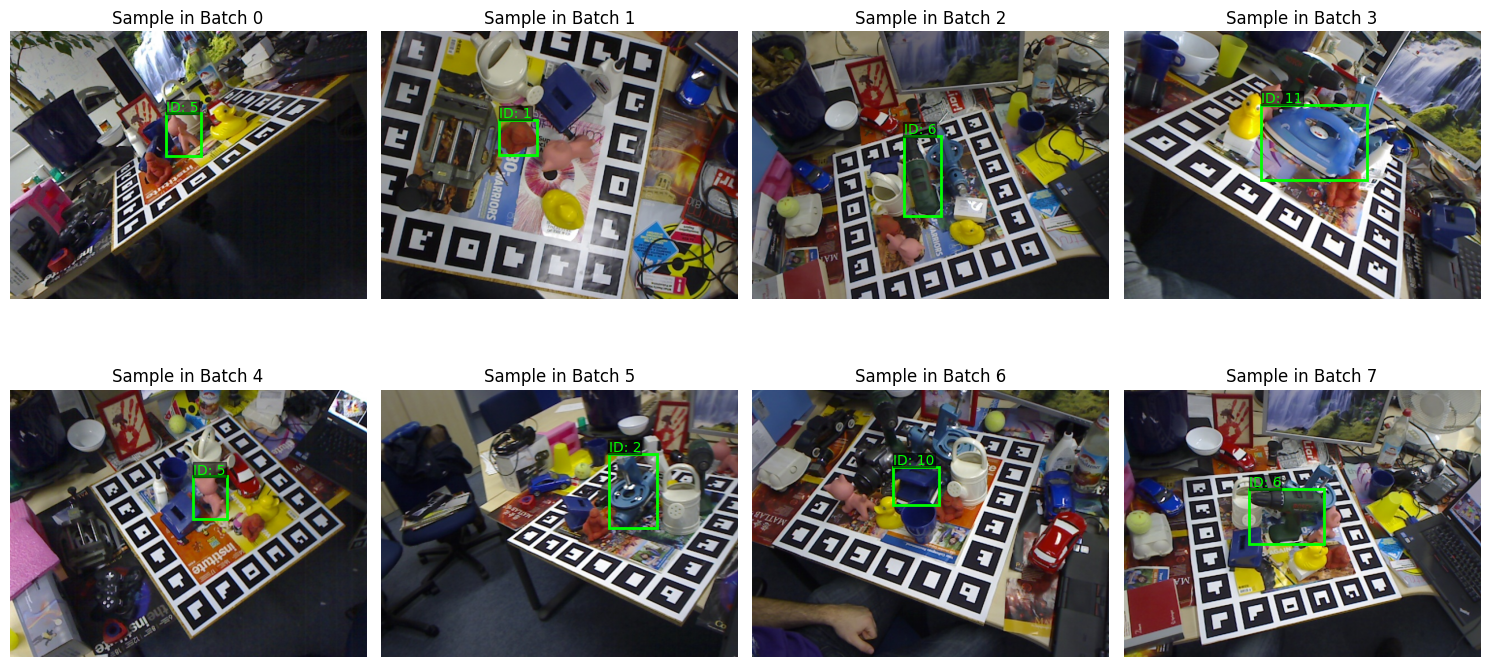

In [ ]:
# --- Section 5: Visualize a Batch of Data ---

try:
    # Get one batch from the train loader
    data_iter = iter(train_loader)
    batch = next(data_iter)

    # Check if the batch is None (meaning all samples in it had errors)
    if batch is None:
        print("Could not retrieve a valid batch. Check dataset integrity or error handling.")
    else:
        # Extract relevant data from the batch
        # Note: The structure depends on default_collate grouping items
        images = batch["rgb"]         # Shape: [B, C, H, W]
        targets = batch["target"]     # This is now a list of dictionaries, one per image
        # We need to access boxes and labels from the list of targets
        # Example for visualization: We'll take the first object from each target dict

        print(f"Batch loaded successfully. Visualizing {len(images)} images.")

        # Plot settings
        batch_size_to_show = images.shape[0]
        cols = min(4, batch_size_to_show)
        rows = (batch_size_to_show + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        # Ensure axes is always an array, even if rows*cols is 1
        if rows * cols == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        for i in range(batch_size_to_show):
            ax = axes[i]

            # Convert image tensor back to numpy array for plotting
            # Need to permute channels: [C, H, W] -> [H, W, C]
            img_np = images[i].permute(1, 2, 0).cpu().numpy()

            # Denormalize if normalization was applied in transform (optional)
            # mean = np.array([0.485, 0.456, 0.406])
            # std = np.array([0.229, 0.224, 0.225])
            # img_np = std * img_np + mean
            # img_np = np.clip(img_np, 0, 1) # Clip values to be between 0 and 1

            ax.imshow(img_np)
            ax.axis('off')
            ax.set_title(f"Sample in Batch {i}")

            # Extract bbox and label for the first object in the i-th target
            # targets['boxes'] and targets['labels'] are now lists of tensors
            if 'boxes' in targets and i < len(targets['boxes']) and targets['boxes'][i].nelement() > 0:
                bbox = targets['boxes'][i][0].cpu().numpy() # Get the first box [xmin, ymin, xmax, ymax]
                label = targets['labels'][i][0].cpu().numpy() # Get the first label
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min

                # Draw bounding box
                rect = patches.Rectangle(
                    (x_min, y_min),   # (x_min, y_min)
                    width,            # width
                    height,           # height
                    linewidth=2,
                    edgecolor='lime', # Changed color for visibility
                    facecolor='none'
                )
                ax.add_patch(rect)

                # Add object ID as label near the box
                ax.text(
                    x_min,
                    y_min - 5, # Adjusted position
                    f'ID: {label}',
                    color='lime',
                    fontsize=10,
                    bbox=dict(facecolor='black', alpha=0.5, pad=0.1) # Added background
                )
            else:
                 print(f"No boxes found for sample {i}")


        # Hide unused axes if batch_size < cols * rows
        for j in range(batch_size_to_show, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

except StopIteration:
    print("Train loader is empty or could not provide a batch.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

# **Phase 2 - Faster R-CNN**
It takes too long so we use YOLO after 3 sections


In [ ]:
# --- Section 6: Object Detection Model Definition (Faster R-CNN) ---

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_model(num_classes):
    """
    Loads a pre-trained Faster R-CNN model and modifies the classifier head
    for the specified number of classes.

    Args:
        num_classes (int): Number of classes including the background.

    Returns:
        model (torchvision.models.detection.FasterRCNN): The modified Faster R-CNN model.
    """
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    # num_classes includes the background (e.g., 13 objects + 1 background = 14)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # --- Optional: Modify Anchor Generator ---
    # If default anchors are not suitable for your objects' sizes/aspect ratios,
    # you can define custom anchors. For LineMOD, defaults might be okay initially.
    # Example:
    # anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
    #                                    aspect_ratios=((0.5, 1.0, 2.0),))
    # model.rpn.anchor_generator = anchor_generator
    # ---

    return model

# Instantiate the model
# NUM_CLASSES was defined in Section 1 (Number of objects + 1 background)
detection_model = get_detection_model(NUM_CLASSES)

# Move model to the appropriate device (GPU or CPU)
detection_model.to(device)

print(f"Faster R-CNN model loaded and moved to {device}.")
# Print model summary (optional, can be long)
# print(detection_model)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 103MB/s]


Faster R-CNN model loaded and moved to cuda.


In [ ]:
# --- Section 7: Training Setup (Optimizer, Scheduler, Loss) ---

# Parameters to optimize
# Ensure all model parameters require gradients
params = [p for p in detection_model.parameters() if p.requires_grad]

# Optimizer
# SGD is often recommended for Faster R-CNN finetuning
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Adam can also work, might need lower learning rate initially
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)


# Learning rate scheduler (optional but recommended)
# Reduces the learning rate over epochs
# StepLR reduces LR by a factor (gamma) every step_size epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Number of training epochs
num_epochs = 10 # Start with a moderate number, can be increased later

print("Training setup configured:")
print(f" Optimizer: {type(optimizer).__name__}")
print(f" Initial LR: {optimizer.param_groups[0]['lr']}")
print(f" Scheduler: {type(lr_scheduler).__name__} (step_size={lr_scheduler.step_size}, gamma={lr_scheduler.gamma})")
print(f" Number of epochs: {num_epochs}")

# Note: The loss function for Faster R-CNN is built into the model.
# During training, the model(images, targets) call returns a dictionary of losses
# (e.g., loss_classifier, loss_box_reg, loss_objectness, loss_rpn_box_reg).
# We just need to sum them up.

Training setup configured:
 Optimizer: Adam
 Initial LR: 0.001
 Scheduler: StepLR (step_size=5, gamma=0.1)
 Number of epochs: 10


In [ ]:
# --- Section 8: Training Loop ---

from tqdm import tqdm # For progress bar
import torch # Ensure torch is imported if not already

# Lists to store loss values for plotting later
train_loss_hist = []
train_loss_classifier_hist = []
train_loss_box_reg_hist = []
train_loss_objectness_hist = []
train_loss_rpn_box_reg_hist = []

print("Starting training...")

for epoch in range(num_epochs):
    # Set model to training mode
    detection_model.train()

    # Initialize cumulative losses for the epoch
    epoch_loss = 0.0
    epoch_loss_classifier = 0.0
    epoch_loss_box_reg = 0.0
    epoch_loss_objectness = 0.0
    epoch_loss_rpn_box_reg = 0.0

    # Use tqdm for a progress bar over the training loader
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    batch_count = 0
    for batch in pbar:
        # Check if the batch is valid (due to collate_fn_filter_errors)
        if batch is None:
            print("Skipping an invalid batch.")
            continue

        # --- MODIFIED DATA TRANSFER ---
        # Move images to the device (as a list)
        images = [img.to(device) for img in batch['rgb']]

        # Reconstruct the list of target dictionaries and move tensors to device
        targets_list = []
        num_in_batch = len(images) # Number of images/targets in this batch
        target_keys = batch['target'].keys()
        for i in range(num_in_batch):
            target_dict = {}
            for key in target_keys:
                # Move the i-th element of each target value tensor/list to the device
                try:
                    # Ensure the element is a tensor before moving
                    if isinstance(batch['target'][key][i], torch.Tensor):
                        target_dict[key] = batch['target'][key][i].to(device)
                    else:
                        # Handle cases where element might not be a tensor directly
                        # Example: converting numpy array or scalar
                        target_dict[key] = torch.as_tensor(batch['target'][key][i]).to(device)
                except IndexError:
                     print(f"IndexError accessing target key '{key}' for item {i} in batch. Batch size mismatch?")
                     # Handle appropriately, maybe skip this target or the whole batch
                     target_dict = None # Mark target as invalid
                     break
                except Exception as e:
                     print(f"Error moving target key '{key}' for item {i} to device: {e}")
                     target_dict = None # Mark target as invalid
                     break
            if target_dict is not None: # Only append if target was successfully processed
                 targets_list.append(target_dict)

        # Skip batch if any target reconstruction failed or if targets_list is empty
        if len(targets_list) != len(images) or not targets_list:
             print("Skipping batch due to target processing errors or empty targets list.")
             continue

        targets = targets_list
        # --- END MODIFIED DATA TRANSFER ---

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass - Model returns a loss dictionary in training mode
        try:
            loss_dict = detection_model(images, targets)
        except Exception as e:
            print(f"\nError during model forward pass in epoch {epoch+1}, batch {batch_count}: {e}")
            # Optionally print target details for debugging
            # for i, t in enumerate(targets):
            #    print(f"Target {i}:")
            #    for k, v in t.items():
            #        print(f"  {k}: shape={v.shape if isinstance(v, torch.Tensor) else type(v)}, dtype={v.dtype if isinstance(v, torch.Tensor) else ''}")
            print("Skipping batch.")
            continue # Skip to the next batch

        # Calculate the total loss by summing all individual losses
        losses = sum(loss for loss in loss_dict.values())

        # Check for NaN or infinite loss
        if not torch.isfinite(losses):
            print(f"Warning: Detected non-finite loss: {losses.item()}. Skipping batch.")
            print("Loss dict:", loss_dict)
            optimizer.zero_grad() # Clear gradients before skipping
            continue

        # Backward pass
        try:
            losses.backward()
        except RuntimeError as e:
             print(f"\nError during backward pass in epoch {epoch+1}, batch {batch_count}: {e}")
             print("Loss dict:", loss_dict)
             optimizer.zero_grad() # Clear gradients if backward fails
             continue # Skip to the next batch


        # Optimize
        optimizer.step()

        # Accumulate losses for tracking
        batch_loss = losses.item()
        epoch_loss += batch_loss
        # Use .get with default tensor(0.0) for safer accumulation
        epoch_loss_classifier += loss_dict.get('loss_classifier', torch.tensor(0.0, device=device)).item()
        epoch_loss_box_reg += loss_dict.get('loss_box_reg', torch.tensor(0.0, device=device)).item()
        epoch_loss_objectness += loss_dict.get('loss_objectness', torch.tensor(0.0, device=device)).item()
        epoch_loss_rpn_box_reg += loss_dict.get('loss_rpn_box_reg', torch.tensor(0.0, device=device)).item()

        # Update progress bar description with current batch loss
        pbar.set_postfix(batch_loss=f"{batch_loss:.4f}")
        batch_count += 1

        # --- Optional: Break early for debugging ---
        # if batch_count > 5:
        #    print("Breaking early for debugging...")
        #    break
        # ---

    # Calculate average losses for the epoch
    # Use batch_count in case some batches were skipped
    num_valid_batches = batch_count
    avg_epoch_loss = epoch_loss / num_valid_batches if num_valid_batches > 0 else 0
    avg_loss_classifier = epoch_loss_classifier / num_valid_batches if num_valid_batches > 0 else 0
    avg_loss_box_reg = epoch_loss_box_reg / num_valid_batches if num_valid_batches > 0 else 0
    avg_loss_objectness = epoch_loss_objectness / num_valid_batches if num_valid_batches > 0 else 0
    avg_loss_rpn_box_reg = epoch_loss_rpn_box_reg / num_valid_batches if num_valid_batches > 0 else 0

    # Store average losses for history
    train_loss_hist.append(avg_epoch_loss)
    train_loss_classifier_hist.append(avg_loss_classifier)
    train_loss_box_reg_hist.append(avg_loss_box_reg)
    train_loss_objectness_hist.append(avg_loss_objectness)
    train_loss_rpn_box_reg_hist.append(avg_loss_rpn_box_reg)

    # Step the learning rate scheduler
    lr_scheduler.step()

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Processed {num_valid_batches}/{len(train_loader)} batches.")
    print(f"  Average Total Loss: {avg_epoch_loss:.4f}")
    print(f"  Avg Loss Classifier: {avg_loss_classifier:.4f}")
    print(f"  Avg Loss Box Reg: {avg_loss_box_reg:.4f}")
    print(f"  Avg Loss Objectness: {avg_loss_objectness:.4f}")
    print(f"  Avg Loss RPN Box Reg: {avg_loss_rpn_box_reg:.4f}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 30)

print("Training finished.")

Starting training...


Epoch 1/10:  28%|██▊       | 164/594 [31:33<1:22:43, 11.54s/it, batch_loss=0.3229]


KeyboardInterrupt: 



---



---





---



---



# **Phase 2 - YOLO**

In [ ]:
# --- Section 6: Setup YOLOv5 ---

# 1. Install ultralytics library
!pip install ultralytics -q # -q for quiet installation

# 2. Import YOLO class
from ultralytics import YOLO
import shutil # For copying/moving files if needed

print("Ultralytics YOLO library installed and imported.")

# 3. Define path for YOLO dataset configuration file
# We will create this file in the next step
yolo_data_yaml_path = '/content/linemod_yolo.yaml'

# 4. Define path for YOLO results (training runs, weights, etc.)
yolo_results_dir = '/content/drive/MyDrive/LineMOD_YOLO_Runs' # Save runs to Drive
os.makedirs(yolo_results_dir, exist_ok=True)
print(f"YOLO training results will be saved in: {yolo_results_dir}")

# 5. Define model variant (e.g., yolov5s, yolov5m, yolov5l, yolov5x)
# 's' is small and fast, good for starting
yolo_model_variant = 'yolov5s.pt' # '.pt' indicates we want to load pretrained weights
print(f"Using YOLO model variant: {yolo_model_variant}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultra

In [ ]:
# --- Section 7: Prepare Data for YOLOv5 Training ---
# Convert our LineModDataset format to YOLO format (txt files per image)

import shutil
import os # Ensure os is imported
from tqdm import tqdm # Ensure tqdm is imported
from PIL import Image # Ensure Image is imported
import numpy as np # Ensure numpy is imported
import torch # Ensure torch is imported (might be needed for default_collate in dataset if used differently)

# --- Define base directory for YOLO format ---
# We will create this directory in the Colab environment's temporary storage
yolo_base_dir = '/content/linemod_yolo_format'
# ---

# Define subdirectories based on the new base directory
yolo_images_dir = os.path.join(yolo_base_dir, 'images')
yolo_labels_dir = os.path.join(yolo_base_dir, 'labels')
yolo_train_img_dir = os.path.join(yolo_images_dir, 'train')
yolo_train_lbl_dir = os.path.join(yolo_labels_dir, 'train')
yolo_val_img_dir = os.path.join(yolo_images_dir, 'val') # Use test set as validation
yolo_val_lbl_dir = os.path.join(yolo_labels_dir, 'val')

# Create directories
os.makedirs(yolo_train_img_dir, exist_ok=True)
os.makedirs(yolo_train_lbl_dir, exist_ok=True)
os.makedirs(yolo_val_img_dir, exist_ok=True)
os.makedirs(yolo_val_lbl_dir, exist_ok=True)

print("YOLO format directories created at:", yolo_base_dir)

def convert_to_yolo_format(dataset, img_dir, lbl_dir):
    """
    Iterates through the dataset, copies images, and creates YOLO label files.
    Assumes 'dataset' is an instance of LineModDataset defined in Section 3.
    """
    print(f"Converting data for {dataset.split} split...")
    processed_count = 0
    error_count = 0
    # Get number of samples directly from the dataset instance
    num_samples = len(dataset)
    if num_samples == 0:
        print(f"Warning: Dataset for split '{dataset.split}' is empty.")
        return

    for i in tqdm(range(num_samples), desc=f"Processing {dataset.split}"):
        folder_id_str, sample_id_str, class_idx = None, None, None # Initialize
        try:
            # Get sample data using our existing dataset class
            sample = dataset[i] # Call __getitem__

            # Check if __getitem__ returned an error dictionary
            if isinstance(sample, dict) and sample.get("error"):
                # print(f"Skipping sample {i} due to loading error: {sample.get('reason')}")
                error_count += 1
                continue

            # Extract necessary info (ensure keys exist based on __getitem__ output)
            folder_id_str = sample.get("folder_id_str")
            sample_id_str = sample.get("sample_id_str")
            target = sample.get("target")

            if not all([folder_id_str, sample_id_str, target]):
                 print(f"Warning: Missing essential keys in sample dict for index {i}.")
                 error_count += 1
                 continue


            # --- Original image path ---
            original_img_path = os.path.join(dataset.DATASET_ROOT, 'data', folder_id_str, 'rgb', f"{sample_id_str}.png")

            # --- Get image dimensions (needed for normalization) ---
            if not os.path.exists(original_img_path):
                 print(f"Warning: Original image not found for sample {i}: {original_img_path}")
                 error_count += 1
                 continue
            try:
                # Use the already loaded image tensor if available (though we didn't load it here)
                # Safest is to reload to get dimensions
                with Image.open(original_img_path) as img:
                    img_w, img_h = img.size
            except Exception as e:
                print(f"Warning: Could not open image to get dimensions for sample {i} ({original_img_path}): {e}")
                error_count += 1
                continue
            #---

            # Define new unique name for image and label file (e.g., objID_sampleID)
            base_filename = f"{folder_id_str}_{sample_id_str}"
            new_img_path = os.path.join(img_dir, f"{base_filename}.png")
            label_path = os.path.join(lbl_dir, f"{base_filename}.txt")

            # --- Copy image file ---
            try:
                 shutil.copyfile(original_img_path, new_img_path)
            except Exception as e:
                 print(f"Warning: Could not copy image for sample {i}: {e}")
                 error_count += 1
                 continue # Don't create label if image copy failed

            # --- Get target info (bbox and mapped class index) ---
            if 'boxes' in target and target['boxes'].nelement() > 0 and 'labels' in target and target['labels'].nelement() > 0 :
                # Target['boxes'] has shape [1, 4] -> access first element
                bbox_voc = target['boxes'][0].cpu().numpy()
                # Target['labels'] has shape [1] -> access first element
                class_idx = target['labels'][0].item() # This is the mapped index (1-13)

                # --- Convert VOC bbox to YOLO format ---
                x_min, y_min, x_max, y_max = bbox_voc
                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                box_w = x_max - x_min
                box_h = y_max - y_min

                # Check for invalid dimensions again just before division
                if img_w <= 0 or img_h <= 0 or box_w <= 0 or box_h <= 0:
                    print(f"Warning: Invalid dimensions (img:{img_w}x{img_h}, box:{box_w}x{box_h}) for sample {i}. Skipping label.")
                    error_count += 1
                    if os.path.exists(new_img_path): os.remove(new_img_path) # Clean up copied image
                    continue


                # Normalize coordinates
                x_center_norm = x_center / img_w
                y_center_norm = y_center / img_h
                width_norm = box_w / img_w
                height_norm = box_h / img_h

                # Clamp values
                x_center_norm = np.clip(x_center_norm, 0.0, 1.0)
                y_center_norm = np.clip(y_center_norm, 0.0, 1.0)
                width_norm = np.clip(width_norm, 0.0, 1.0)
                height_norm = np.clip(height_norm, 0.0, 1.0)

                # --- Adjust class index for YOLO (0-based) ---
                yolo_class_idx = class_idx - 1
                if not (0 <= yolo_class_idx < NUM_OBJECTS): # Check if index is valid (0 to 12)
                     print(f"Warning: Invalid YOLO class index {yolo_class_idx} (original mapped {class_idx}) for sample {i}")
                     error_count += 1
                     if os.path.exists(new_img_path): os.remove(new_img_path)
                     continue
                # ---

                # Write to label file
                try:
                    with open(label_path, 'w') as f_label:
                        f_label.write(f"{yolo_class_idx} {x_center_norm:.6f} {y_center_norm:.6f} {width_norm:.6f} {height_norm:.6f}\n")
                    processed_count += 1
                except Exception as e:
                     print(f"Warning: Could not write label file for sample {i}: {e}")
                     error_count += 1
                     if os.path.exists(new_img_path): os.remove(new_img_path) # Clean up if label write failed
                     continue

            else:
                # If no boxes/labels were found in the target dict (should have been caught by __getitem__)
                print(f"Info: No boxes/labels found in target dict for sample {i}, creating empty label file.")
                # Create an empty label file to match the image
                open(label_path, 'w').close()
                processed_count += 1 # Still count as processed if image was copied

        except Exception as e:
            print(f"\nCritical Error processing sample index {idx}: {e}")
            traceback.print_exc()
            error_count += 1
            # Attempt cleanup even if folder/sample IDs were not assigned
            if folder_id_str and sample_id_str:
                 base_filename = f"{folder_id_str}_{sample_id_str}"
                 new_img_path = os.path.join(img_dir, f"{base_filename}.png")
                 label_path = os.path.join(lbl_dir, f"{base_filename}.txt")
                 if os.path.exists(new_img_path): os.remove(new_img_path)
                 if os.path.exists(label_path): os.remove(label_path)


    print(f"Conversion complete for {dataset.split}. Processed: {processed_count}, Errors/Skipped: {error_count}")

# --- Create dataset instances (using the corrected LineModDataset class from Section 3) ---
# We pass transform=None because we are just using the dataset to access paths and GT, not image tensors here.
try:
    train_dataset_formapping = LineModDataset(DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='train', transform=None)
    test_dataset_formapping = LineModDataset(DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='test', transform=None) # Use test set for validation

    # --- Run the conversion ---
    convert_to_yolo_format(train_dataset_formapping, yolo_train_img_dir, yolo_train_lbl_dir)
    convert_to_yolo_format(test_dataset_formapping, yolo_val_img_dir, yolo_val_lbl_dir) # Convert test data to validation folder

    print("\nData conversion to YOLO format finished.")
    print(f"Check '{yolo_images_dir}' and '{yolo_labels_dir}' for results.")

except FileNotFoundError as e:
     print(f"\nError creating dataset for mapping: {e}")
     print("Please ensure DATASET_ROOT in Section 1 is correct and contains the 'data' and 'models' subdirectories.")
except ValueError as e:
     print(f"\nError creating dataset for mapping: {e}")
     print("Please check if train.txt/test.txt files exist and are not empty in the object directories.")
except Exception as e:
     print(f"\nAn unexpected error occurred during dataset creation or conversion: {e}")
     traceback.print_exc()

YOLO format directories created at: /content/linemod_yolo_format
Object ID to Class Index Mapping: {1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13}
Loading 'train' samples...
Total samples loaded for 'train' split: 2373
Initialized LineModDataset for split 'train' with 2373 samples for objects [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15].
Object ID to Class Index Mapping: {1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13}
Loading 'test' samples...
Total samples loaded for 'test' split: 13407
Initialized LineModDataset for split 'test' with 13407 samples for objects [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15].
Converting data for train split...


Processing train:   0%|          | 0/2373 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# --- Section 7.5: Load Pre-formatted YOLO Data from Drive ---
import os
import time

# 1. Ensure Google Drive is mounted (should be from Section 1)
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True) # force_remount if needed

# 2. Define the path to your uploaded ZIP file on Google Drive
# IMPORTANT: Adjust this path to where you uploaded your zip file in Google Drive
YOLO_FORMATTED_DATA_ZIP_PATH_DRIVE = '/content/drive/MyDrive/6D-pose-Dataset/linemod_yolo_output_format.zip'

# 3. Define the target directory in Colab's local storage for extraction
YOLO_DATA_DIR_COLAB = '/content/linemod_yolo_data_for_training' # Base directory for extracted data

# 4. Check if data is already extracted, otherwise extract
yolo_images_check_dir = os.path.join(YOLO_DATA_DIR_COLAB, 'images') # Check for a subfolder

if not os.path.exists(yolo_images_check_dir):
    if os.path.exists(YOLO_FORMATTED_DATA_ZIP_PATH_DRIVE):
        print(f"Extracting YOLO formatted data from {YOLO_FORMATTED_DATA_ZIP_PATH_DRIVE} to {YOLO_DATA_DIR_COLAB}...")
        os.makedirs(YOLO_DATA_DIR_COLAB, exist_ok=True)
        start_time = time.time()

        # Use unzip command. The -q flag makes it quiet.
        # The -d flag specifies the destination directory.
        !unzip -q "{YOLO_FORMATTED_DATA_ZIP_PATH_DRIVE}" -d "{YOLO_DATA_DIR_COLAB}"

        end_time = time.time()
        if os.path.exists(yolo_images_check_dir): # Verify again after unzip
             print(f"YOLO formatted data extracted to {YOLO_DATA_DIR_COLAB} in {end_time - start_time:.2f} seconds.")
             # List some contents to verify
             print("\nSample content of extracted 'images/train':")
             !ls "{YOLO_DATA_DIR_COLAB}/images/train" | head -n 5
             print("\nSample content of extracted 'labels/train':")
             !ls "{YOLO_DATA_DIR_COLAB}/labels/train" | head -n 5
        else:
             print("ERROR: Extraction might have failed. Target directory or 'images' subfolder not found after unzip.")
             print(f"Please check the output of the unzip command if there were errors.")
             print(f"Contents of {YOLO_DATA_DIR_COLAB}:")
             !ls "{YOLO_DATA_DIR_COLAB}"

    else:
        print(f"ERROR: YOLO formatted data zip file not found at {YOLO_FORMATTED_DATA_ZIP_PATH_DRIVE}")
        print("Please ensure the file is uploaded to Google Drive and the path is correct.")
else:
    print(f"YOLO formatted data already found in {YOLO_DATA_DIR_COLAB}.")
    DATASET_ROOT_YOLO_TRAINING = YOLO_DATA_DIR_COLAB # Set this for YOLO config file
    print(f"DATASET_ROOT_YOLO_TRAINING set to: {DATASET_ROOT_YOLO_TRAINING}")


Extracting YOLO formatted data from /content/drive/MyDrive/6D-pose-Dataset/linemod_yolo_output_format.zip to /content/linemod_yolo_data_for_training...
replace /content/linemod_yolo_data_for_training/linemod_yolo_output_format/images/train/01_0004.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
ERROR: Extraction might have failed. Target directory or 'images' subfolder not found after unzip.
Please check the output of the unzip command if there were errors.
Contents of /content/linemod_yolo_data_for_training:
linemod_yolo_output_format


In [ ]:
# --- IMPORTANT: After successful extraction, set a variable for YOLO config ---
# --- MODIFICATION HERE TO POINT TO THE CORRECT SUBFOLDER ---
potential_data_root = os.path.join(YOLO_DATA_DIR_COLAB, 'linemod_yolo_output_format')
yolo_images_check_dir_corrected = os.path.join(potential_data_root, 'images')

if os.path.exists(yolo_images_check_dir_corrected): # Check the corrected path
    DATASET_ROOT_YOLO_TRAINING = potential_data_root # Use the path with the subfolder
    print(f"\nPath for YOLO YAML configuration (train/val image folders ROOT): {DATASET_ROOT_YOLO_TRAINING}")
    print("\nSample content of actual 'images/train':")
    !ls "{DATASET_ROOT_YOLO_TRAINING}/images/train" | head -n 5
    print("\nSample content of actual 'labels/train':")
    !ls "{DATASET_ROOT_YOLO_TRAINING}/labels/train" | head -n 5
elif os.path.exists(yolo_images_check_dir): # Check original expected path (in case structure was different)
    DATASET_ROOT_YOLO_TRAINING = YOLO_DATA_DIR_COLAB
    print(f"\nPath for YOLO YAML configuration (train/val image folders ROOT): {DATASET_ROOT_YOLO_TRAINING}")
    print("\nSample content of actual 'images/train':")
    !ls "{DATASET_ROOT_YOLO_TRAINING}/images/train" | head -n 5
    print("\nSample content of actual 'labels/train':")
    !ls "{DATASET_ROOT_YOLO_TRAINING}/labels/train" | head -n 5
else:
    print("\nExtraction structure is unexpected or failed. Cannot set DATASET_ROOT_YOLO_TRAINING.")
    print(f"Please check the contents of '{YOLO_DATA_DIR_COLAB}' and its subdirectories manually.")
    DATASET_ROOT_YOLO_TRAINING = None # Indicate that data is not ready


Path for YOLO YAML configuration (train/val image folders ROOT): /content/linemod_yolo_data_for_training/linemod_yolo_output_format

Sample content of actual 'images/train':
01_0004.png
01_0009.png
01_0021.png
01_0030.png
01_0044.png

Sample content of actual 'labels/train':
01_0004.txt
01_0009.txt
01_0021.txt
01_0030.txt
01_0044.txt


In [ ]:
# --- Section 8: Create YOLOv5 Dataset Configuration YAML File ---

# This YAML file tells YOLOv5 where to find the training and validation data,
# and also the number of classes and their names.

yolo_data_yaml_path = '/content/linemod_yolo.yaml' # Defined in Section 6, ensure it's available or redefine

# Check if DATASET_ROOT_YOLO_TRAINING was set correctly in the previous step
if DATASET_ROOT_YOLO_TRAINING is None or not os.path.exists(DATASET_ROOT_YOLO_TRAINING):
    print("ERROR: DATASET_ROOT_YOLO_TRAINING is not set or path does not exist.")
    print("Please re-run Section 7.5 successfully before this step.")
else:
    # Define the paths for train and val image directories (relative to DATASET_ROOT_YOLO_TRAINING or absolute)
    # The ultralytics library expects these paths to be where the images are.
    # The labels are assumed to be in a parallel 'labels' directory.
    train_images_path = os.path.join(DATASET_ROOT_YOLO_TRAINING, 'images/train')
    val_images_path = os.path.join(DATASET_ROOT_YOLO_TRAINING, 'images/val') # Using our test split as validation

    # Verify these paths exist
    if not os.path.exists(train_images_path):
        print(f"ERROR: Training images path not found: {train_images_path}")
    if not os.path.exists(val_images_path):
        print(f"ERROR: Validation images path not found: {val_images_path}")

    # Create a list of class names.
    # IMPORTANT: These must be in the order corresponding to yolo_class_idx (0 to NUM_OBJECTS-1)
    # We used obj_id_to_class_idx which mapped original IDs to 1-13.
    # For YOLO, we subtract 1, so class_idx 0 corresponds to original ID 1 (if sorted), etc.
    # We need a list of names where index 0 is name for class_idx 0, index 1 for class_idx 1, ...
    # We have AVAILABLE_OBJECT_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
    # And NUM_OBJECTS = 13

    # Create a simple list of names, e.g., ["obj1", "obj2", "obj4", ...]
    # The order must match the yolo_class_idx (0 to 12)
    # If self.obj_id_to_class_idx was {1:1, 2:2, 4:3 ...}, then
    # yolo_class_idx 0 -> original obj_id 1
    # yolo_class_idx 1 -> original obj_id 2
    # yolo_class_idx 2 -> original obj_id 4
    # ...
    # yolo_class_idx 12 -> original obj_id 15

    # We can generate names based on the sorted AVAILABLE_OBJECT_IDS
    # The class with YOLO index `i` corresponds to `AVAILABLE_OBJECT_IDS[i]`
    class_names = [f"obj_{obj_id:02d}" for obj_id in sorted(AVAILABLE_OBJECT_IDS)]
    # Example: class_names[0] will be 'obj_01', class_names[1] will be 'obj_02', class_names[2] will be 'obj_04'

    # Content of the YAML file
    # Note: YOLOv5 expects paths to be either absolute or relative to the yolov5 directory if running from there.
    # Using absolute paths from /content/ is safer in Colab.
    data_yaml_content = f"""
train: {train_images_path}
val: {val_images_path}

# Number of classes
nc: {NUM_OBJECTS} # We have 13 objects (0-12)

# Class names
names: {class_names}
"""

    # Path to save the YAML file (defined in Section 6)
    # yolo_data_yaml_path = '/content/linemod_yolo.yaml'

    try:
        with open(yolo_data_yaml_path, 'w') as f:
            f.write(data_yaml_content)
        print(f"\nCreated YOLO dataset YAML configuration file at: {yolo_data_yaml_path}")
        print("\nYAML file content:")
        print("--------------------")
        print(data_yaml_content)
        print("--------------------")
    except Exception as e:
        print(f"Error writing YAML file: {e}")


Created YOLO dataset YAML configuration file at: /content/linemod_yolo.yaml

YAML file content:
--------------------

train: /content/linemod_yolo_data_for_training/linemod_yolo_output_format/images/train
val: /content/linemod_yolo_data_for_training/linemod_yolo_output_format/images/val

# Number of classes
nc: 13 # We have 13 objects (0-12)

# Class names
names: ['obj_01', 'obj_02', 'obj_04', 'obj_05', 'obj_06', 'obj_08', 'obj_09', 'obj_10', 'obj_11', 'obj_12', 'obj_13', 'obj_14', 'obj_15']

--------------------


In [ ]:
# --- Section 9: Train YOLOv5 Model ---

# Ensure DATASET_ROOT_YOLO_TRAINING and yolo_data_yaml_path are correctly set from previous cells
if DATASET_ROOT_YOLO_TRAINING is None or not os.path.exists(yolo_data_yaml_path):
    print("ERROR: YOLO data YAML file or dataset root is not properly configured.")
    print("Please ensure Section 7.5 and Section 8 ran successfully.")
else:
    # Load a pre-trained YOLOv5 model
    # yolo_model_variant was defined in Section 6 (e.g., 'yolov5s.pt')
    try:
        model_yolo = YOLO(yolo_model_variant) # Loads pretrained weights
        model_yolo.to(device) # Ensure model is on the correct device

        print(f"YOLOv5 model ({yolo_model_variant}) loaded on {device}.")

        # Training arguments
        yolo_epochs = 25 # Start with a reasonable number, can be much higher for good results
        yolo_batch_size = 16 # Adjust based on GPU memory (e.g., 8, 16, 32 for T4/V100)
                         # If you get OOM error, reduce this.
        img_size = 640 # Standard input size for YOLOv5, can be adjusted

        print(f"Starting YOLOv5 training for {yolo_epochs} epochs...")
        print(f" Batch size: {yolo_batch_size}, Image size: {img_size}")
        print(f" Data YAML: {yolo_data_yaml_path}")
        print(f" Results will be saved in: {yolo_results_dir}")


        # Start training
        # project: Directory to save runs
        # name: Specific name for this run
        # imgsz: image size
        # batch: batch size
        # epochs: number of epochs
        # data: path to the dataset yaml file
        # weights: initial weights (e.g., 'yolov5s.pt' for pretrained)
        # device: 'cpu' or '0' for GPU 0, or '0,1,2,3' for multiple GPUs

        results = model_yolo.train(
            data=yolo_data_yaml_path,
            epochs=yolo_epochs,
            imgsz=img_size,
            batch=yolo_batch_size,
            project=yolo_results_dir,
            name='linemod_experiment_1', # You can change this name for different runs
            exist_ok=True, # Overwrite if a run with the same name exists
            # device=0 if torch.cuda.is_available() else 'cpu' # Let ultralytics handle device if model is already on it
            patience=5 # Early stopping patience: epochs to wait for no improvement
        )

        print("\nYOLOv5 training finished.")
        print("Best model weights saved in:", results.save_dir) # 'results' object contains paths
        print("Metrics and plots can be found in the same directory.")

    except Exception as e:
        print(f"\nAn error occurred during YOLOv5 model loading or training: {e}")
        traceback.print_exc()

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

YOLOv5 model (yolov5s.pt) loaded on cuda.
Starting YOLOv5 training for 25 epochs...
 Batch size: 16, Image size: 640
 Data YAML: /content/linemod_yolo.yaml
 Results will be saved in: /content/drive/MyDrive/LineMOD_YOLO_Runs
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/linemod_yolo.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h

train: Scanning /content/linemod_yolo_data_for_training/linemod_yolo_output_format/labels/train... 2373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2373/2373 [00:02<00:00, 994.44it/s] 

train: New cache created: /content/linemod_yolo_data_for_training/linemod_yolo_output_format/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1557.4±959.7 MB/s, size: 451.7 KB)


val: Scanning /content/linemod_yolo_data_for_training/linemod_yolo_output_format/labels/val... 13406 images, 0 backgrounds, 1 corrupt: 100%|██████████| 13407/13407 [00:12<00:00, 1106.71it/s]

val: /content/linemod_yolo_data_for_training/linemod_yolo_output_format/images/val/05_1156.png: ignoring corrupt image/label: Truncated File Read


val: New cache created: /content/linemod_yolo_data_for_training/linemod_yolo_output_format/labels/val.cache
Plotting labels to /content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.96G      1.031      3.229      1.171          7        640: 100%|██████████| 149/149 [00:17<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:56<00:00,  7.44it/s]


                   all      13406      13406      0.882      0.878      0.955      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.55G     0.8825      1.098      1.068          9        640: 100%|██████████| 149/149 [00:15<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:54<00:00,  7.73it/s]


                   all      13406      13406      0.915      0.877      0.964      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.55G     0.8409     0.8175      1.054          8        640: 100%|██████████| 149/149 [00:15<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:54<00:00,  7.74it/s]


                   all      13406      13406      0.953      0.956      0.991      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.56G     0.8179     0.7198      1.048          7        640: 100%|██████████| 149/149 [00:15<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.86it/s]


                   all      13406      13406      0.978      0.975      0.993      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.59G     0.7984     0.6523      1.026         10        640: 100%|██████████| 149/149 [00:15<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.77it/s]


                   all      13406      13406       0.96      0.974      0.991      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       4.6G      0.747     0.5877      1.011          7        640: 100%|██████████| 149/149 [00:15<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.82it/s]


                   all      13406      13406      0.981      0.988      0.994       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.65G     0.7252     0.5313      1.001         10        640: 100%|██████████| 149/149 [00:15<00:00,  9.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.83it/s]


                   all      13406      13406      0.991      0.989      0.995      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.68G     0.7076      0.518     0.9853         10        640: 100%|██████████| 149/149 [00:15<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.85it/s]


                   all      13406      13406      0.982      0.987      0.995      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.71G      0.678     0.4919     0.9768          9        640: 100%|██████████| 149/149 [00:15<00:00,  9.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.82it/s]


                   all      13406      13406      0.994      0.997      0.995      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.73G     0.6643     0.4696     0.9744         14        640: 100%|██████████| 149/149 [00:15<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.81it/s]


                   all      13406      13406      0.994      0.996      0.995      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.78G     0.6402     0.4395     0.9556         10        640: 100%|██████████| 149/149 [00:15<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.81it/s]


                   all      13406      13406      0.993      0.995      0.995       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.81G     0.6275     0.4344     0.9544         11        640: 100%|██████████| 149/149 [00:15<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.87it/s]

                   all      13406      13406      0.996      0.999      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.84G     0.6089     0.4138      0.948          7        640: 100%|██████████| 149/149 [00:15<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.82it/s]

                   all      13406      13406      0.997      0.999      0.995      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.86G     0.5856     0.4012     0.9403          8        640: 100%|██████████| 149/149 [00:15<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.88it/s]

                   all      13406      13406      0.998      0.999      0.995      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25       4.9G     0.5857     0.3917      0.943          8        640: 100%|██████████| 149/149 [00:15<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.88it/s]

                   all      13406      13406      0.999      0.999      0.995       0.91


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.93G     0.5034     0.3275     0.9099          5        640: 100%|██████████| 149/149 [00:16<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.86it/s]


                   all      13406      13406      0.998      0.999      0.995       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.96G     0.4822     0.3088     0.8966          5        640: 100%|██████████| 149/149 [00:15<00:00,  9.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:52<00:00,  7.91it/s]

                   all      13406      13406      0.999      0.999      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.98G     0.4684     0.2941     0.8909          5        640: 100%|██████████| 149/149 [00:14<00:00,  9.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.89it/s]

                   all      13406      13406      0.999      0.999      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.03G     0.4451      0.278     0.8785          5        640: 100%|██████████| 149/149 [00:15<00:00,  9.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.85it/s]


                   all      13406      13406          1          1      0.995      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.06G     0.4365     0.2696     0.8729          5        640: 100%|██████████| 149/149 [00:14<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.90it/s]

                   all      13406      13406      0.999      0.999      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      5.09G     0.4199     0.2609     0.8623          5        640: 100%|██████████| 149/149 [00:15<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.84it/s]

                   all      13406      13406          1          1      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.11G     0.4073     0.2529     0.8608          5        640: 100%|██████████| 149/149 [00:14<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.86it/s]

                   all      13406      13406          1          1      0.995      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.15G     0.3915     0.2446     0.8477          5        640: 100%|██████████| 149/149 [00:15<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.82it/s]

                   all      13406      13406          1          1      0.995       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.18G     0.3784     0.2366       0.85          5        640: 100%|██████████| 149/149 [00:14<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.89it/s]

                   all      13406      13406          1          1      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.21G     0.3707     0.2306     0.8458          5        640: 100%|██████████| 149/149 [00:15<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:53<00:00,  7.88it/s]


                   all      13406      13406          1          1      0.995      0.947

25 epochs completed in 0.484 hours.
Optimizer stripped from /content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1/weights/last.pt, 18.5MB
Optimizer stripped from /content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1/weights/best.pt, 18.5MB

Validating /content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv5s summary (fused): 84 layers, 9,116,567 parameters, 0 gradients, 23.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 419/419 [00:58<00:00,  7.21it/s]


                   all      13406      13406          1          1      0.995      0.946
                obj_01       1050       1050      0.999          1      0.995      0.929
                obj_02       1031       1031          1          1      0.995      0.951
                obj_04       1020       1020          1          1      0.995      0.946
                obj_05       1015       1015      0.999          1      0.995      0.974
                obj_06       1002       1002          1          1      0.995       0.95
                obj_08       1009       1009          1          1      0.995      0.958
                obj_09       1065       1065      0.999      0.999      0.995      0.928
                obj_10       1065       1065          1      0.998      0.995       0.96
                obj_11       1036       1036          1          1      0.995      0.917
                obj_12       1051       1051          1          1      0.995      0.938
                obj_1

---



------



---

**To use Trained Model before instead of train model again**

---



---



In [ ]:
# --- Section 9.A: Load Trained Object Detection Model ---
from ultralytics import YOLO
import os
import torch # Make sure torch and device are available

# Ensure device is defined (should be from Section 1)
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device re-initialized to: {device}")

# IMPORTANT: This path should point to your 'best.pt' file in Google Drive
# It was printed at the end of your YOLO training (Section 9 output)
PATH_TO_TRAINED_YOLO_MODEL = '/content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1/weights/best.pt'
# You might need to adjust 'linemod_experiment_1' if you used a different 'name' during training
# or if it created a subfolder like 'exp', 'exp2', etc.
# Double check this path in your Google Drive File Explorer.

detection_model_trained = None # Initialize

if not os.path.exists(PATH_TO_TRAINED_YOLO_MODEL):
    print(f"ERROR: Trained model file not found at: {PATH_TO_TRAINED_YOLO_MODEL}")
    print("Please verify the path or re-train the model if necessary.")
else:
    try:
        # Load the trained YOLO model
        detection_model_trained = YOLO(PATH_TO_TRAINED_YOLO_MODEL)
        # The model is typically already on the correct device when loaded from a .pt file
        # but explicitly moving can be a good practice if you're unsure.
        # For inference, you might not even need to move it explicitly if using model.predict()
        # as it often handles device placement.
        # detection_model_trained.to(device)
        print(f"Successfully loaded TRAINED object detection model from: {PATH_TO_TRAINED_YOLO_MODEL}")
        # To verify model's device:
        # For YOLOv8 models from ultralytics, the actual torch model is often at model.model
        if hasattr(detection_model_trained, 'model') and hasattr(detection_model_trained.model, 'parameters'):
             print(f"Model is on device: {next(detection_model_trained.model.parameters()).device}")
        else:
             print("Could not verify model's device directly, but it should be on the device specified during YOLO object creation.")

    except Exception as e:
        print(f"Error loading trained model: {e}")
        import traceback
        traceback.print_exc()

if detection_model_trained:
    print("Trained object detection model is ready for predictions.")
else:
    print("Trained object detection model could not be loaded.")

Successfully loaded TRAINED object detection model from: /content/drive/MyDrive/LineMOD_YOLO_Runs/linemod_experiment_1/weights/best.pt
Model is on device: cpu
Trained object detection model is ready for predictions.




---



---



# **Phase 3**
I skiped them because training time takes too much

In [ ]:
# --- Section 10: Feature Extractor Setup ---

import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms # Ensure transforms is imported

# Load a pre-trained ResNet model (e.g., ResNet18 or ResNet34 for speed)
# We will use it as a fixed feature extractor or fine-tune it later.
feature_extractor_model_name = "resnet18" # or "resnet34"

# Ensure device is defined (it should be from Section 1)
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device re-initialized to: {device} in Section 10")


if feature_extractor_model_name == "resnet18":
    feature_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = feature_extractor.fc.in_features # Get number of features from the original fc layer
elif feature_extractor_model_name == "resnet34":
    feature_extractor = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    num_ftrs = feature_extractor.fc.in_features
else:
    raise ValueError("Unsupported feature extractor model name")

# Remove the final fully connected layer (the classifier)
# We want the output of the layer before the classifier
feature_extractor.fc = nn.Identity() # Replaces the fc layer with an identity layer

# Set the model to evaluation mode as we are not fine-tuning it initially
feature_extractor.eval()
feature_extractor.to(device)

print(f"Feature extractor ({feature_extractor_model_name}) loaded and modified.")
print(f"Output feature vector size will be: {num_ftrs}")

# --- MODIFIED roi_transform ---
# Define a transform for the RoIs to be fed into the feature extractor
# ResNet models expect 224x224 input, normalized.
# Since TF.crop on a tensor (img_rgb_single) returns a tensor,
# we remove ToTensor() from this transform pipeline.
roi_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True), # antialias=True for better quality resizing on tensors
    # transforms.ToTensor(), # REMOVED: Input 'roi' will already be a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Can operate on Tensors
])
# --- END MODIFIED roi_transform ---

print("roi_transform (revised for tensor input) defined.")

Feature extractor (resnet18) loaded and modified.
Output feature vector size will be: 512
roi_transform (revised for tensor input) defined.


In [ ]:
# --- Section 11: Pose Predictor Model Definition ---

class PosePredictor(nn.Module):
    def __init__(self, input_features, num_translation_outputs=3, num_rotation_outputs=9):
        super(PosePredictor, self).__init__()
        self.input_features = input_features
        self.num_translation_outputs = num_translation_outputs
        self.num_rotation_outputs = num_rotation_outputs

        # Define a few fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout for regularization
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Output layer for translation (tx, ty, tz)
        self.translation_head = nn.Linear(512, num_translation_outputs)

        # Output layer for rotation (9 elements of the rotation matrix)
        self.rotation_head = nn.Linear(512, num_rotation_outputs)

    def forward(self, x):
        # x is the feature vector from the feature_extractor
        x = self.fc_layers(x)
        translation_pred = self.translation_head(x)
        rotation_pred_flat = self.rotation_head(x) # Output will be flat [batch_size, 9]

        # Reshape rotation output to [batch_size, 3, 3] if needed,
        # but usually handled by loss function or post-processing.
        # For direct MSE on matrix elements, flat is fine for loss calculation.
        return translation_pred, rotation_pred_flat

# Instantiate the pose predictor model
# num_ftrs was obtained from the feature_extractor in Section 10
pose_predictor_model = PosePredictor(input_features=num_ftrs)
pose_predictor_model.to(device)

print("Pose Predictor model defined and moved to device.")
print(pose_predictor_model)

Pose Predictor model defined and moved to device.
PosePredictor(
  (fc_layers): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (translation_head): Linear(in_features=512, out_features=3, bias=True)
  (rotation_head): Linear(in_features=512, out_features=9, bias=True)
)


In [ ]:
# --- Section 12: Pose Predictor Training (Direct, Fine-tuning, Normalized Translation) ---

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms.functional as TF
import os
import matplotlib.pyplot as plt
import shutil
import numpy as np
import traceback

# --- 1. Verify Prerequisites ---
print("--- Verifying prerequisites for Section 12 (Direct Training) ---")
required_vars_s12_direct = {
    'train_loader': DataLoader, 'test_loader': DataLoader,
    'feature_extractor': nn.Module, 'roi_transform': transforms.Compose,
    'pose_predictor_model': nn.Module, 'device': torch.device,
}
all_vars_ok_s12_direct = True
for var_name, expected_type in required_vars_s12_direct.items():
    if var_name not in locals() or not isinstance(locals()[var_name], expected_type):
        print(f"FATAL ERROR: Variable '{var_name}' is missing or has incorrect type.")
        all_vars_ok_s12_direct = False
    else:
        print(f"Variable '{var_name}': Found, Type={type(locals()[var_name])}")
if not all_vars_ok_s12_direct:
    raise NameError("One or more required variables are not defined. Run Sections 1, 2.5, 3, 4, 10, 11.")
else:
    print("All prerequisites for Section 12 (Direct Training) seem OK.")
print(f"train_loader is using DATASET_ROOT: {train_loader.dataset.DATASET_ROOT}") # Should be local path
# ---

# --- 2. Calculate Mean and Std for GT Translations ---
print("\nCalculating mean and std for GT translations from train_loader...")
mean_t_s12 = None
std_t_s12 = None
try:
    all_translations_for_stats = []
    if len(train_loader) == 0: raise ValueError("train_loader is empty.")

    # No tqdm here, just iterate directly for speed
    print(f"Iterating through {len(train_loader)} train batches for stats...")
    temp_batch_count = 0
    for batch_stats in train_loader:
        if batch_stats is None or 'translation' not in batch_stats: continue
        all_translations_for_stats.append(batch_stats['translation'].cpu())
        temp_batch_count += 1
        if temp_batch_count % 100 == 0 : print(f"  Processed {temp_batch_count} batches for stats...")

    if not all_translations_for_stats: raise ValueError("No translations collected.")

    print("Concatenating and calculating stats...")
    translations_all_np = torch.cat(all_translations_for_stats, dim=0).to(torch.float32)
    mean_t_s12 = translations_all_np.mean(dim=0).to(device)
    std_t_s12 = translations_all_np.std(dim=0).to(device)
    std_t_s12 = std_t_s12 + 1e-8
    print(f"Calculated Mean_t: {mean_t_s12.tolist()}")
    print(f"Calculated Std_t: {std_t_s12.tolist()}")
except Exception as e:
    print(f"Error calculating mean/std: {e}")
    traceback.print_exc()
    mean_t_s12 = torch.zeros(3).to(device) # Fallback
    std_t_s12 = torch.ones(3).to(device)  # Fallback
    print("Using default mean (0) and std (1) for translations due to error.")
# ---

# --- 3. Training Setup ---
LEARNING_RATE_S12_DIRECT = 0.0001
NUM_EPOCHS_S12_DIRECT = 30 # Start with this
BETA_ROT_S12_DIRECT = 10.0
ALPHA_TRANS_S12_DIRECT = 1.0
SCHEDULER_STEP_S12_DIRECT = 10
SCHEDULER_GAMMA_S12_DIRECT = 0.1
RESUME_S12_DIRECT = False
CHECKPOINT_DIR_S12_DIRECT = '/content/drive/MyDrive/LineMOD_Checkpoints_Pose_DirectTrain_v2' # New dir
os.makedirs(CHECKPOINT_DIR_S12_DIRECT, exist_ok=True)

feature_extractor.train()
pose_predictor_model.train()
combined_params = list(feature_extractor.parameters()) + list(pose_predictor_model.parameters())
optimizer = optim.Adam(combined_params, lr=LEARNING_RATE_S12_DIRECT)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE_S12_DIRECT, gamma=SCHEDULER_GAMMA_S12_DIRECT)

loss_t_fn = nn.MSELoss()
loss_r_fn = nn.MSELoss()

start_epoch = 0
hist_total, hist_trans, hist_rot = [], [], []
latest_cp = os.path.join(CHECKPOINT_DIR_S12_DIRECT, 'latest_direct_checkpoint.pth')

if RESUME_S12_DIRECT and os.path.exists(latest_cp):
    print(f"Loading checkpoint: {latest_cp}")
    checkpoint = torch.load(latest_cp, map_location=device)
    feature_extractor.load_state_dict(checkpoint['feature_extractor_state_dict'])
    pose_predictor_model.load_state_dict(checkpoint['pose_model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    hist_total, hist_trans, hist_rot = checkpoint.get('hist_total',[]), checkpoint.get('hist_trans',[]), checkpoint.get('hist_rot',[])
    mean_t_s12 = checkpoint.get('mean_t', mean_t_s12).to(device) # Load saved mean/std
    std_t_s12 = checkpoint.get('std_t', std_t_s12).to(device)
    print(f"Resuming from epoch {start_epoch}. Loaded mean_t: {mean_t_s12.tolist()}")
else:
    if RESUME_S12_DIRECT: print("Checkpoint not found. Starting fresh.")
    else: print("Starting fresh (RESUME_S12_DIRECT is False).")
# ---

# --- 4. Training Loop ---
print(f"\nStarting Direct Pose Predictor & Feature Extractor fine-tuning from epoch {start_epoch}...")
for epoch in range(start_epoch, NUM_EPOCHS_S12_DIRECT):
    feature_extractor.train(); pose_predictor_model.train()
    ep_loss_total, ep_loss_t, ep_loss_r, ep_batch_count = 0.0, 0.0, 0.0, 0

    pbar = tqdm(train_loader, desc=f"DirectTrain Epoch {epoch+1}/{NUM_EPOCHS_S12_DIRECT}")
    for batch_data in pbar:
        if batch_data is None: continue
        images_rgb = batch_data['rgb'].to(device)
        gt_targets = batch_data['target']
        gt_translations_orig = batch_data['translation'].to(device)
        gt_rotations_flat_b = batch_data['rotation'].reshape(-1, 9).to(device)
        gt_trans_norm = (gt_translations_orig - mean_t_s12) / std_t_s12

        rois_transformed_list, valid_indices = [], []
        for i in range(images_rgb.shape[0]):
            img_s = images_rgb[i]; boxes = gt_targets['boxes'][i]
            if boxes.nelement()==0: continue
            x_min,y_min,x_max,y_max=map(int,boxes[0].cpu().numpy())
            h,w=img_s.shape[1],img_s.shape[2]; x0,y0,x1,y1=max(0,x_min),max(0,y_min),min(w,x_max),min(h,y_max)
            if x1<=x0 or y1<=y0: continue
            try:
                roi = TF.crop(img_s,y0,x0,y1-y0,x1-x0); roi_transformed = roi_transform(roi)
                rois_transformed_list.append(roi_transformed); valid_indices.append(i)
            except: continue

        if not rois_transformed_list: continue
        rois_batch = torch.stack(rois_transformed_list) # Already on device if roi_transform handles it
        gt_trans_f = gt_trans_norm[valid_indices]
        gt_rot_f = gt_rotations_flat_b[valid_indices]

        optimizer.zero_grad()
        features = feature_extractor(rois_batch)
        pred_trans_norm, pred_rot_flat = pose_predictor_model(features)
        loss_t = loss_t_fn(pred_trans_norm, gt_trans_f)
        loss_r = loss_r_fn(pred_rot_flat, gt_rot_f)
        total_loss = ALPHA_TRANS_S12_DIRECT * loss_t + BETA_ROT_S12_DIRECT * loss_r
        if not torch.isfinite(total_loss): continue
        total_loss.backward(); optimizer.step()

        ep_loss_total+=total_loss.item(); ep_loss_t+=loss_t.item(); ep_loss_r+=loss_r.item(); ep_batch_count+=1
        pbar.set_postfix(loss=f"{total_loss.item():.4f}")

    if ep_batch_count == 0: print(f"No batches processed in epoch {epoch+1}"); continue
    avg_total,avg_t,avg_r = ep_loss_total/ep_batch_count, ep_loss_t/ep_batch_count, ep_loss_r/ep_batch_count
    hist_total.append(avg_total); hist_trans.append(avg_t); hist_rot.append(avg_r)
    curr_lr = optimizer.param_groups[0]['lr']; scheduler.step()
    print(f"Epoch {epoch+1}: Total={avg_total:.4f}, T(norm)={avg_t:.4f}, R={avg_r:.4f}, LR={curr_lr:.7f}")

    # Checkpoint
    cp_data = {'epoch':epoch, 'feature_extractor_state_dict':feature_extractor.state_dict(),
               'pose_model_state_dict':pose_predictor_model.state_dict(),
               'optimizer_state_dict':optimizer.state_dict(), 'scheduler_state_dict':scheduler.state_dict(),
               'hist_total':hist_total, 'hist_trans':hist_trans, 'hist_rot':hist_rot,
               'mean_t':mean_t_s12.cpu(), 'std_t':std_t_s12.cpu()}
    torch.save(cp_data, latest_cp)
    if (epoch+1)%5==0 or (epoch+1)==NUM_EPOCHS_S12_DIRECT:
        shutil.copyfile(latest_cp, os.path.join(CHECKPOINT_DIR_S12_DIRECT, f'pose_direct_norm_epoch_{epoch+1}.pth'))
    print(f"Saved latest checkpoint to {latest_cp}")

print("Direct Pose Predictor & Feature Extractor fine-tuning finished.")
# Plotting
plt.figure(figsize=(18,5))
# ... (کد رسم نمودار مشابه قبل، با استفاده از hist_total, hist_trans, hist_rot و start_epoch) ...
plot_start_idx = start_epoch if RESUME_S12_DIRECT and hist_total else 0
plot_range_vals = range(plot_start_idx, len(hist_total)) # Use length of list for x-axis
data_t, data_n, data_r = hist_total[plot_start_idx:], hist_trans[plot_start_idx:], hist_rot[plot_start_idx:]

plt.subplot(1,3,1); plt.plot(plot_range_vals, data_t) if data_t else None; plt.title("Total Weighted Pose Loss"); plt.xlabel("Epoch Index in History")
plt.subplot(1,3,2); plt.plot(plot_range_vals, data_n) if data_n else None; plt.title("Trans Loss (Normalized GT)"); plt.xlabel("Epoch Index in History")
plt.subplot(1,3,3); plt.plot(plot_range_vals, data_r) if data_r else None; plt.title("Rotation Loss (Unweighted)"); plt.xlabel("Epoch Index in History")
plt.tight_layout(); plt.show()

--- Verifying prerequisites for Section 12 (Direct Training) ---
Variable 'train_loader': Found, Type=<class 'torch.utils.data.dataloader.DataLoader'>
Variable 'test_loader': Found, Type=<class 'torch.utils.data.dataloader.DataLoader'>
Variable 'feature_extractor': Found, Type=<class 'torchvision.models.resnet.ResNet'>
Variable 'roi_transform': Found, Type=<class 'torchvision.transforms.transforms.Compose'>
Variable 'pose_predictor_model': Found, Type=<class '__main__.PosePredictor'>
Variable 'device': Found, Type=<class 'torch.device'>
All prerequisites for Section 12 (Direct Training) seem OK.
train_loader is using DATASET_ROOT: /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed

Calculating mean and std for GT translations from train_loader...
Iterating through 297 train batches for stats...
  Processed 100 batches for stats...
  Processed 200 batches for stats...


KeyboardInterrupt: 

In [ ]:
!pip install open3d scikit-learn scipy PyYAML

In [ ]:
# --- Section 15: ADD/ADD-S Metric Implementation and Calculation ---

import open3d as o3d # Make sure it's installed: !pip install open3d
import numpy as np
import torch
import os
from scipy.spatial.transform import Rotation # For rotation matrix operations if needed
from sklearn.neighbors import NearestNeighbors # For ADD-S

# Ensure objects_info is loaded (should be from LineModDataset in Section 4 or 12)
# If not, we need to load it here again.
if 'train_dataset' in locals() and hasattr(train_dataset, 'objects_info'):
    objects_info_for_eval = train_dataset.objects_info
    print("Using objects_info from existing train_dataset.")
elif 'train_dataset_formapping' in locals() and hasattr(train_dataset_formapping, 'objects_info'): # Fallback
    objects_info_for_eval = train_dataset_formapping.objects_info
    print("Using objects_info from existing train_dataset_formapping.")
else:
    print("Warning: objects_info not found in existing datasets. Attempting to load models_info.yml directly...")
    try:
        # Ensure DATASET_ROOT points to the base of Linemod_preprocessed (either local or Drive)
        models_info_path_eval = os.path.join(DATASET_ROOT, 'models', "models_info.yml")
        if not os.path.exists(models_info_path_eval):
             alt_path_eval = os.path.join(os.path.dirname(DATASET_ROOT), 'models_info.yml')
             if os.path.exists(alt_path_eval): models_info_path_eval = alt_path_eval
             else: raise FileNotFoundError("models_info.yml not found for eval")
        with open(models_info_path_eval, 'r') as f:
            objects_info_for_eval = yaml.safe_load(f)
            objects_info_for_eval = {int(k): v for k,v in objects_info_for_eval.items()} # Ensure int keys
        print("Successfully loaded models_info.yml for evaluation.")
    except Exception as e:
        print(f"FATAL ERROR: Could not load models_info.yml: {e}. Cannot calculate ADD/ADD-S based on diameter.")
        objects_info_for_eval = None


# Dictionary to store loaded 3D models (point clouds) to avoid reloading
object_models_cache = {}

def load_object_model(obj_id_original_int, DATASET_ROOT_path):
    """Loads the 3D model points for a given object ID."""
    if obj_id_original_int in object_models_cache:
        return object_models_cache[obj_id_original_int]

    model_path = os.path.join(DATASET_ROOT_path, 'models', f'obj_{obj_id_original_int:02d}.ply')
    if not os.path.exists(model_path):
        print(f"Warning: Model file not found: {model_path}")
        return None
    try:
        mesh = o3d.io.read_triangle_mesh(model_path)
        # Using vertices as model points. For dense evaluation, you might sample points from the surface.
        points = np.asarray(mesh.vertices)
        object_models_cache[obj_id_original_int] = points
        return points
    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        return None

def transform_points(points, rotation_matrix, translation_vector):
    """Applies rotation and translation to a set of 3D points."""
    # points: [N, 3], rotation_matrix: [3, 3], translation_vector: [3]
    # Ensure translation_vector is [1, 3] for broadcasting if points is [N,3]
    return (rotation_matrix @ points.T).T + translation_vector.reshape(1, 3)


def calculate_add_or_adds_for_sample(pred_rot_mat, pred_trans_vec, gt_rot_mat, gt_trans_vec,
                                     obj_id_original, DATASET_ROOT_path, objects_info,
                                     is_symmetric, add_threshold_percentage=0.1):
    """
    Calculates ADD or ADD-S distance for a single sample and checks if it's below threshold.
    Args:
        pred_rot_mat (np.ndarray): Predicted rotation matrix (3x3)
        pred_trans_vec (np.ndarray): Predicted translation vector (3,)
        gt_rot_mat (np.ndarray): Ground truth rotation matrix (3x3)
        gt_trans_vec (np.ndarray): Ground truth translation vector (3,)
        obj_id_original (int): The original ID of the object (e.g., 1, 2, 5...)
        DATASET_ROOT_path (str): Path to the Linemod_preprocessed directory.
        objects_info (dict): Dictionary from models_info.yml.
        is_symmetric (bool): True if the object is symmetric (use ADD-S).
        add_threshold_percentage (float): Percentage of diameter for success threshold.

    Returns:
        bool: True if the pose is considered correct, False otherwise.
        float: The calculated ADD/ADD-S distance.
    """
    model_points = load_object_model(obj_id_original, DATASET_ROOT_path)
    if model_points is None:
        return False, float('inf') # Cannot evaluate if model is not loaded

    # Transform model points using predicted and GT poses
    points_pred = transform_points(model_points, pred_rot_mat, pred_trans_vec)
    points_gt = transform_points(model_points, gt_rot_mat, gt_trans_vec)

    if is_symmetric: # ADD-S for symmetric objects
        # Find nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points_gt)
        distances, _ = nbrs.kneighbors(points_pred)
        mean_distance = np.mean(distances)
    else: # ADD for non-symmetric objects
        mean_distance = np.mean(np.linalg.norm(points_pred - points_gt, axis=1))

    # Get diameter for threshold
    diameter = objects_info.get(obj_id_original, {}).get('diameter')
    if diameter is None:
        print(f"Warning: Diameter not found for object ID {obj_id_original}. Cannot use diameter-based threshold.")
        return False, mean_distance # Or handle differently

    threshold = add_threshold_percentage * diameter
    is_correct = mean_distance < threshold

    return is_correct, mean_distance

# --- Define which LineMOD objects are symmetric ---
# This list might need to be verified or taken from a standard source for LineMOD
# IDs are 1-based from the dataset
# Example: Eggbox (obj_05) and Glue (obj_08) are often considered symmetric.
# Bowl (obj_02), Cup (obj_04) might be symmetric about Z-axis
SYMMETRIC_OBJECT_IDS = [2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] # Adjust this list based on LineMOD specifics!
# For a stricter evaluation, you might only list truly rotationally symmetric objects for ADD-S.
# Many objects in LineMOD are evaluated with ADD for simplicity unless highly symmetric.
# For example, commonly only eggbox and glue are treated as symmetric.
# Let's use a more conservative list for now:
SYMMETRIC_OBJECT_IDS_STRICT = [5, 8] # e.g., eggbox, glue

# --- Perform Evaluation ---
if objects_info_for_eval is not None and all_pred_translations: # Check if we have predictions and object info
    num_evaluated_samples = all_pred_translations_t.shape[0]
    correct_add_count = 0
    total_add_distance = 0.0

    # Per-object tracking
    per_object_correct_count = {obj_id: 0 for obj_id in AVAILABLE_OBJECT_IDS}
    per_object_total_count = {obj_id: 0 for obj_id in AVAILABLE_OBJECT_IDS}
    per_object_sum_dist = {obj_id: 0.0 for obj_id in AVAILABLE_OBJECT_IDS}


    print(f"\nCalculating ADD/ADD-S for {num_evaluated_samples} evaluated samples...")
    for i in tqdm(range(num_evaluated_samples), desc="ADD/ADD-S Calculation"):
        pred_r = all_pred_rotations_t[i].numpy()
        pred_t = all_pred_translations_t[i].numpy()
        gt_r = all_gt_rotations_t[i].numpy()
        gt_t = all_gt_translations_t[i].numpy()
        obj_id_orig = all_eval_obj_ids_t[i].item() # Original object ID (1-15)

        # Determine if object is symmetric
        # Use the stricter list for ADD-S, otherwise use ADD
        is_sym = obj_id_orig in SYMMETRIC_OBJECT_IDS_STRICT

        correct, distance = calculate_add_or_adds_for_sample(
            pred_r, pred_t, gt_r, gt_t,
            obj_id_orig, DATASET_ROOT, objects_info_for_eval,
            is_symmetric=is_sym,
            add_threshold_percentage=0.1 # Standard 10% of diameter
        )

        if correct:
            correct_add_count += 1
            per_object_correct_count[obj_id_orig] += 1

        total_add_distance += distance
        per_object_total_count[obj_id_orig] += 1
        per_object_sum_dist[obj_id_orig] += distance


    if num_evaluated_samples > 0:
        overall_add_accuracy = (correct_add_count / num_evaluated_samples) * 100
        average_add_distance = total_add_distance / num_evaluated_samples
        print(f"\n--- Overall Evaluation Results ({num_evaluated_samples} samples) ---")
        print(f"ADD/ADD-S Accuracy (0.1 * diameter threshold): {overall_add_accuracy:.2f}%")
        print(f"Average ADD/ADD-S Distance: {average_add_distance:.2f} mm (assuming translations are in mm)")

        print("\n--- Per-Object ADD/ADD-S Accuracy ---")
        for obj_id in AVAILABLE_OBJECT_IDS:
            if per_object_total_count[obj_id] > 0:
                acc = (per_object_correct_count[obj_id] / per_object_total_count[obj_id]) * 100
                avg_dist = per_object_sum_dist[obj_id] / per_object_total_count[obj_id]
                print(f"  Object {obj_id:02d}: Accuracy = {acc:.2f}% ({per_object_correct_count[obj_id]}/{per_object_total_count[obj_id]}), AvgDist = {avg_dist:.2f} mm")
            else:
                print(f"  Object {obj_id:02d}: No samples evaluated.")
    else:
        print("No samples were evaluated to calculate ADD/ADD-S.")
else:
    if not objects_info_for_eval:
        print("Skipping ADD/ADD-S calculation because objects_info (diameters) could not be loaded.")
    if not all_pred_translations:
        print("Skipping ADD/ADD-S calculation because no predictions were collected from evaluation.")

Using objects_info from existing train_dataset.

Calculating ADD/ADD-S for 80 evaluated samples...


ADD/ADD-S Calculation: 100%|██████████| 80/80 [00:00<00:00, 114.43it/s]


--- Overall Evaluation Results (80 samples) ---
ADD/ADD-S Accuracy (0.1 * diameter threshold): 0.00%
Average ADD/ADD-S Distance: 223.31 mm (assuming translations are in mm)

--- Per-Object ADD/ADD-S Accuracy ---
  Object 01: Accuracy = 0.00% (0/80), AvgDist = 223.31 mm
  Object 02: No samples evaluated.
  Object 04: No samples evaluated.
  Object 05: No samples evaluated.
  Object 06: No samples evaluated.
  Object 08: No samples evaluated.
  Object 09: No samples evaluated.
  Object 10: No samples evaluated.
  Object 11: No samples evaluated.
  Object 12: No samples evaluated.
  Object 13: No samples evaluated.
  Object 14: No samples evaluated.
  Object 15: No samples evaluated.


In [ ]:
# --- Section 14: Evaluation of Pose Predictor (on-the-fly feature extraction) ---

import torch
import numpy as np
from tqdm import tqdm
import torchvision.transforms.functional as TF
# Make sure open3d is installed and imported if you plan to use it for ADD metric helper functions
# import open3d as o3d # You might need: !pip install open3d

# Ensure necessary models and loaders are available:
# pose_predictor_model (trained), feature_extractor, roi_transform, test_loader (from LineModDataset), device
# objects_info (from LineModDataset, for diameters if needed for ADD-S or thresholds)

if 'pose_predictor_model' not in locals() or 'feature_extractor' not in locals() or \
   'roi_transform' not in locals() or 'test_loader' not in locals() or 'device' not in locals():
    raise NameError("One or more required components for evaluation are not defined. Run previous sections.")

print("Starting evaluation of Pose Predictor...")

pose_predictor_model.eval() # Set model to evaluation mode
feature_extractor.eval()    # Feature extractor should also be in eval mode

all_pred_translations = []
all_gt_translations = []
all_pred_rotations = [] # Store as 3x3 matrices
all_gt_rotations = []
all_eval_obj_ids = [] # Store original object IDs for per-object metrics

# --- Optional: Limit number of test batches for faster initial evaluation ---
num_test_batches_to_evaluate = 20 # Evaluate on ~ 20 * batch_size samples initially
# Set to len(test_loader) to evaluate on the full test set (will be slow)
# ---

pbar_eval = tqdm(test_loader, desc="Evaluating Pose Predictor", total=min(num_test_batches_to_evaluate, len(test_loader)))
batch_eval_count = 0

with torch.no_grad(): # No gradients needed for evaluation
    for batch in pbar_eval:
        if batch_eval_count >= num_test_batches_to_evaluate:
            break
        if batch is None: continue

        images_rgb = batch['rgb'].to(device)
        gt_targets = batch['target']
        gt_translations_batch = batch['translation'] # Already tensors
        gt_rotations_batch = batch['rotation']       # Already tensors [B, 3, 3]
        original_obj_ids_batch = batch['obj_id_original']

        batch_size_current = images_rgb.shape[0]

        rois_for_batch = []
        valid_gt_translations_for_batch = []
        valid_gt_rotations_for_batch = []
        valid_obj_ids_for_batch = []

        for i in range(batch_size_current):
            img_single = images_rgb[i]
            current_target_boxes = gt_targets['boxes'][i]
            if current_target_boxes.nelement() == 0: continue

            gt_bbox_voc = current_target_boxes[0].cpu().numpy()
            x_min, y_min, x_max, y_max = map(int, gt_bbox_voc)
            img_h, img_w = img_single.shape[1], img_single.shape[2]
            x_min_c, y_min_c, x_max_c, y_max_c = max(0,x_min),max(0,y_min),min(img_w,x_max),min(img_h,y_max)
            if x_max_c <= x_min_c or y_max_c <= y_min_c: continue

            try:
                roi = TF.crop(img_single, y_min_c, x_min_c, (y_max_c - y_min_c), (x_max_c - x_min_c))
                roi_transformed = roi_transform(roi)
                rois_for_batch.append(roi_transformed)
                valid_gt_translations_for_batch.append(gt_translations_batch[i])
                valid_gt_rotations_for_batch.append(gt_rotations_batch[i]) # Store 3x3 matrix
                valid_obj_ids_for_batch.append(original_obj_ids_batch[i])
            except:
                continue

        if not rois_for_batch: continue

        rois_batch_tensor = torch.stack(rois_for_batch).to(device)
        extracted_features = feature_extractor(rois_batch_tensor)

        pred_translation, pred_rotation_flat = pose_predictor_model(extracted_features)

        # Reshape predicted rotation to 3x3 matrices
        pred_rotation_matrices = pred_rotation_flat.reshape(-1, 3, 3)

        all_pred_translations.extend(pred_translation.cpu())
        all_gt_translations.extend([t.cpu() for t in valid_gt_translations_for_batch])
        all_pred_rotations.extend(pred_rotation_matrices.cpu())
        all_gt_rotations.extend([r.cpu() for r in valid_gt_rotations_for_batch])
        all_eval_obj_ids.extend([oid.cpu() for oid in valid_obj_ids_for_batch])

        batch_eval_count += 1

if not all_pred_translations: # Check if any predictions were made
    print("No predictions were made during evaluation. Check test_loader or processing logic.")
else:
    # Convert lists of tensors to single tensors for easier processing
    all_pred_translations_t = torch.stack(all_pred_translations)
    all_gt_translations_t = torch.stack(all_gt_translations)
    all_pred_rotations_t = torch.stack(all_pred_rotations)
    all_gt_rotations_t = torch.stack(all_gt_rotations)
    all_eval_obj_ids_t = torch.stack(all_eval_obj_ids)

    print(f"\nEvaluation completed on {all_pred_translations_t.shape[0]} samples.")
    print("Shapes of collected predictions and GTs:")
    print(f"  Pred Translations: {all_pred_translations_t.shape}")
    print(f"  GT Translations:   {all_gt_translations_t.shape}")
    print(f"  Pred Rotations:    {all_pred_rotations_t.shape}")
    print(f"  GT Rotations:      {all_gt_rotations_t.shape}")
    print(f"  Object IDs:        {all_eval_obj_ids_t.shape}")

    # Now, we need to implement the ADD metric calculation.
    # This will require loading the 3D models (.ply files) for each object.
    print("\nNext step: Implement ADD metric calculation using these predictions and GTs.")

# Placeholder for ADD metric calculation function
# def calculate_add_metric(pred_rotation, pred_translation, gt_rotation, gt_translation, obj_model_points, diameter=None, percentage_threshold=0.1):
#     # 1. Transform obj_model_points by pred_pose -> P_pred
#     # 2. Transform obj_model_points by gt_pose -> P_gt
#     # 3. Calculate mean pairwise distance between P_pred and P_gt
#     # 4. If ADD-S for symmetric objects: calculate mean distance to closest points.
#     # 5. Compare distance to threshold (e.g., 0.1 * diameter)
#     pass

Starting evaluation of Pose Predictor...


Evaluating Pose Predictor: 100%|██████████| 20/20 [02:51<00:00,  8.57s/it]


Evaluation completed on 80 samples.
Shapes of collected predictions and GTs:
  Pred Translations: torch.Size([80, 3])
  GT Translations:   torch.Size([80, 3])
  Pred Rotations:    torch.Size([80, 3, 3])
  GT Rotations:      torch.Size([80, 3, 3])
  Object IDs:        torch.Size([80])

Next step: Implement ADD metric calculation using these predictions and GTs.


# **Phase 3 - Filip with eidt**

In [ ]:
# --- Section 12: PoseNet Model Definition (from friend's code) ---

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights # Using ResNet50

# Ensure device is defined from Section 1
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device re-initialized in Section 12 to: {device}")

class PoseNet(nn.Module):
    def __init__(self, pretrained_weights=ResNet50_Weights.DEFAULT):
        super(PoseNet, self).__init__()

        # Load ResNet50 and remove the final classification layers
        resnet = resnet50(weights=pretrained_weights)
        # Children of ResNet50: conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc
        # We take up to layer4 (before avgpool and fc)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Adaptive pooling to get fixed size output [B, C, 1, 1]
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Get the number of output features from the backbone (for ResNet50, it's 2048)
        # We can determine this dynamically or know it for the specific backbone
        # For ResNet50, the layer before avgpool (layer4) outputs 2048 features
        self.num_backbone_features = 2048

        self.fc_translation = nn.Sequential(
            nn.Linear(self.num_backbone_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Added dropout
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Added dropout
            nn.Linear(128, 3)  # tx, ty, tz
        )

        # Output 6 values for the 6D rotation representation
        self.fc_rotation = nn.Sequential(
            nn.Linear(self.num_backbone_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Added dropout
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Added dropout
            nn.Linear(128, 6)  # 6D rotation vector
        )

    def compute_rotation_matrix_from_6d(self, vec6d):
        """
        Converts a 6D rotation representation vector to a 3x3 rotation matrix.
        Based on Zhou et al., "Continuity of Ceshari Means and Related Problems" (CVPR 2019).
        Input: vec6d (batch_size, 6)
        Output: R (batch_size, 3, 3)
        """
        a1 = vec6d[:, 0:3] # First 3 components for the first column
        a2 = vec6d[:, 3:6] # Next 3 components for the second column

        b1 = F.normalize(a1, dim=1)
        # For the second column, ensure it's orthogonal to the first
        # b2 = a2 - (torch.einsum('bi,bi->b', b1, a2).unsqueeze(1) * b1)
        b2 = a2 - (torch.sum(b1 * a2, dim=1, keepdim=True) * b1) # More explicit dot product
        b2 = F.normalize(b2, dim=1)
        # The third column is the cross product of the first two
        b3 = torch.cross(b1, b2, dim=1)

        # Stack to form the rotation matrix
        R = torch.stack([b1, b2, b3], dim=-1) # Shape: [B, 3, 3]
        return R

    def forward(self, x_rgb_roi): # Input is the cropped and transformed RoI tensor
        # x_rgb_roi shape: [B, 3, H_roi, W_roi] (e.g., [B, 3, 224, 224])

        features = self.backbone(x_rgb_roi) # Output: [B, 2048, H_feat, W_feat]
        # print("Backbone out shape:", features.shape)

        pooled_features = self.global_pool(features) # Output: [B, 2048, 1, 1]
        # print("Pooled features shape:", pooled_features.shape)

        flattened_features = pooled_features.view(pooled_features.size(0), -1) # Output: [B, 2048]
        # print("Flattened features shape:", flattened_features.shape)

        # Predict translation
        translation_pred = self.fc_translation(flattened_features) # Output: [B, 3]

        # Predict 6D rotation representation
        rotation_6d_pred = self.fc_rotation(flattened_features) # Output: [B, 6]

        # Convert 6D representation to rotation matrix
        rotation_matrix_pred = self.compute_rotation_matrix_from_6d(rotation_6d_pred) # Output: [B, 3, 3]

        return translation_pred, rotation_matrix_pred


# Instantiate the PoseNet model
pose_net_model = PoseNet()
pose_net_model.to(device)

print("PoseNet model defined and moved to device.")
# print(pose_net_model) # Optional: print model summary

PoseNet model defined and moved to device.


In [ ]:
# --- Section 13: PoseNet Training Setup ---

import torch.optim as optim
import trimesh # Ensure trimesh is imported: !pip install trimesh

# --- 1. Loss Function ---
# We need a loss that combines translation and rotation error.
# For translation: MSE is fine.
# For rotation: A common loss is the angular difference between matrices, or MSE on elements.
# Given the 6D to R conversion, direct MSE on R elements might be a start.
# Or, more robustly, a loss based on transforming model points.

# Loss based on 3D model points (similar to ADD, but differentiable)
# This is often called a "point matching loss" or "model-based loss"

def point_matching_loss(R_pred, t_pred, R_gt, t_gt, model_points_tensor):
    """
    Calculates the mean squared error between GT transformed points and predicted transformed points.
    Args:
        R_pred (Tensor [B, 3, 3]): Predicted rotation matrices.
        t_pred (Tensor [B, 3]): Predicted translation vectors (meters).
        R_gt (Tensor [B, 3, 3]): Ground truth rotation matrices.
        t_gt (Tensor [B, 3]): Ground truth translation vectors (meters).
        model_points_tensor (Tensor [N, 3]): 3D model points (meters), common for all batch items if same object.
                                            Or a list of tensors if objects vary in batch.
                                            For now, assume it's for one object type, expanded.
    Returns:
        loss (Tensor): Scalar loss value.
    """
    # Ensure t_pred and t_gt have shape [B, 1, 3] for broadcasting with points_transformed [B, N, 3]
    t_pred_expanded = t_pred.unsqueeze(1) # [B, 1, 3]
    t_gt_expanded = t_gt.unsqueeze(1)   # [B, 1, 3]

    # model_points_tensor is [N, 3]. We need to batch it: [1, N, 3] and expand for batch size B
    # Or, if model_points_tensor is already [B, N, 3] (if different objects per sample)
    # For simplicity, let's assume model_points is [N,3] and we operate per batch item if needed,
    # or that the model is the same for the whole batch for now.
    # If model_points_tensor is [N,3], we need to apply batch-wise transformation.

    # points_gt = torch.bmm(model_points_tensor.unsqueeze(0).repeat(R_gt.shape[0], 1, 1), R_gt.transpose(1, 2)) + t_gt_expanded
    # points_pred = torch.bmm(model_points_tensor.unsqueeze(0).repeat(R_pred.shape[0], 1, 1), R_pred.transpose(1, 2)) + t_pred_expanded

    # Alternative transformation: (R @ P.T).T + t = P @ R.T + t
    # model_points_tensor needs to be [N,3]
    # R_gt is [B,3,3], t_gt is [B,3]
    # We need to handle batching carefully. If model_points is fixed for batch:
    num_points = model_points_tensor.shape[0]
    batch_size_loss = R_gt.shape[0]

    # Repeat model_points for each item in the batch
    model_points_batch = model_points_tensor.unsqueeze(0).expand(batch_size_loss, num_points, 3) # [B, N, 3]

    # Transform points
    # P' = P R^T + t  (where P is [N,3], R is [3,3], t is [1,3])
    # For batch: P_gt_transformed [B,N,3] = model_points_batch @ R_gt.transpose(1,2) + t_gt.unsqueeze(1)

    points_gt_transformed = torch.bmm(model_points_batch, R_gt.transpose(1, 2)) + t_gt_expanded
    points_pred_transformed = torch.bmm(model_points_batch, R_pred.transpose(1, 2)) + t_pred_expanded

    loss = F.mse_loss(points_pred_transformed, points_gt_transformed)
    return loss

# --- Define other training components ---
# Ensure objects_info_for_eval is loaded (from previous attempts or re-load)
if 'objects_info_for_eval' not in locals() or objects_info_for_eval is None:
    print("Loading models_info.yml for PoseNet training setup...")
    models_info_path_s13 = os.path.join(DATASET_ROOT, 'models', "models_info.yml") # Assumes DATASET_ROOT is local
    if not os.path.exists(models_info_path_s13):
        alt_path_s13 = os.path.join(os.path.dirname(DATASET_ROOT), 'models_info.yml') # Try parent if local DATASET_ROOT is .../Linemod_preprocessed
        if os.path.exists(alt_path_s13): models_info_path_s13 = alt_path_s13
        else: raise FileNotFoundError("models_info.yml not found for PoseNet setup")
    with open(models_info_path_s13, 'r') as f:
        objects_info_for_eval = yaml.safe_load(f)
        objects_info_for_eval = {int(k): v for k,v in objects_info_for_eval.items()}


# We need a way to get 3D model points for a given object_id in the batch for the loss
# This is similar to load_object_model from Section 15.
# Let's keep a cache for model points as tensors on the correct device.
model_points_cache_tensor = {}

def get_model_points_tensor(obj_id_int, dataset_root_path, device_to_use):
    if obj_id_int in model_points_cache_tensor:
        return model_points_cache_tensor[obj_id_int]

    model_path = os.path.join(dataset_root_path, 'models', f'obj_{obj_id_int:02d}.ply')
    if not os.path.exists(model_path):
        # Try alternative if DATASET_ROOT is the "Linemod_preprocessed" folder itself
        alt_model_path = os.path.join(os.path.dirname(dataset_root_path), 'models', f'obj_{obj_id_int:02d}.ply')
        if os.path.exists(alt_model_path): model_path = alt_model_path
        else: print(f"PLY model not found for obj {obj_id_int} at {model_path} or {alt_model_path}"); return None

    try:
        mesh = trimesh.load_mesh(model_path) # Use trimesh
        points = torch.tensor(mesh.vertices, dtype=torch.float32).to(device_to_use) / 1000.0 # meters
        model_points_cache_tensor[obj_id_int] = points
        return points
    except Exception as e:
        print(f"Error loading model {obj_id_int} with trimesh: {e}")
        return None

# --- Training Hyperparameters ---
LEARNING_RATE_POSENET = 0.0001
NUM_EPOCHS_POSENET = 30 # Start with this
# Weight for point_matching_loss (no separate alpha/beta needed if using point matching loss)
CHECKPOINT_DIR_POSENET = '/content/drive/MyDrive/LineMOD_Checkpoints_PoseNet'
os.makedirs(CHECKPOINT_DIR_POSENET, exist_ok=True)
RESUME_POSENET_TRAINING = False
# ---

# Optimizer for PoseNet
optimizer_posenet = optim.Adam(pose_net_model.parameters(), lr=LEARNING_RATE_POSENET)
scheduler_posenet = optim.lr_scheduler.StepLR(optimizer_posenet, step_size=10, gamma=0.1)

print("PoseNet training setup configured.")

PoseNet training setup configured.


In [ ]:
# --- Section 14: Training Loop for PoseNet ---

# Ensure variables from Section 12 & 13 are available:
# pose_net_model, optimizer_posenet, scheduler_posenet, point_matching_loss,
# NUM_EPOCHS_POSENET, CHECKPOINT_DIR_POSENET, RESUME_POSENET_TRAINING,
# train_loader, roi_transform, device, DATASET_ROOT (for get_model_points_tensor)
# mean_t_global_direct, std_t_global_direct (for denormalizing predicted translation IF NEEDED by loss)
# Note: point_matching_loss uses absolute translations, so denormalization of pred_t is important if it was normalized.
# Our PoseNet currently predicts absolute translation, so no denormalization needed before loss.

if 'pose_net_model' not in locals() or 'optimizer_posenet' not in locals() or 'train_loader' not in locals():
    raise NameError("Essential components for PoseNet training are missing. Run previous sections.")

# --- Checkpoint Loading for PoseNet ---
start_epoch_posenet = 0
train_loss_hist_posenet = []
latest_posenet_cp_path = os.path.join(CHECKPOINT_DIR_POSENET, 'latest_posenet_checkpoint.pth')

if RESUME_POSENET_TRAINING and os.path.exists(latest_posenet_cp_path):
    print(f"Loading PoseNet checkpoint: {latest_posenet_cp_path}")
    checkpoint = torch.load(latest_posenet_cp_path, map_location=device)
    pose_net_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_posenet.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler_posenet.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch_posenet = checkpoint['epoch'] + 1
    train_loss_hist_posenet = checkpoint.get('train_loss_hist', [])
    # mean_t and std_t for translations were handled globally if needed, not typically saved with PoseNet itself
    print(f"Resuming PoseNet training from epoch {start_epoch_posenet}")
else:
    if RESUME_POSENET_TRAINING: print("PoseNet Checkpoint not found. Starting fresh.")
    else: print("Starting PoseNet training from scratch (RESUME_POSENET_TRAINING is False).")
# ---

print(f"\nStarting PoseNet training from epoch {start_epoch_posenet} for {NUM_EPOCHS_POSENET} total epochs...")

# Make sure roi_transform is the one from Section 10 (without ToTensor)
# and that feature_extractor is not used here as backbone is inside PoseNet

for epoch in range(start_epoch_posenet, NUM_EPOCHS_POSENET):
    pose_net_model.train() # Set PoseNet to training mode

    epoch_loss = 0.0
    processed_batches_in_epoch = 0

    pbar = tqdm(train_loader, desc=f"PoseNet Epoch {epoch+1}/{NUM_EPOCHS_POSENET}")
    for batch_data in pbar:
        if batch_data is None: continue

        images_rgb = batch_data['rgb'] # List of tensors from collate_fn, needs to be stacked
        gt_targets = batch_data['target']
        gt_translations_batch_original = batch_data['translation'] # Original scale
        gt_rotations_batch = batch_data['rotation']
        original_obj_ids_batch = batch_data['obj_id_original'] # Original LineMOD ID

        # We need to process RoIs for each image in the batch
        rois_for_batch_list = []
        valid_gt_translations_list = []
        valid_gt_rotations_list = []
        model_points_for_loss_list = [] # List to hold model points for each valid RoI

        for i in range(len(images_rgb)): # Iterate through items in the batch
            img_tensor_single = images_rgb[i].to(device) # Single image tensor [C, H, W]

            current_target_boxes = gt_targets['boxes'][i]
            if current_target_boxes.nelement() == 0 or current_target_boxes.shape[0] == 0:
                continue # Skip if no GT box for this image sample

            gt_bbox_voc = current_target_boxes[0].cpu().numpy()
            x_min, y_min, x_max, y_max = map(int, gt_bbox_voc)
            img_h, img_w = img_tensor_single.shape[1], img_tensor_single.shape[2]
            x_min_c,y_min_c,x_max_c,y_max_c=max(0,x_min),max(0,y_min),min(img_w,x_max),min(img_h,y_max)
            if x_max_c <= x_min_c or y_max_c <= y_min_c: continue

            try:
                roi = TF.crop(img_tensor_single, y_min_c, x_min_c, (y_max_c - y_min_c), (x_max_c - x_min_c))
                # roi_transform from Sec 10 (Resize + Normalize, no ToTensor as roi is already tensor)
                roi_transformed = roi_transform(roi)
                rois_for_batch_list.append(roi_transformed)

                # Collect corresponding GTs
                valid_gt_translations_list.append(gt_translations_batch_original[i].to(device) / 1000.0) # Convert GT to meters
                valid_gt_rotations_list.append(gt_rotations_batch[i].to(device))

                # Load model points for this object
                obj_id_int = original_obj_ids_batch[i].item()
                current_model_points = get_model_points_tensor(obj_id_int, DATASET_ROOT, device)
                if current_model_points is None:
                    # print(f"Skipping sample due to missing model for obj_id {obj_id_int}")
                    # Remove last added RoI and GTs if model points are missing
                    rois_for_batch_list.pop()
                    valid_gt_translations_list.pop()
                    valid_gt_rotations_list.pop()
                    continue
                model_points_for_loss_list.append(current_model_points)

            except Exception as e:
                # print(f"Error processing RoI for an item in batch: {e}")
                continue

        if not rois_for_batch_list: continue # Skip batch if no valid RoIs

        rois_tensor = torch.stack(rois_for_batch_list)
        gt_trans_final = torch.stack(valid_gt_translations_list)
        gt_rot_final = torch.stack(valid_gt_rotations_list)

        # For point_matching_loss, all model_points in a batch must be for the SAME object,
        # or the loss function needs to handle a list of model_points.
        # For now, let's assume one object type per batch or only use first object's model.
        # This is a simplification and might need refinement if batches are heterogeneous.
        if not model_points_for_loss_list: continue # Should not happen if rois_for_batch_list is not empty

        # Simplification: use the model points of the first valid object in the batch for the loss
        # This assumes all objects in the batch (if multiple were processed) are of the same type for this loss calculation
        # or that the batch size for PoseNet input is effectively 1 after this RoI processing.
        # Since we process RoIs one by one and then stack, the features correspond one-to-one with GTs.
        # The point_matching_loss needs model_points that correspond to each prediction.
        # If each RoI could be a different object, point_matching_loss needs a list of model_points.
        # For now, let's assume we make a batch of RoIs from the SAME object type (or the GT object for that RoI)
        # The `original_obj_ids_batch` can tell us the object for each RoI.
        # The current `point_matching_loss` takes one `model_points_tensor`.
        # This implies that for a given batch input to PoseNet, all RoIs should correspond to the same object model
        # for the loss to be computed correctly with a single model_points_tensor.
        # This is usually true if your DataLoader gives batches of the same object.
        # Our current LineModDataset does not guarantee this if we process all objects from `AVAILABLE_OBJECT_IDS`.
        #
        # MODIFICATION: We need to compute loss per item if model_points vary.
        # Or, ensure that point_matching_loss can handle a list of model_points or we iterate.
        # Let's iterate for simplicity now, though less efficient.

        optimizer_posenet.zero_grad()

        # Forward pass for the whole batch of RoIs
        pred_translations_batch, pred_rotations_batch = pose_net_model(rois_tensor)

        current_batch_total_loss = 0.0
        num_valid_in_batch = pred_translations_batch.shape[0]

        for k in range(num_valid_in_batch):
            # Select the k-th prediction and corresponding GT and model_points
            pred_t_single = pred_translations_batch[k].unsqueeze(0) # [1, 3]
            pred_r_single = pred_rotations_batch[k].unsqueeze(0)   # [1, 3, 3]

            gt_t_single = gt_trans_final[k].unsqueeze(0)           # [1, 3] (already in meters)
            gt_r_single = gt_rot_final[k].unsqueeze(0)             # [1, 3, 3]

            model_pts_single = model_points_for_loss_list[k]       # [N, 3]

            loss_sample = point_matching_loss(pred_r_single, pred_t_single,
                                              gt_r_single, gt_t_single,
                                              model_pts_single)
            current_batch_total_loss += loss_sample

        if num_valid_in_batch > 0:
            avg_batch_loss = current_batch_total_loss / num_valid_in_batch
        else:
            continue # Should have been caught by `if not rois_for_batch_list`

        if not torch.isfinite(avg_batch_loss):
            # print(f"Warning: Non-finite loss for batch: {avg_batch_loss.item()}. Skipping.")
            continue

        avg_batch_loss.backward()
        optimizer_posenet.step()

        ep_loss_total += avg_batch_loss.item() * num_valid_in_batch # loss is already an average
        # For separate T and R losses, we'd need to modify point_matching_loss or add other loss terms
        ep_batch_count += num_valid_in_batch
        pbar.set_postfix(batch_loss=f"{avg_batch_loss.item():.4f}")

    if ep_batch_count == 0:
        print(f"Epoch {epoch+1} had no processable samples.")
        continue

    avg_epoch_loss = ep_loss_total / ep_batch_count
    train_loss_hist_posenet.append(avg_epoch_loss)

    current_lr_posenet = optimizer_posenet.param_groups[0]['lr']
    scheduler_posenet.step()

    print(f"\nPoseNet Epoch {epoch+1} Summary:")
    print(f"  Avg PointMatching Loss: {avg_epoch_loss:.4f}")
    print(f"  LR for this epoch: {current_lr_posenet:.7f}")
    print("-" * 30)

    # Checkpoint Saving
    cp_path_posenet = os.path.join(CHECKPOINT_DIR_POSENET, f'posenet_epoch_{epoch+1}.pth')
    latest_cp_posenet = os.path.join(CHECKPOINT_DIR_POSENET, 'latest_posenet_checkpoint.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': pose_net_model.state_dict(),
        'optimizer_state_dict': optimizer_posenet.state_dict(),
        'scheduler_state_dict': scheduler_posenet.state_dict(),
        'train_loss_hist': train_loss_hist_posenet,
        # Note: mean_t and std_t for translation are not used by this PoseNet version directly in loss
        # but would be needed if PoseNet predicted normalized translations.
    }, latest_cp_posenet)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == NUM_EPOCHS_POSENET:
        shutil.copyfile(latest_cp_posenet, cp_path_posenet)
        print(f"PoseNet Checkpoint (epoch specific) saved to {cp_path_posenet}")
    print(f"PoseNet Checkpoint (latest) saved to {latest_cp_posenet}")

print("PoseNet training finished.")

# Plotting the losses
plt.figure(figsize=(10, 5))
plot_start_idx_pn = start_epoch_posenet if RESUME_POSENET_TRAINING and train_loss_hist_posenet else 0
plot_range_pn = range(plot_start_idx_pn, len(train_loss_hist_posenet))
data_total_pn = train_loss_hist_posenet[plot_start_idx_pn:]

plt.plot(plot_range_pn, data_total_pn) if data_total_pn else None
plt.title("PoseNet Training Loss (Point Matching)")
plt.xlabel("Epoch Index in History")
plt.ylabel("Loss")
plt.show()

Starting PoseNet training from scratch (RESUME_POSENET_TRAINING is False).

Starting PoseNet training from epoch 0 for 30 total epochs...


PoseNet Epoch 1/30:   0%|          | 0/31 [00:02<?, ?it/s]


NameError: name 'img_idx' is not defined



---



---



# **Phase 3 - Filip Github**

In [ ]:
!pip install trimesh
#!pip install open3d
!pip install --upgrade ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 41.3 MB/s eta 0:00:00


In [ ]:
import os
import yaml
import numpy as np
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset(Dataset):
    def __init__(self, DATASET_ROOT,
                       models_root,
                       split='train',
                       train_ratio=0.8,
                       seed=42,
                        # ResNet wants this size.
                       img_size=(224,224)):

        self.DATASET_ROOT = DATASET_ROOT
        self.models_root = models_root
        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}

        # Paths to images, rgb + depth.
        self.rgb_dir = os.path.join(DATASET_ROOT, 'rgb')
        self.depth_dir = os.path.join(DATASET_ROOT, 'depth')

        # Paths to .yaml-files.
        self.gt_path = os.path.join(DATASET_ROOT, 'gt.yml')
        self.info_path = os.path.join(DATASET_ROOT, 'info.yml')

        # Load ground truth pose.
        with open(self.gt_path, 'r') as f:
            self.gt = yaml.load(f, Loader=yaml.FullLoader)

        # Load camera intrinsics.
        with open(self.info_path, 'r') as f:
            self.info = yaml.load(f, Loader=yaml.FullLoader)

         # Load models_info.yml.
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.load(f, Loader=yaml.FullLoader)

        # To aviod mismatches if dataloader converting to string.
        self.samples = sorted([int(k) for k in self.gt.keys()])

        # Check if samples were found.
        if not self.samples:
            raise ValueError(f"No samples found in {self.DATASET_ROOT}. Check the dataset path and structure.")

        # Split into training and test sets.
        self.train_samples, self.test_samples = train_test_split(
            self.samples, train_size=self.train_ratio, random_state=self.seed
        )

        # Select the appropriate split.
        self.samples = self.train_samples if split == 'train' else self.test_samples

        # Define image transformations.
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.samples)

    def entryList(self):
        return self.samples

    def get_model_info(self, object_id):
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not found in models_info.yml")
        return self.models_info[object_id]

    def load_3D_model(self, object_id):
        #print(f"Loading 3D model: {str(object_id)}")
        if object_id in self.models:
            return self.models[object_id]
        else:
            print(f"Adding model of object id {object_id} to list")
            model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
            mesh = trimesh.load(model_path)
            points = mesh.vertices.astype(np.float32)

            # ✅ FIRST: Convert mm → meters
            points = points / 1000.0

            self.models[object_id] = points
            return points


    def get_intrinsic_matrix(self, idx):
        # Accessing the intrinsic matrix for the specific index.
        cam_K = self.info[idx]['cam_K']
        cam_K = np.array(cam_K).reshape((3, 3))  # Reshape to 3x3 matrix
        return torch.tensor(cam_K, dtype=torch.float32)

    def cropImages(self, image, annotations):

        crop_entries = []
        org_K = self.get_intrinsic_matrix(img_idx)

        for ann in annotations:
            bbox = ann['obj_bb']
            x, y, w, h = bbox
            width, height = image.size

            padding_percentage = 0.2  # Padding.
            x1 = int(x - (w * padding_percentage / 2))
            y1 = int(y - (h * padding_percentage / 2))
            x2 = int(x + w + (w * padding_percentage / 2))
            y2 = int(y + h + (h * padding_percentage / 2))

            # Clamp to image bounds.
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(width, x2)
            y2 = min(height, y2)

            # Crop image.
            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            # Adjust original K to crop offset.
            cropped_K = org_K.clone()
            cropped_K[0, 2] -= x1  # Adjust cx
            cropped_K[1, 2] -= y1  # Adjust cy

            # Resize image.
            cropped = cropped.resize(self.img_size, Image.BILINEAR)

            # Adjust K for resize
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height

            cropped_K[0, 0] *= scale_x  # fx
            cropped_K[0, 2] *= scale_x  # cx
            cropped_K[1, 1] *= scale_y  # fy
            cropped_K[1, 2] *= scale_y  # cy

            # Apply transform (ToTensor + Normalize)
            cropped_rgb_tensor = self.transform(cropped)

            # Receive R_mat and t_vec.
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000

            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, org_K

    def __getitem__(self, idx):
        sample_id = self.samples[idx]
        sample_str = f"{sample_id:04d}"

        # Load images.
        rgb_path = os.path.join(self.rgb_dir, sample_str + '.png')
        #depth_path = os.path.join(self.depth_dir, sample_str + '.png')
        org_rgb = Image.open(rgb_path).convert("RGB")
        #org_rgb_tensor = self.transform(org_rgb)

        #depth = np.array(Image.open(depth_path)).astype(np.float32)

        # Get annotations from gt.yml.
        annotations = self.gt[sample_id]

        crop_rgbs_and_ann, org_K = self.cropImages(org_rgb, annotations)

        return {
                    'sample_id': sample_id,
                    'original_rgb': org_rgb, # org_rgb_tensor,
                    'original_K': org_K,
                    'objects': crop_rgbs_and_ann  # list of dicts, one per object
                }

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights

class PoseNet(nn.Module):
    def __init__(self, weights=ResNet50_Weights.DEFAULT):
        super(PoseNet, self).__init__()

        # Load ResNet18 and remove the final classification layers
        resnet = resnet50(weights=weights)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Up to the last conv layer

        # Adaptive pooling to get fixed size output regardless of input size
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # [B, 512, 1, 1]

        self.fc_translation = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
            )

        self.fc_rotation = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
            )


    # Zhou et al., 2019.
    def compute_rotation_matrix_from_6d(self, x):
        x = x.view(-1, 6)
        a1 = x[:, 0:3]
        a2 = x[:, 3:6]
        b1 = F.normalize(a1, dim=1)
        b2 = F.normalize(a2 - (b1 * a2).sum(dim=1, keepdim=True) * b1, dim=1)
        b3 = torch.cross(b1, b2, dim=1)
        return torch.stack([b1, b2, b3], dim=-1)  # Shape: [B, 3, 3]

    def forward(self, x):
        x = self.backbone(x)            # Output: [B, 512, H/32, W/32]
        x = self.global_pool(x).view(x.size(0), -1)  # Output: [B, 512]

        t = self.fc_translation(x)
        rot_6d = self.fc_rotation(x)
        R = self.compute_rotation_matrix_from_6d(rot_6d)

        return t, R

In [ ]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R

def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    # Ensure all inputs are NumPy arrays
    if isinstance(R_pred, torch.Tensor): R_pred = R_pred.detach().cpu().numpy()
    if isinstance(t_pred, torch.Tensor): t_pred = t_pred.detach().cpu().numpy()
    if isinstance(R_gt, torch.Tensor): R_gt = R_gt.detach().cpu().numpy()
    if isinstance(t_gt, torch.Tensor): t_gt = t_gt.detach().cpu().numpy()
    if isinstance(model_points, torch.Tensor): model_points = model_points.detach().cpu().numpy()

    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()


def debug_model_centering(model_points):
    centroid = model_points.mean(axis=0)
    print("Centroid (should be ~0):", centroid)
    # Extract 'values' before subtraction
    max_extent = (model_points.max(axis=0).values - model_points.min(axis=0).values)
    print("Model extent (X, Y, Z in meters):", max_extent)

def quaternion_to_matrix_batch(quat):
    """Convert a batch of quaternions [w, x, y, z] to rotation matrices."""
    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]

    B = quat.size(0)
    R = torch.zeros((B, 3, 3), device=quat.device)

    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    # Debug: Check for NaN or invalid values in R
    if torch.isnan(R).any() or not torch.isfinite(R).all():
        raise ValueError("Invalid rotation matrix generated from quaternion")

    return R

def matrix_to_quaternion_batch(rotation_matrix):
    batch_size = rotation_matrix.size(0)
    quaternions = torch.zeros(batch_size, 4, device=rotation_matrix.device)

    trace = torch.diagonal(rotation_matrix, dim1=1, dim2=2).sum(dim=1)

    # Check for NaN or Inf in the trace
    if torch.isnan(trace).any() or torch.isinf(trace).any():
        print("\nWarning: NaN or Inf detected in trace of rotation_matrix")
        print(f"rotation_matrix: {rotation_matrix}")

    s = torch.sqrt(1.0 + trace) / 2.0

    # Check for NaN or Inf in 's' after the square root operation
    if torch.isnan(s).any() or torch.isinf(s).any():
        pass
        print("\nWarning: NaN or Inf detected in 's' after sqrt")

    quaternions[:, 0] = s
    quaternions[:, 1] = (rotation_matrix[:, 2, 1] - rotation_matrix[:, 1, 2]) / (4.0 * s)
    quaternions[:, 2] = (rotation_matrix[:, 0, 2] - rotation_matrix[:, 2, 0]) / (4.0 * s)
    quaternions[:, 3] = (rotation_matrix[:, 1, 0] - rotation_matrix[:, 0, 1]) / (4.0 * s)

    # Check for NaN or Inf in the final quaternions.
    if torch.isnan(quaternions).any() or torch.isinf(quaternions).any():

        print("\nWarning: NaN or Inf detected in quaternions")

    return quaternions

def quaternion_loss(quat_pred, quat_gt):
    # Both should be normalized
    dot_product = torch.clamp(torch.sum(quat_pred * quat_gt, dim=1),
                              -1.0 + 1e-6,
                              1.0 - 1e-6) # Add small epsilon to clamp
    loss = 1 - dot_product**2

    # Check if loss contains NaN or Inf
    if torch.isnan(loss).any() or torch.isinf(loss).any():
        print("\nWarning: NaN or Inf detected in quaternion_loss")
        # Print the quaternions and dot product for debugging
        #print("quat_pred:", quat_pred)
        #print("quat_gt:", quat_gt)
        #print("dot_product:", dot_product)
        # You can choose to handle this by replacing NaN/Inf with a large value
        # or stopping the training process

    return loss.mean()

def computeMSE(R_pred, t_pred, R_gt, t_gt, beta=10):
    # Rotation loss (using Frobenius norm instead of logm)
    #rotation_loss = torch.norm(R_pred - R_gt, dim=(1, 2)).mean()

    # Translation loss
    translation_loss = F.mse_loss(t_pred, t_gt)

    # Weighted total loss
    #total_loss = translation_loss + beta * rotation_loss

    rot_diff = torch.bmm(R_pred.transpose(1, 2), R_gt)
    identity = torch.eye(3, device=R_pred.device).unsqueeze(0).repeat(R_pred.shape[0], 1, 1)
    loss_rot = F.mse_loss(torch.bmm(R_pred.transpose(1, 2), R_gt), identity)
    return translation_loss + beta * loss_rot

def flatten_collate_fn(batch):
    # batch = list of samples, each sample['objects'] is a list of dicts
    flat_data = []
    for sample in batch:
        for obj in sample['objects']:
            flat_data.append({
                'rgb': obj['cropped_rgb'],
                'rotation': torch.tensor(obj['rotation'], dtype=torch.float32),
                'translation': torch.tensor(obj['translation'], dtype=torch.float32),
                'object_id': obj['object_id']
            })
    # Now stack all fields into one dict
    rgb = torch.stack([item['rgb'] for item in flat_data])
    rotation = torch.stack([item['rotation'] for item in flat_data])
    translation = torch.stack([item['translation'] for item in flat_data])
    object_ids = torch.tensor([item['object_id'] for item in flat_data], dtype=torch.int64)

    return {
          'rgb': rgb,
          'rotation': rotation,
          'translation': translation,
          'object_id': object_ids
      }

In [ ]:
from torch.utils.data import DataLoader


# Create datasets.
train_dataset = PoseEstimationDataset('/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed/data/01', '/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed/models', split='train')
test_dataset = PoseEstimationDataset('/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed/data/01', '/content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed/models', split='test')
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Defining dataloaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,collate_fn=flatten_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=flatten_collate_fn)

Training dataset size: 988
Testing dataset size: 248


In [ ]:
from tqdm import tqdm

def train_model(epoch, model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0

    for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}', leave=False, unit="batch")):

        rgb = data['rgb'].to(device)
        t_gt = data['translation'].to(device)
        R_gt = data['rotation'].to(device)

        # Forward pass of PoseNet.
        #t_pred, quat_pred = model(rgb)
        t_pred, R_pred = model(rgb)

        # Converting into quaternion.
        #quat_gt = matrix_to_quaternion_batch(R_gt)

        # Calcultaing
        #loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt)
        loss = computeMSE(R_pred, t_pred, R_gt, t_gt)

        optimizer.zero_grad()

        # Anomaly detection for debugging NaN/Inf gradients.
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()

        # Gradient clipping to prevent exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)

        optimizer.step()

        running_loss += loss.item()
        total += t_gt.size(0)

    train_loss = running_loss / len(train_loader)
    print(f'Train Epoch: {epoch} -> Loss: {train_loss:.6f}')
    return model

def evaluate_model(model, val_loader, dataset, device):
    model.eval()
    running_loss = 0.0
    add_total = 0.0
    num_samples = 0

    with torch.no_grad():
        for data in val_loader:
            rgb = data['rgb'].to(device)
            t_gt = data['translation'].to(device)
            R_gt = data['rotation'].to(device)
            object_ids = data['object_id']

            #t_pred, quat_pred = model(rgb)
            #quat_gt = matrix_to_quaternion_batch(R_gt)
            t_pred, R_pred = model(rgb)

            #loss = computeMSE(quat_pred, t_pred, quat_gt, t_gt)
            loss = computeMSE(R_pred, t_pred, R_gt, t_gt)
            running_loss += loss.item()

            # ADD: convert quat_pred to rotation matrix
            #R_pred = quaternion_to_matrix_batch(quat_pred)

            for i in range(rgb.size(0)):  # Loop over batch
                obj_id = int(object_ids[i])
                model_points = torch.tensor(dataset.load_3D_model(obj_id),
                                            dtype=torch.float32).to(device) # Nx3
                add = computeADD(R_pred[i], t_pred[i], R_gt[i], t_gt[i], model_points)
                #if add > 0.5:
                #    print(f"High ADD: {add:.3f} for object {obj_id}")
                add_total += add
                num_samples += 1

    avg_loss = running_loss / len(val_loader)
    avg_add = add_total / num_samples

    print(f'Validation Loss: {avg_loss:.6f}, Avg ADD: {avg_add:.4f}')
    return avg_loss, avg_add

In [ ]:
import matplotlib.pyplot as plt
from torch import nn, optim

if __name__ == "__main__":

    checkpoint_path = "/content/checkpoint.pt"

    # Defining device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print("<<<<<>>>>>")
    else:
        print("<<<<<>>>>>")

    # Creating instance of PoseNet.
    model = PoseNet() # We're using ResNet18
    model.to(device)

    # Defining optimizer.
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.001, weight_decay=0.005)

    # Defining learning rate scheduler.
    #lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Loss tracking
    train_losses = []
    best_add = float('inf')  # Initialize with a very high value
    counter = 0

    patience = 10
    num_epochs = 50

    # See if there's a checkpoint to load.
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path,
                                map_location=device,
                                weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_add = checkpoint['best_val_loss']
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resumed training from epoch {start_epoch}.")
    else:
        start_epoch = 1  # If no checkpoint, start from the beginning
        print("No checkpoint found, starting from epoch 0.")

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"\n--------- Starting Epoch {epoch}/{num_epochs} ---------")

        # --- TRAIN ---
        model = train_model(epoch, model, train_loader, computeMSE, optimizer, device)

        # --- EVALUATE ---
        avg_loss, avg_add = evaluate_model(model, test_loader, test_dataset, device)
        train_losses.append(avg_loss)

        # --- SAVE BEST MODEL ---
        if avg_add < best_add:
            best_add = avg_add
            counter = 0
            torch.save(model.state_dict(), "best_posenet.pth")
            print(f"✅ New best ADD: {avg_add:.4f} (saved model)")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        # Save checkpoint.
        checkpoint = {
                          'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'best_val_loss': best_add
                      }
        torch.save(checkpoint, checkpoint_path)
        print("💾 Checkpoint saved.")

        # --- UPDATE LR ---
        lr_scheduler.step(avg_loss)

        print(f"Epoch {epoch}/{num_epochs} | Average ADD: {avg_add:.4f}")

    # Plot the loss graph
    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss (MSE)")
    plt.show()

<<<<<>>>>>
No checkpoint found, starting from epoch 0.

--------- Starting Epoch 1/50 ---------


NameError: name 'img_idx' is not defined

# **Phase 4**

In [ ]:
!pip install trimesh

In [ ]:
# --- Section 12 (REVISED): RGBD Dataset for Pose Estimation & DataLoaders ---
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import yaml
import os
import trimesh # For loading models later in loss/evaluation (can be imported in relevant sections too)
import traceback # For error printing

# Ensure DATASET_ROOT, AVAILABLE_OBJECT_IDS, device are defined from previous sections (1, 2.5)
# Ensure yolo_model (detection_model_trained from 9.A) might be needed if not using GT BBox
print("--- Verifying prerequisite variables for Section 12 (RGBD Dataset) ---")
required_vars_s12_rgbd = {
    'DATASET_ROOT': str, 'AVAILABLE_OBJECT_IDS': list, 'device': torch.device
}
# 'detection_model_trained' (YOLO) is optional for __init__ if GT BBoxes are used for now
all_vars_ok_s12_rgbd = True
for var_name, expected_type in required_vars_s12_rgbd.items():
    if var_name not in locals() or not isinstance(locals()[var_name], expected_type):
        print(f"FATAL ERROR: Variable '{var_name}' is missing or has incorrect type for RGBD Dataset.")
        all_vars_ok_s12_rgbd = False
    else:
        print(f"Variable '{var_name}': Found for RGBD Dataset, Type={type(locals()[var_name])}")

if not all_vars_ok_s12_rgbd:
    raise NameError("One or more required global variables are not defined. Run Sections 1, (2.5 if local data).")
else:
    print("All prerequisites for Section 12 (RGBD Dataset) seem OK.")
print(f"DATASET_ROOT for LineModRGBDDataset: {DATASET_ROOT}") # Should be local if Sec 2.5 ran
# ---

class LineModRGBDDataset(Dataset):
    def __init__(self, dataset_root, object_ids_list, split='train',
                 yolo_model=None, # Trained YOLO model, not used if relying on GT BBox initially
                 img_size_pose=(224, 224), # Target RoI size for PoseNet
                 # rgb_transform_full_img=None, # Transform for full RGB image (if yolo needs tensor)
                 depth_roi_transform_custom=None,
                 rgb_roi_transform_custom=None):

        self.dataset_root = dataset_root
        self.object_ids = sorted(object_ids_list)
        self.split = split
        self.yolo_model = yolo_model
        self.img_size_pose = img_size_pose

        self.samples = []
        self.obj_id_to_yolo_class_idx = {obj_id: i for i, obj_id in enumerate(self.object_ids)}
        self.yolo_class_idx_to_obj_id = {v: k for k, v in self.obj_id_to_yolo_class_idx.items()}

        # Default transforms if none are provided
        # self.rgb_transform_full_img = rgb_transform_full_img if rgb_transform_full_img else transforms.Compose([transforms.ToTensor()])

        self.depth_roi_transform = depth_roi_transform_custom if depth_roi_transform_custom else transforms.Compose([
            # Input to this transform will be a PIL Image (cropped depth)
            transforms.Resize(self.img_size_pose, antialias=True),
            transforms.ToTensor(), # Converts PIL to [C,H,W] tensor, scales to [0,1] if PIL mode is L, F, I, etc.
            # For depth, normalization might be specific. If ToTensor scaled to [0,1]:
            transforms.Normalize(mean=[0.5], std=[0.5]) # Example if depth is single channel and scaled [0,1]
            # If depth_roi needs to be 3 channels for backbone_depth:
            # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0]==1 else x),
        ])
        self.rgb_roi_transform = rgb_roi_transform_custom if rgb_roi_transform_custom else transforms.Compose([
            # Input to this transform will be a PIL Image (cropped RGB)
            transforms.Resize(self.img_size_pose, antialias=True),
            transforms.ToTensor(), # Converts PIL (RGB) to [3,H,W] tensor, scales to [0,1]
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.load_split_samples()
        self.models_info = self._load_yaml(os.path.join(self.dataset_root, 'models', "models_info.yml"), is_models_info=True)

        if not self.samples: raise ValueError(f"No samples found for split '{split}'")
        print(f"LineModRGBDDataset '{split}': {len(self.samples)} raw samples (each sample is an image, may contain one GT object for now).")

    def _load_yaml(self, file_path, is_models_info=False):
        # (Same as your previous working version)
        effective_path = file_path
        if not os.path.exists(file_path):
            alt_path = os.path.join(os.path.dirname(self.dataset_root), os.path.basename(file_path))
            if os.path.exists(alt_path): effective_path = alt_path
            else: raise FileNotFoundError(f"YAML file not found: {file_path} or {alt_path}")
        with open(effective_path, 'r') as f: data = yaml.safe_load(f)
        return {int(k): v for k, v in data.items()} if is_models_info and data else data


    def load_split_samples(self):
        # (Same as your previous working version)
        for obj_id in self.object_ids:
            folder_id_str = f"{obj_id:02d}"
            split_file = os.path.join(self.dataset_root, 'data', folder_id_str, f"{self.split}.txt")
            if not os.path.exists(split_file): continue
            yolo_cls_idx = self.obj_id_to_yolo_class_idx.get(obj_id) # This is 0-based for YOLO
            if yolo_cls_idx is None: continue
            with open(split_file, 'r') as f:
                self.samples.extend([(folder_id_str, sid.strip(), obj_id, yolo_cls_idx) for sid in f if sid.strip()])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        folder_id_str, sample_id_str, obj_id_gt_original, yolo_class_idx_gt = self.samples[idx]

        img_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'rgb', f"{sample_id_str}.png")
        depth_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'depth', f"{sample_id_str}.png")
        gt_pose_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'gt.yml')
        cam_info_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'info.yml')

        try:
            rgb_pil = Image.open(img_path).convert("RGB")
            depth_pil_original = Image.open(depth_path) # Usually 'L' or 'I;16' mode
            depth_np_original = np.array(depth_pil_original, dtype=np.uint16)

            with open(gt_pose_path, 'r') as f: gt_data = yaml.safe_load(f)
            with open(cam_info_path, 'r') as f: info_data = yaml.safe_load(f)
        except Exception as e:
            return {"error": f"Base data loading error for {folder_id_str}/{sample_id_str}: {e}"}

        sample_id_int = int(sample_id_str)
        gt_pose_entry = None
        if sample_id_int in gt_data and isinstance(gt_data[sample_id_int], list):
            for item in gt_data[sample_id_int]:
                if item.get('obj_id') == obj_id_gt_original:
                    gt_pose_entry = item; break
        if not gt_pose_entry:
            return {"error": f"GT pose not found for obj {obj_id_gt_original} in {folder_id_str}/{sample_id_str}"}

        R_gt_np = np.array(gt_pose_entry['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
        t_gt_np = np.array(gt_pose_entry['cam_t_m2c'], dtype=np.float32) / 1000.0 # To meters

        bbox_coco = gt_pose_entry['obj_bb']
        x_min, y_min, w_box, h_box = map(int, bbox_coco)

        cam_k_list = info_data.get(sample_id_int, {}).get('cam_K') or info_data.get(0, {}).get('cam_K')
        if not cam_k_list or len(cam_k_list) != 9:
            return {"error": f"Cam K not found/invalid for {folder_id_str}/{sample_id_str}"}
        K_original_np = np.array(cam_k_list, dtype=np.float32).reshape(3,3)

        img_w_orig, img_h_orig = rgb_pil.size
        padding = 0.1
        x1_p = int(x_min-w_box*padding); y1_p = int(y_min-h_box*padding)
        x2_p = int(x_min+w_box*(1+padding)); y2_p = int(y_min+h_box*(1+padding))
        x1_c=max(0,x1_p); y1_c=max(0,y1_p); x2_c=min(img_w_orig,x2_p); y2_c=min(img_h_orig,y2_p)

        if x2_c<=x1_c or y2_c<=y1_c:
            return {"error": f"Invalid BBox for {folder_id_str}/{sample_id_str}"}

        rgb_roi_pil = rgb_pil.crop((x1_c, y1_c, x2_c, y2_c))

        # Depth processing: crop numpy, then convert to PIL for resize, then to tensor
        depth_scale = info_data.get(sample_id_int, {}).get('depth_scale', 1.0)
        depth_roi_np_scaled_meters = depth_np_original[y1_c:y2_c, x1_c:x2_c].astype(np.float32) * depth_scale / 1000.0
        # To use torchvision.transforms.Resize, it needs to be PIL or Tensor.
        # If depth_roi_transform expects PIL:
        depth_roi_pil_for_transform = Image.fromarray(depth_roi_np_scaled_meters) # Mode 'F' for float32

        K_cropped_np = K_original_np.copy()
        K_cropped_np[0,2]-=x1_c; K_cropped_np[1,2]-=y1_c

        rgb_roi_transformed = self.rgb_roi_transform(rgb_roi_pil)
        depth_roi_transformed = self.depth_roi_transform(depth_roi_pil_for_transform)

        original_crop_w, original_crop_h = rgb_roi_pil.size
        if original_crop_w==0 or original_crop_h==0: return {"error": f"Zero dim crop {folder_id_str}/{sample_id_str}"}

        scale_x = self.img_size_pose[0]/original_crop_w; scale_y = self.img_size_pose[1]/original_crop_h
        K_roi_final_np = K_cropped_np.copy()
        K_roi_final_np[0,0]*=scale_x; K_roi_final_np[0,2]*=scale_x
        K_roi_final_np[1,1]*=scale_y; K_roi_final_np[1,2]*=scale_y

        return {
            "rgb_roi": rgb_roi_transformed, "depth_roi": depth_roi_transformed,
            "K_roi": torch.from_numpy(K_roi_final_np).float(),
            "translation_gt": torch.from_numpy(t_gt_np).float(),
            "rotation_gt": torch.from_numpy(R_gt_np).float(),
            "obj_id_original": torch.tensor(obj_id_gt_original, dtype=torch.long)
        }

# --- Create DataLoaders for LineModRGBDDataset ---
BATCH_SIZE_RGBD = 16 # Adjusted for potentially larger memory footprint of PoseNetRGBD
train_rgbd_loader, test_rgbd_loader = None, None # Initialize

try:
    # No separate full image transform needed if __getitem__ handles PIL directly
    train_rgbd_dataset = LineModRGBDDataset(DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='train',
                                          img_size_pose=(224, 224)) # Pass img_size_pose

    def collate_fn_filter_rgbd_errors(batch):
        batch = [item for item in batch if not (isinstance(item, dict) and item.get("error"))]
        if not batch: return None
        return torch.utils.data.dataloader.default_collate(batch)

    train_rgbd_loader = DataLoader(train_rgbd_dataset, batch_size=BATCH_SIZE_RGBD, shuffle=True,
                                 num_workers=0, # SET TO 0 FOR DEBUGGING
                                 pin_memory=False, # Not beneficial with num_workers=0
                                 collate_fn=collate_fn_filter_rgbd_errors)

    test_rgbd_dataset = LineModRGBDDataset(DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='test',
                                          img_size_pose=(224, 224))
    test_rgbd_loader = DataLoader(test_rgbd_dataset, batch_size=BATCH_SIZE_RGBD, shuffle=False,
                                num_workers=0, # SET TO 0 FOR DEBUGGING
                                pin_memory=False,
                                collate_fn=collate_fn_filter_rgbd_errors)

    print(f"\nRGBD DataLoaders created. Train batches: {len(train_rgbd_loader)}, Test batches: {len(test_rgbd_loader)}")

except Exception as e:
    print(f"Error creating LineModRGBDDataset or DataLoaders: {e}")
    traceback.print_exc()
    # Stop execution or handle error appropriately
    if 'train_rgbd_loader' not in locals() or train_rgbd_loader is None :
        print("Critical error: train_rgbd_loader could not be created.")
        # raise SystemExit("Stopping due to DataLoader creation error.") # Uncomment to stop notebook

--- Verifying prerequisite variables for Section 12 (RGBD Dataset) ---
Variable 'DATASET_ROOT': Found for RGBD Dataset, Type=<class 'str'>
Variable 'AVAILABLE_OBJECT_IDS': Found for RGBD Dataset, Type=<class 'list'>
Variable 'device': Found for RGBD Dataset, Type=<class 'torch.device'>
All prerequisites for Section 12 (RGBD Dataset) seem OK.
DATASET_ROOT for LineModRGBDDataset: /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed
LineModRGBDDataset 'train': 2373 raw samples (each sample is an image, may contain one GT object for now).
LineModRGBDDataset 'test': 13407 raw samples (each sample is an image, may contain one GT object for now).

RGBD DataLoaders created. Train batches: 149, Test batches: 838


In [ ]:
# --- Section 13: PoseNetRGBD Model Definition (for Phase 4) ---

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models # models is already imported
from torchvision.models import ResNet50_Weights # <<< --- ADD THIS IMPORT ---

# Ensure device is defined from Section 1
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device re-initialized in Section 13 to: {device}")

class PoseNetRGBD(nn.Module):
    # --- MODIFICATION: Pass pretrained_weights arguments ---
    def __init__(self,
                 num_rgb_features=2048,
                 num_depth_features=2048,
                 shared_fc_hidden1=1024,
                 shared_fc_hidden2=512,
                 dropout_rate=0.5,
                 rgb_weights=ResNet50_Weights.DEFAULT, # Use imported enum
                 depth_weights=ResNet50_Weights.DEFAULT # Or None for random init
                 ):
        super(PoseNetRGBD, self).__init__()

        # RGB Branch Backbone
        resnet_rgb = models.resnet50(weights=rgb_weights) # Use passed argument
        self.backbone_rgb = nn.Sequential(*list(resnet_rgb.children())[:-2])

        # Depth Branch Backbone
        resnet_depth = models.resnet50(weights=depth_weights)
        # --- MODIFICATION: Adjust input channels for depth if depth_roi is single channel ---
        # If depth_roi_transform creates a 1-channel tensor for depth:
        # And your depth_weights are for a standard 3-channel ResNet, you might need to:
        # 1. Average the weights of the first conv layer if using pretrained weights:
        if depth_weights is not None: # Only if using pretrained weights for depth backbone
            # Get original conv1 weights
            original_conv1_weights = resnet_depth.conv1.weight.data
            # Create new conv1 layer for 1 input channel
            self.new_conv1_depth = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            # Average original weights across the input channel dimension (dim 1)
            self.new_conv1_depth.weight.data = original_conv1_weights.mean(dim=1, keepdim=True)
            # Replace the original conv1 in the depth backbone
            # This is a bit tricky as backbone_depth is already a Sequential.
            # It's easier if we reconstruct resnet_depth's layers manually or modify conv1 before Sequential

            # Simpler approach: Modify resnet_depth.conv1 directly before creating backbone_depth
            temp_resnet_depth_for_conv_mod = models.resnet50(weights=depth_weights)
            original_conv1_weights_depth = temp_resnet_depth_for_conv_mod.conv1.weight.data
            temp_resnet_depth_for_conv_mod.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            temp_resnet_depth_for_conv_mod.conv1.weight.data = original_conv1_weights_depth.mean(dim=1, keepdim=True)
            self.backbone_depth = nn.Sequential(*list(temp_resnet_depth_for_conv_mod.children())[:-2])
            print("Depth backbone's first conv layer modified for 1-channel input, using averaged pretrained weights.")
        else: # If depth_weights is None (random initialization)
            # Create a conv1 layer for 1 input channel directly
            resnet_depth.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.backbone_depth = nn.Sequential(*list(resnet_depth.children())[:-2])
            print("Depth backbone's first conv layer initialized for 1-channel input (random weights).")
        # --- END MODIFICATION for depth input channel ---


        self.global_pool = nn.AdaptiveAvgPool2d(1)
        combined_features_size = num_rgb_features + num_depth_features

        self.fc_shared = nn.Sequential(
            nn.Linear(combined_features_size, shared_fc_hidden1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(shared_fc_hidden1, shared_fc_hidden2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc_translation = nn.Linear(shared_fc_hidden2, 3)
        self.fc_rotation_6d = nn.Linear(shared_fc_hidden2, 6)

    def compute_rotation_matrix_from_6d(self, vec6d):
        a1 = vec6d[:, 0:3]; a2 = vec6d[:, 3:6]
        b1 = F.normalize(a1, dim=1)
        b2 = F.normalize(a2 - (torch.sum(b1 * a2, dim=1, keepdim=True) * b1), dim=1)
        b3 = torch.cross(b1, b2, dim=1)
        return torch.stack([b1, b2, b3], dim=-1)

    def forward(self, rgb_roi, depth_roi):
        feat_rgb = self.backbone_rgb(rgb_roi)
        feat_rgb = self.global_pool(feat_rgb).view(feat_rgb.size(0), -1)

        # Ensure depth_roi has the correct number of channels for backbone_depth
        # If backbone_depth.conv1 expects 1 channel, depth_roi should be [B, 1, H, W]
        # If backbone_depth.conv1 expects 3 channels, depth_roi should be [B, 3, H, W]
        # Our depth_roi_transform_s14 by default creates 1 channel normalized tensor.
        feat_depth = self.backbone_depth(depth_roi) # This now uses the modified conv1
        feat_depth = self.global_pool(feat_depth).view(feat_depth.size(0), -1)

        combined_features = torch.cat((feat_rgb, feat_depth), dim=1)
        shared_out = self.fc_shared(combined_features)
        translation_pred = self.fc_translation(shared_out)
        rotation_6d_pred = self.fc_rotation_6d(shared_out)
        rotation_matrix_pred = self.compute_rotation_matrix_from_6d(rotation_6d_pred)

        return translation_pred, rotation_matrix_pred

# Instantiate
# You can choose to initialize depth backbone with random weights by setting depth_weights=None
pose_net_rgbd_model = PoseNetRGBD(rgb_weights=ResNet50_Weights.DEFAULT, depth_weights=ResNet50_Weights.DEFAULT)
# Or for random weights for depth:
# pose_net_rgbd_model = PoseNetRGBD(rgb_weights=ResNet50_Weights.DEFAULT, depth_weights=None)
pose_net_rgbd_model.to(device)
print("PoseNetRGBD model defined and moved to device.")

Depth backbone's first conv layer modified for 1-channel input, using averaged pretrained weights.
PoseNetRGBD model defined and moved to device.


In [ ]:
# --- Section 14: Training Loop for PoseNetRGBD (Corrected DATASET_ROOT access) ---

# ... (imports and helper function definitions: get_model_points_tensor, point_matching_loss remain the same at the top) ...
# ... (The helper functions get_model_points_tensor should take 'dataset_root_for_models' as an argument)

# --- Helper Function Definitions (Copied from previous PoseNet/Section 13 context) ---
# ... (کد کامل get_model_points_tensor و point_matching_loss که در پیام قبلی بود، اینجا باید باشد)
# ... (فقط مطمئن شوید get_model_points_tensor آرگومان dataset_root_path را دارد)
# ... (و model_points_cache_tensor_s14 را هم در ابتدای سکشن تعریف کنید)
model_points_cache_tensor_s14 = {}


# --- Ensure prerequisite variables are defined from previous sections ---
print("--- Verifying prerequisite variables for Section 14 (PoseNetRGBD Training) ---")
# ... (بخش بررسی متغیرها مانند قبل) ...
required_vars_s14_final = {
    'train_rgbd_loader': DataLoader, 'test_rgbd_loader': DataLoader,
    'pose_net_rgbd_model': nn.Module,
    'roi_transform': transforms.Compose,
    'device': torch.device,
    # DATASET_ROOT is not directly used by this training loop, but by get_model_points_tensor
    # We will pass train_rgbd_loader.dataset.dataset_root to it
    'AVAILABLE_OBJECT_IDS': list,
    'point_matching_loss': "function",
    'get_model_points_tensor': "function"
}
all_vars_ok_s14_final = True
for var_name, expected_type in required_vars_s14_final.items():
    if var_name not in globals():
        print(f"FATAL ERROR: Global variable '{var_name}' is NOT defined.")
        all_vars_ok_s14_final = False
    elif expected_type != "function" and not isinstance(globals()[var_name], expected_type):
        print(f"FATAL ERROR: Global variable '{var_name}' has type {type(globals()[var_name])}, expected {expected_type}.")
        all_vars_ok_s14_final = False
    elif expected_type == "function" and not callable(globals().get(var_name)):
        print(f"FATAL ERROR: Function '{var_name}' is NOT defined.")
        all_vars_ok_s14_final = False
    else:
        print(f"Variable/Function '{var_name}': Found.")

if not all_vars_ok_s14_final:
    raise NameError("One or more required globals are not defined. Run previous sections.")
else:
    print("All prerequisites for Section 14 seem OK.")
# ---


# --- Create DataLoaders for LineModRGBDDataset (This part should have run in Sec 12) ---
# We assume train_rgbd_loader and test_rgbd_loader are already created and available
if 'train_rgbd_loader' not in locals() or train_rgbd_loader is None:
    raise NameError("train_rgbd_loader not created. Please run Section 12 first.")
print(f"Using train_rgbd_loader with dataset_root: {train_rgbd_loader.dataset.dataset_root}")
# ---


# --- 2. Load objects_info.yml (diameters etc.) ---
if 'objects_info_for_eval' not in locals() or objects_info_for_eval is None:
    print("Loading models_info.yml for Section 14...")
    # --- MODIFICATION: Use dataset_root from the loader ---
    current_dataset_root_for_models = train_rgbd_loader.dataset.dataset_root
    # ---
    models_info_path_s14 = os.path.join(current_dataset_root_for_models, 'models', "models_info.yml")
    if not os.path.exists(models_info_path_s14):
        alt_path_s14 = os.path.join(os.path.dirname(current_dataset_root_for_models), 'models', 'models_info.yml')
        if os.path.exists(alt_path_s14): models_info_path_s14 = alt_path_s14
        else: raise FileNotFoundError(f"models_info.yml not found: {models_info_path_s14} or {alt_path_s14}")
    with open(models_info_path_s14, 'r') as f:
        objects_info_for_eval = yaml.safe_load(f); objects_info_for_eval = {int(k): v for k,v in objects_info_for_eval.items()}
    print("models_info.yml loaded.")
# ---


# --- 3. Pre-load all 3D object models to device ---
print("\n--- Pre-loading all 3D object models to device ---")
all_object_models_on_device_s14 = {}
# --- MODIFICATION: Use dataset_root from the loader ---
current_dataset_root_for_models = train_rgbd_loader.dataset.dataset_root
# ---
models_folder_path_s14 = os.path.join(current_dataset_root_for_models, 'models')
if not os.path.exists(models_folder_path_s14):
    alt_models_folder_path_s14 = os.path.join(os.path.dirname(current_dataset_root_for_models), 'models')
    if os.path.exists(alt_models_folder_path_s14): models_folder_path_s14 = alt_models_folder_path_s14
    else: raise FileNotFoundError(f"Models folder not found: {models_folder_path_s14} or its parent.")

for obj_id_iter in AVAILABLE_OBJECT_IDS:
    # Pass the correct root for models to get_model_points_tensor
    points = get_model_points_tensor(obj_id_iter, current_dataset_root_for_models, device)
    if points is not None:
        all_object_models_on_device_s14[obj_id_iter] = points
        # print(f"Loaded model for obj_{obj_id_iter:02d}: {points.shape[0]} points")
    else:
        print(f"Warning: Could not load model for obj_{obj_id_iter:02d}")
if not all_object_models_on_device_s14:
    raise RuntimeError("No 3D object models could be pre-loaded.")
print(f"--- All {len(all_object_models_on_device_s14)} 3D models pre-loaded to device ---")
# ---


# --- 4. Training Hyperparameters & Setup ---
# ... (هایپرپارامترها، optimizer، scheduler، بارگذاری چک‌پوینت مانند کد کامل قبلی سکشن ۱۴) ...
LEARNING_RATE_RGBD = 0.0001; NUM_EPOCHS_RGBD = 30
CHECKPOINT_DIR_POSENET_RGBD = '/content/drive/MyDrive/LineMOD_Checkpoints_PoseNetRGBD_v3'
os.makedirs(CHECKPOINT_DIR_POSENET_RGBD, exist_ok=True); RESUME_POSENET_RGBD_TRAINING = False
optimizer_posenet_rgbd = optim.Adam(pose_net_rgbd_model.parameters(), lr=LEARNING_RATE_RGBD)
scheduler_posenet_rgbd = optim.lr_scheduler.StepLR(optimizer_posenet_rgbd, step_size=10, gamma=0.1)
start_epoch_posenet_rgbd = 0; train_loss_hist_posenet_rgbd = []
latest_posenet_rgbd_cp_path = os.path.join(CHECKPOINT_DIR_POSENET_RGBD, 'latest_posenet_rgbd_checkpoint.pth')
# (کد کامل بارگذاری چک پوینت اینجا)
if RESUME_POSENET_RGBD_TRAINING and os.path.exists(latest_posenet_rgbd_cp_path):
    print(f"Loading PoseNetRGBD checkpoint: {latest_posenet_rgbd_cp_path}")
    checkpoint = torch.load(latest_posenet_rgbd_cp_path, map_location=device)
    pose_net_rgbd_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer_posenet_rgbd.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler_posenet_rgbd.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch_posenet_rgbd = checkpoint['epoch'] + 1
    train_loss_hist_posenet_rgbd = checkpoint.get('train_loss_hist_rgbd', [])
    print(f"Resuming PoseNetRGBD training from epoch {start_epoch_posenet_rgbd}")
else:
    if RESUME_POSENET_RGBD_TRAINING: print("PoseNetRGBD Checkpoint not found. Starting fresh.")
    else: print("Starting PoseNetRGBD training from scratch.")


# --- 5. Training Loop ---
print(f"\nStarting PoseNetRGBD training from epoch {start_epoch_posenet_rgbd} for {NUM_EPOCHS_RGBD} total epochs...")
if train_rgbd_loader is None:
    raise ValueError("train_rgbd_loader is not initialized. Cannot start training.")

for epoch in range(start_epoch_posenet_rgbd, NUM_EPOCHS_RGBD):
    pose_net_rgbd_model.train()
    epoch_loss_rgbd_sum = 0.0
    processed_samples_in_epoch = 0

    pbar_rgbd = tqdm(train_rgbd_loader, desc=f"PoseNetRGBD Epoch {epoch+1}/{NUM_EPOCHS_RGBD}")
    for batch_data in pbar_rgbd:
        if batch_data is None: continue

        rgb_rois = batch_data['rgb_roi'].to(device)
        depth_rois = batch_data['depth_roi'].to(device)
        gt_translations = batch_data['translation_gt'].to(device)
        gt_rotations = batch_data['rotation_gt'].to(device)
        obj_ids_original_batch = batch_data['obj_id_original'].to(device)

        optimizer_posenet_rgbd.zero_grad()
        pred_translations, pred_rotations = pose_net_rgbd_model(rgb_rois, depth_rois)

        current_batch_loss_sum_val = 0.0
        num_valid_for_loss_in_batch = 0
        for k in range(pred_translations.shape[0]):
            obj_id_k = obj_ids_original_batch[k].item()
            # --- MODIFICATION: Use preloaded models ---
            model_points_k = all_object_models_on_device_s14.get(obj_id_k)
            # ---
            if model_points_k is None: continue

            loss_sample = point_matching_loss(
                pred_rotations[k].unsqueeze(0), pred_translations[k].unsqueeze(0),
                gt_rotations[k].unsqueeze(0), gt_translations[k].unsqueeze(0),
                model_points_k
            )
            if torch.isfinite(loss_sample):
                current_batch_loss_sum_val += loss_sample
                num_valid_for_loss_in_batch += 1

        if num_valid_for_loss_in_batch > 0:
             avg_loss_for_batch_to_backward = current_batch_loss_sum_val / num_valid_for_loss_in_batch
        else: continue

        if not torch.isfinite(avg_loss_for_batch_to_backward): continue

        avg_loss_for_batch_to_backward.backward()
        optimizer_posenet_rgbd.step()

        epoch_loss_rgbd_sum += avg_loss_for_batch_to_backward.item() * num_valid_for_loss_in_batch
        processed_samples_in_epoch += num_valid_for_loss_in_batch
        pbar_rgbd.set_postfix(batch_loss=f"{avg_loss_for_batch_to_backward.item():.4f}")

    if processed_samples_in_epoch == 0: continue

    avg_epoch_loss_rgbd = epoch_loss_rgbd_sum / processed_samples_in_epoch
    train_loss_hist_s14.append(avg_epoch_loss_rgbd)

    current_lr_rgbd = optimizer_posenet_rgbd.param_groups[0]['lr']
    scheduler_posenet_rgbd.step()

    print(f"\nPoseNetRGBD Epoch {epoch+1}/{NUM_EPOCHS_RGBD} Summary:") # ... (print details)
    print(f"  Avg PointMatching Loss: {avg_epoch_loss_rgbd:.4f}")
    print(f"  LR for this epoch: {current_lr_rgbd:.7f}")
    print("-" * 30)

    # Checkpoint Saving
    # ... (کد ذخیره چک‌پوینت مانند قبل، با استفاده از متغیرهای _s14 یا _posenet_rgbd)
    cp_path_s14 = os.path.join(CHECKPOINT_DIR_S14, f'posenet_rgbd_epoch_{epoch+1}.pth')
    latest_cp_s14 = os.path.join(CHECKPOINT_DIR_S14, 'latest_posenetrgbd_checkpoint.pth')
    torch.save({
        'epoch': epoch, 'model_state_dict': pose_net_rgbd_model.state_dict(),
        'optimizer_state_dict': optimizer_s14.state_dict(),
        'scheduler_state_dict': scheduler_s14.state_dict(),
        'train_loss_hist': train_loss_hist_s14, # Use the correct history list
    }, latest_cp_s14)
    if (epoch + 1) % 5 == 0 or (epoch + 1) == NUM_EPOCHS_S14: # Use correct epoch count
        shutil.copyfile(latest_cp_s14, cp_path_s14)
        print(f"PoseNetRGBD Checkpoint (epoch specific) saved to {cp_path_s14}")
    print(f"PoseNetRGBD Checkpoint (latest) saved to {latest_cp_s14}")


print("PoseNetRGBD training finished.")
# Plotting
plt.figure(figsize=(10, 5))
# ... (کد رسم نمودار با استفاده از train_loss_hist_s14 و start_epoch_s14)
plot_start_idx_s14_final = start_epoch_s14 if RESUME_TRAINING_S14 and train_loss_hist_s14 else 0
plot_range_s14_final = range(plot_start_idx_s14_final, len(train_loss_hist_s14))
data_total_s14_final = train_loss_hist_s14[plot_start_idx_s14_final:]
plt.plot(plot_range_s14_final, data_total_s14_final) if data_total_s14_final else None
plt.title("PoseNetRGBD Training Loss (Point Matching)")
plt.xlabel("Epoch Index in History")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

--- Verifying prerequisite variables for Section 14 (PoseNetRGBD Training) ---
Variable/Function 'train_rgbd_loader': Found.
Variable/Function 'test_rgbd_loader': Found.
Variable/Function 'pose_net_rgbd_model': Found.
Variable/Function 'roi_transform': Found.
Variable/Function 'device': Found.
Variable/Function 'AVAILABLE_OBJECT_IDS': Found.
Variable/Function 'point_matching_loss': Found.
Variable/Function 'get_model_points_tensor': Found.
All prerequisites for Section 14 seem OK.
Using train_rgbd_loader with dataset_root: /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed

--- Pre-loading all 3D object models to device ---
--- All 13 3D models pre-loaded to device ---
Starting PoseNetRGBD training from scratch.

Starting PoseNetRGBD training from epoch 0 for 30 total epochs...


PoseNetRGBD Epoch 1/30: 100%|██████████| 149/149 [2:00:05<00:00, 48.36s/it, batch_loss=0.0089]


NameError: name 'train_loss_hist_s14' is not defined

# **Phase 4 - v2**

In [ ]:
# --- Section 12: Dataset & DataLoaders for PoseNetRGBD_v2 ---

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import yaml
import os
import traceback

print("--- Running Section 12: Dataset & DataLoaders for PoseNetRGBD_v2 ---")

# --- Ensure prerequisite variables are defined from previous sections ---
print("Verifying prerequisites for Section 12...")
required_vars_s12 = { 'DATASET_ROOT': str, 'AVAILABLE_OBJECT_IDS': list, 'device': torch.device }
all_vars_ok_s12 = True
for var_name, expected_type in required_vars_s12.items():
    if var_name not in globals() or not isinstance(globals()[var_name], expected_type):
        print(f"FATAL ERROR: Global variable '{var_name}' is missing or has incorrect type.")
        all_vars_ok_s12 = False
    else: print(f"Variable '{var_name}': Found.")
if not all_vars_ok_s12:
    raise NameError("Prerequisites for Section 12 not met. Run Sections 1, (2.5).")
else: print("Prerequisites for Section 12 OK.")
print(f"DATASET_ROOT for LineModDataset_ForPoseNetV2: {DATASET_ROOT}")
# ---

class LineModDataset_ForPoseNetV2(Dataset):
    def __init__(self, dataset_root, object_ids_list, split='train',
                 img_size_target_roi=(224, 224),
                 rgb_roi_processor_arg=None, # Argument to receive the transform
                 depth_roi_processor_arg=None):# Argument to receive the transform

        self.dataset_root = dataset_root
        self.object_ids = sorted(object_ids_list)
        self.split = split
        self.img_size_target_roi = img_size_target_roi
        self.samples = []
        # obj_id_to_yolo_class_idx not strictly needed if not using YOLO labels directly here

        # Use passed processors or define defaults
        self.rgb_roi_processor = rgb_roi_processor_arg if rgb_roi_processor_arg else transforms.Compose([
            transforms.Resize(self.img_size_target_roi, antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.depth_roi_processor = depth_roi_processor_arg if depth_roi_processor_arg else transforms.Compose([
            transforms.Resize(self.img_size_target_roi, antialias=True), # Expects PIL
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self._load_split_samples()
        # self.models_info = self._load_yaml_file(os.path.join(self.dataset_root, 'models', "models_info.yml"), is_models_info=True) # Load in Sec 14
        if not self.samples: raise ValueError(f"No samples found for split '{split}'")
        print(f"LineModDataset_ForPoseNetV2 '{split}': {len(self.samples)} raw image-object pairs loaded.")

    def _load_yaml_file(self, file_path, is_models_info=False):
        effective_path = file_path
        if not os.path.exists(file_path):
            alt_path = os.path.join(os.path.dirname(self.dataset_root), os.path.basename(file_path))
            if os.path.exists(alt_path): effective_path = alt_path
            else: raise FileNotFoundError(f"YAML file not found: {file_path} or {alt_path}")
        with open(effective_path, 'r') as f: data = yaml.safe_load(f)
        return {int(k): v for k, v in data.items()} if is_models_info and data else data

    def _load_split_samples(self):
        for obj_id in self.object_ids:
            folder_id_str = f"{obj_id:02d}"
            split_file = os.path.join(self.dataset_root, 'data', folder_id_str, f"{self.split}.txt")
            if not os.path.exists(split_file): continue
            with open(split_file, 'r') as f:
                self.samples.extend([(folder_id_str, sid.strip(), obj_id) for sid in f if sid.strip()]) # Store original obj_id

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        # (کد کامل و صحیح __getitem__ از پیام قبلی اینجا کپی شود)
        # این کد باید rgb_roi, depth_roi, K_roi, norm_bbox_roi, translation_gt, rotation_gt, obj_id_original را برگرداند
        # و از self.rgb_roi_processor و self.depth_roi_processor استفاده کند.
        folder_id_str, sample_id_str, obj_id_gt_original = self.samples[idx]
        img_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'rgb', f"{sample_id_str}.png")
        depth_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'depth', f"{sample_id_str}.png")
        gt_pose_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'gt.yml')
        cam_info_path = os.path.join(self.dataset_root, 'data', folder_id_str, 'info.yml')
        try:
            rgb_pil_full=Image.open(img_path).convert("RGB"); depth_pil_original=Image.open(depth_path)
            depth_np_original=np.array(depth_pil_original,dtype=np.uint16)
            gt_data=self._load_yaml_file(gt_pose_path); info_data=self._load_yaml_file(cam_info_path)
        except Exception as e: return {"error": f"Base data loading: {e}"}
        sample_id_int=int(sample_id_str)
        gt_pose_entry=next((item for item in gt_data.get(sample_id_int,[]) if isinstance(item,dict) and item.get('obj_id')==obj_id_gt_original),None)
        if not gt_pose_entry: return {"error": "GT pose not found"}
        R_gt_np=np.array(gt_pose_entry['cam_R_m2c'],dtype=np.float32).reshape(3,3)
        t_gt_np=np.array(gt_pose_entry['cam_t_m2c'],dtype=np.float32)/1000.0
        bbox_coco=gt_pose_entry['obj_bb']; x_min,y_min,w_box,h_box=map(int,bbox_coco)
        cam_k_list=info_data.get(sample_id_int,{}).get('cam_K') or info_data.get(0,{}).get('cam_K')
        if not cam_k_list or len(cam_k_list)!=9: return {"error": "Cam K invalid"}
        K_orig_np=np.array(cam_k_list,dtype=np.float32).reshape(3,3)
        img_w,img_h=rgb_pil_full.size; pad=0.1
        x1p,y1p,x2p,y2p = int(x_min-w_box*pad),int(y_min-h_box*pad),int(x_min+w_box*(1+pad)),int(y_min+h_box*(1+pad))
        x1c,y1c,x2c,y2c = max(0,x1p),max(0,y1p),min(img_w,x2p),min(img_h,y2p)
        if x2c<=x1c or y2c<=y1c: return {"error": "Invalid BBox"}
        rgb_roi_pil=rgb_pil_full.crop((x1c,y1c,x2c,y2c))
        depth_scale=info_data.get(sample_id_int,{}).get('depth_scale',1.0)
        depth_roi_np_m=depth_np_original[y1c:y2c,x1c:x2c].astype(np.float32)*depth_scale/1000.0
        depth_roi_pil=Image.fromarray(depth_roi_np_m)
        K_roi_f_np=K_orig_np.copy(); K_roi_f_np[0,2]-=x1c; K_roi_f_np[1,2]-=y1c
        roi_w,roi_h=rgb_roi_pil.size;
        if roi_w==0 or roi_h==0: return {"error":"Zero dim RoI"}
        sX,sY=self.img_size_target_roi[0]/roi_w, self.img_size_target_roi[1]/roi_h
        K_roi_f_np[0,0]*=sX; K_roi_f_np[0,2]*=sX; K_roi_f_np[1,1]*=sY; K_roi_f_np[1,2]*=sY
        rgb_tensor=self.rgb_roi_processor(rgb_roi_pil); depth_tensor=self.depth_roi_processor(depth_roi_pil)
        obj_x1crop,obj_y1crop,obj_x2crop,obj_y2crop = x_min-x1c,y_min-y1c,(x_min+w_box)-x1c,(y_min+h_box)-y1c
        norm_bb_roi_np=np.array([np.clip(obj_x1crop/roi_w if roi_w>0 else 0,0,1), np.clip(obj_y1crop/roi_h if roi_h>0 else 0,0,1),
                                 np.clip(obj_x2crop/roi_w if roi_w>0 else 0,0,1), np.clip(obj_y2crop/roi_h if roi_h>0 else 0,0,1)], dtype=np.float32)
        return {"rgb_roi":rgb_tensor, "depth_roi":depth_tensor, "K_roi":torch.from_numpy(K_roi_f_np).float(),
                "norm_bbox_roi":torch.from_numpy(norm_bb_roi_np).float(), "translation_gt":torch.from_numpy(t_gt_np).float(),
                "rotation_gt":torch.from_numpy(R_gt_np).float(), "obj_id_original":torch.tensor(obj_id_gt_original,dtype=torch.long)}

# --- Create DataLoaders ---
BATCH_SIZE_S12 = 8 # Adjusted batch size
# Define the transforms that will be passed to the Dataset instance
# These expect PIL Image input as __getitem__ prepares PIL RoIs for them
rgb_processor_for_dataset_s12 = transforms.Compose([
    transforms.Resize((224,224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
depth_processor_for_dataset_s12 = transforms.Compose([
    transforms.Resize((224,224), antialias=True),
    transforms.ToTensor(), # Expects PIL Image mode 'F' for float, scales to [0,1]
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize assuming [0,1] input
])

train_pose_loader_v2_s12 = None # Use distinct names
test_pose_loader_v2_s12 = None
try:
    train_pose_dataset_v2 = LineModDataset_ForPoseNetV2(
        DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='train',
        img_size_target_roi=(224,224), # For default transforms if custom are None
        rgb_roi_processor_arg=rgb_processor_for_dataset_s12, # Pass the correct one
        depth_roi_processor_arg=depth_processor_for_dataset_s12 # Pass the correct one
    )
    def collate_fn_s12(batch):
        batch = [item for item in batch if not (isinstance(item, dict) and item.get("error"))]
        if not batch: return None
        return torch.utils.data.dataloader.default_collate(batch)

    train_pose_loader_v2_s12 = DataLoader(train_pose_dataset_v2, batch_size=BATCH_SIZE_S12, shuffle=True,
                                 num_workers=0, pin_memory=False, collate_fn=collate_fn_s12)

    test_pose_dataset_v2 = LineModDataset_ForPoseNetV2(
        DATASET_ROOT, AVAILABLE_OBJECT_IDS, split='test',
        img_size_target_roi=(224,224),
        rgb_roi_processor_arg=rgb_processor_for_dataset_s12,
        depth_roi_processor_arg=depth_processor_for_dataset_s12
    )
    test_pose_loader_v2_s12 = DataLoader(test_pose_dataset_v2, batch_size=BATCH_SIZE_S12, shuffle=False,
                                num_workers=0, pin_memory=False, collate_fn=collate_fn_s12)
    print(f"\nDataLoaders for PoseNetRGBD_v2 created. Train batches: {len(train_pose_loader_v2_s12)}, Test batches: {len(test_pose_loader_v2_s12)}")
except Exception as e:
    print(f"Error creating DataLoaders in Section 12: {e}")
    traceback.print_exc()
    if 'train_pose_loader_v2_s12' not in locals() or train_pose_loader_v2_s12 is None:
        raise SystemExit("train_pose_loader_v2_s12 could not be created.")
print("--- Section 12 Finished ---\n")

--- Running Section 12: Dataset & DataLoaders for PoseNetRGBD_v2 ---
Verifying prerequisites for Section 12...
Variable 'DATASET_ROOT': Found.
Variable 'AVAILABLE_OBJECT_IDS': Found.
Variable 'device': Found.
Prerequisites for Section 12 OK.
DATASET_ROOT for LineModDataset_ForPoseNetV2: /content/drive/MyDrive/6D-pose-Dataset/Linemod_preprocessed
LineModDataset_ForPoseNetV2 'train': 2373 raw image-object pairs loaded.
LineModDataset_ForPoseNetV2 'test': 13407 raw image-object pairs loaded.

DataLoaders for PoseNetRGBD_v2 created. Train batches: 297, Test batches: 1676
--- Section 12 Finished ---



In [ ]:
# --- Section 13 (NEW): PoseNetRGBD_v2 Model and Helper Functions ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import numpy as np
import trimesh # For get_model_points_tensor
import os # For get_model_points_tensor
import yaml # For objects_info_for_eval

print("--- Running Section 13: PoseNetRGBD_v2 Model and Helpers ---")

# Ensure device and DATASET_ROOT are defined
if 'device' not in globals(): device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print(f"Device set to {device}")
if 'DATASET_ROOT' not in globals(): raise NameError("DATASET_ROOT not defined from previous sections")
if 'AVAILABLE_OBJECT_IDS' not in globals(): raise NameError("AVAILABLE_OBJECT_IDS not defined")


# --- PoseNetRGBD_v2 Class Definition ---
class PoseNetRGBD_v2(nn.Module):
    # (کد کامل کلاس PoseNetRGBD_v2 که در پیام قبلی برای سکشن ۱۳ بود، اینجا کپی شود)
    # (شامل __init__, compute_rotation_matrix_from_6d, forward)
    def __init__(self, num_rgb_features=2048, num_depth_features=2048,
                 num_bbox_features=4, num_k_features=9,
                 shared_fc_hidden1=1024, shared_fc_hidden2=512, dropout_rate=0.5,
                 rgb_weights=ResNet50_Weights.DEFAULT, depth_weights=ResNet50_Weights.DEFAULT):
        super(PoseNetRGBD_v2, self).__init__()
        self.num_backbone_features = num_rgb_features
        resnet_rgb = models.resnet50(weights=rgb_weights)
        self.backbone_rgb = nn.Sequential(*list(resnet_rgb.children())[:-2])
        temp_resnet_depth = models.resnet50(weights=depth_weights)
        if depth_weights is not None:
            original_conv1_weights_depth = temp_resnet_depth.conv1.weight.data
            temp_resnet_depth.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            temp_resnet_depth.conv1.weight.data = original_conv1_weights_depth.mean(dim=1, keepdim=True)
        else:
            temp_resnet_depth.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone_depth = nn.Sequential(*list(temp_resnet_depth.children())[:-2])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        combined_input_size_to_fc = num_rgb_features + num_depth_features + num_bbox_features + num_k_features
        self.fc_shared = nn.Sequential(
            nn.Linear(combined_input_size_to_fc, shared_fc_hidden1), nn.ReLU(), nn.Dropout(dropout_rate),
            nn.Linear(shared_fc_hidden1, shared_fc_hidden2), nn.ReLU(), nn.Dropout(dropout_rate)
        )
        self.fc_translation = nn.Linear(shared_fc_hidden2, 3)
        self.fc_rotation_6d = nn.Linear(shared_fc_hidden2, 6)
    def compute_rotation_matrix_from_6d(self, vec6d):
        a1=vec6d[:,0:3]; a2=vec6d[:,3:6]; b1=F.normalize(a1,dim=1)
        b2=F.normalize(a2-(torch.sum(b1*a2,dim=1,keepdim=True)*b1),dim=1)
        b3=torch.cross(b1,b2,dim=1); return torch.stack([b1,b2,b3],dim=-1)
    def forward(self, rgb_roi, depth_roi, norm_bbox_roi_tensor, K_roi_tensor):
        feat_rgb = self.global_pool(self.backbone_rgb(rgb_roi)).view(rgb_roi.size(0), -1)
        feat_depth = self.global_pool(self.backbone_depth(depth_roi)).view(depth_roi.size(0), -1)
        K_roi_flat = K_roi_tensor.view(K_roi_tensor.size(0), -1)
        combined_features = torch.cat((feat_rgb, feat_depth, norm_bbox_roi_tensor, K_roi_flat), dim=1)
        shared_out = self.fc_shared(combined_features)
        translation_pred = self.fc_translation(shared_out)
        rotation_6d_pred = self.fc_rotation_6d(shared_out)
        rotation_matrix_pred = self.compute_rotation_matrix_from_6d(rotation_6d_pred)
        return translation_pred, rotation_matrix_pred

# Instantiate the model
pose_net_rgbd_model_s13 = PoseNetRGBD_v2() # Use a distinct name
pose_net_rgbd_model_s13.to(device)
print("PoseNetRGBD_v2 model defined and moved to device.")
# ---

# --- Helper Functions for Loss and Evaluation ---
model_points_cache_s13 = {}
def get_model_points_tensor_s13(obj_id_original_int, current_dataset_root, device_to_use):
    # (کد کامل get_model_points_tensor از سکشن ۱۴ قبلی، با استفاده از model_points_cache_s13)
    if obj_id_original_int in model_points_cache_s13: return model_points_cache_s13[obj_id_original_int]
    models_dir = os.path.join(current_dataset_root, 'models')
    if not os.path.exists(models_dir): models_dir = os.path.join(os.path.dirname(current_dataset_root), 'models') # Alt path
    model_path = os.path.join(models_dir, f'obj_{obj_id_original_int:02d}.ply')
    if not os.path.exists(model_path): print(f"PLY not found for {obj_id_original_int}"); return None
    try:
        mesh = trimesh.load_mesh(model_path); points = torch.tensor(mesh.vertices,dtype=torch.float32).to(device_to_use)/1000.0
        model_points_cache_s13[obj_id_original_int] = points; return points
    except Exception as e: print(f"Error loading model {obj_id_original_int}: {e}"); return None

def point_matching_loss_s13(R_pred_b, t_pred_b, R_gt_b, t_gt_b, model_points_obj_tensor):
    # (کد کامل point_matching_loss از سکشن ۱۴ قبلی)
    bs=R_pred_b.shape[0]; n_pts=model_points_obj_tensor.shape[0]
    mp_exp=model_points_obj_tensor.unsqueeze(0).expand(bs,n_pts,3)
    t_p_exp=t_pred_b.unsqueeze(1); t_g_exp=t_gt_b.unsqueeze(1)
    pts_p=torch.bmm(mp_exp,R_pred_b.transpose(1,2))+t_p_exp
    pts_g=torch.bmm(mp_exp,R_gt_b.transpose(1,2))+t_g_exp
    return F.mse_loss(pts_p, pts_g)

# Load objects_info for diameters (used in ADD metric later, but good to have it loaded)
objects_info_s13 = None
try:
    models_info_path = os.path.join(DATASET_ROOT, 'models', "models_info.yml")
    if not os.path.exists(models_info_path):
        models_info_path = os.path.join(os.path.dirname(DATASET_ROOT), 'models', 'models_info.yml')
    with open(models_info_path, 'r') as f:
        objects_info_s13 = yaml.safe_load(f)
        objects_info_s13 = {int(k): v for k, v in objects_info_s13.items()}
    print("models_info.yml loaded for Section 13.")
except Exception as e:
    print(f"Warning: Could not load models_info.yml in Section 13: {e}")
# ---

print("--- Section 13 Finished ---\n")

--- Running Section 13: PoseNetRGBD_v2 Model and Helpers ---
PoseNetRGBD_v2 model defined and moved to device.
models_info.yml loaded for Section 13.
--- Section 13 Finished ---



In [ ]:
# --- Section 14: Training Loop for PoseNetRGBD_v2 ---
import torch.optim as optim # Ensure optim is imported again just in case
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import shutil
import traceback

print("--- Verifying prerequisites for Section 14 (Training Loop for PoseNetRGBD_v2) ---")
# (بررسی متغیرهای لازم مانند pose_net_rgbd_model_s13, train_pose_loader_v2_s12, device,
#  point_matching_loss_s13, get_model_points_tensor_s13, all_object_models_on_device_s14 (نام این را باید تغییر دهیم یا دوباره بسازیم)
#  objects_info_s13)
required_vars_s14_loop = {
    'train_pose_loader_v2_s12': DataLoader, 'test_pose_loader_v2_s12': DataLoader, # From Sec 12
    'pose_net_rgbd_model_s13': nn.Module, 'device': torch.device,                 # From Sec 13 & Sec 1
    'point_matching_loss_s13': "function", 'get_model_points_tensor_s13': "function", # From Sec 13
    'objects_info_s13': dict, # From Sec 13
    'DATASET_ROOT': str, 'AVAILABLE_OBJECT_IDS': list # From Sec 1
}
all_vars_ok_s14_loop = True
# (کد کامل بررسی متغیرها اینجا)
for var_name, expected_type in required_vars_s14_loop.items():
    if var_name not in globals() or (expected_type != "function" and not isinstance(globals()[var_name], expected_type)) or \
       (expected_type == "function" and not callable(globals().get(var_name))):
        print(f"FATAL ERROR: Var/Func '{var_name}' is missing/wrong type for Sec 14 Loop.")
        all_vars_ok_s14_loop = False
    else: print(f"Var/Func '{var_name}': Found.")
if not all_vars_ok_s14_loop: raise NameError("Prerequisites for Sec 14 Loop not met.")
else: print("All prerequisites for Sec 14 Loop OK.")


# --- Pre-load all 3D object models to device (using function from Sec 13) ---
print("\n--- Pre-loading all 3D object models to device for Training Loop ---")
all_object_models_on_device_s14_loop = {} # New cache for this training session
models_folder_root_for_training = globals().get('DATASET_ROOT') # Get the current DATASET_ROOT

for obj_id_iter in AVAILABLE_OBJECT_IDS:
    points = get_model_points_tensor_s13(obj_id_iter, models_folder_root_for_training, device)
    if points is not None:
        all_object_models_on_device_s14_loop[obj_id_iter] = points
if not all_object_models_on_device_s14_loop:
    raise RuntimeError("No 3D object models pre-loaded for Training Loop.")
print(f"--- All {len(all_object_models_on_device_s14_loop)} 3D models pre-loaded for Training Loop ---")
# ---


# --- Training Hyperparameters ---
LEARNING_RATE_S14 = 0.0001
NUM_EPOCHS_S14 = 30
CHECKPOINT_DIR_S14 = '/content/drive/MyDrive/LineMOD_Checkpoints_PoseNetRGBD_v2_extras_input' # Distinct
os.makedirs(CHECKPOINT_DIR_S14, exist_ok=True)
RESUME_S14 = False
# ---

optimizer_s14 = optim.Adam(pose_net_rgbd_model_s13.parameters(), lr=LEARNING_RATE_S14)
scheduler_s14 = optim.lr_scheduler.StepLR(optimizer_s14, step_size=10, gamma=0.1)

start_epoch_s14 = 0; loss_hist_s14 = []
latest_cp_s14 = os.path.join(CHECKPOINT_DIR_S14, 'latest_posenetrgbd_v2ei_checkpoint.pth') # v2ei = v2 extra input
# (کد کامل بارگذاری چک‌پوینت برای متغیرهای _s14)
if RESUME_S14 and os.path.exists(latest_cp_s14):
    print(f"Loading checkpoint: {latest_cp_s14}")
    checkpoint = torch.load(latest_cp_s14, map_location=device)
    pose_net_rgbd_model_s13.load_state_dict(checkpoint['model_state_dict']) # Use _s13 model
    optimizer_s14.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler_s14.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch_s14 = checkpoint['epoch'] + 1
    loss_hist_s14 = checkpoint.get('train_loss_hist', [])
    print(f"Resuming training from epoch {start_epoch_s14}")
else:
    if RESUME_S14: print(f"Checkpoint not found. Starting fresh.")
    else: print("Starting training from scratch (RESUME_S14 is False).")

print(f"\nStarting PoseNetRGBD_v2 (with extras) training from epoch {start_epoch_s14}...")
for epoch in range(start_epoch_s14, NUM_EPOCHS_S14):
    pose_net_rgbd_model_s13.train() # Use the model instance from Sec 13
    ep_loss_sum, ep_samples = 0.0, 0

    pbar = tqdm(train_pose_loader_v2_s12, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_S14}") # Use loader from Sec 12
    for batch_data in pbar:
        if batch_data is None: continue
        rgb_rois = batch_data['rgb_roi'].to(device)
        depth_rois = batch_data['depth_roi'].to(device)
        K_rois = batch_data['K_roi'].to(device)
        norm_bboxes_roi = batch_data['norm_bbox_roi'].to(device)
        gt_translations = batch_data['translation_gt'].to(device) # Assumed in meters
        gt_rotations = batch_data['rotation_gt'].to(device)
        obj_ids_original = batch_data['obj_id_original'].to(device)

        optimizer_s14.zero_grad()
        # Pass all required inputs to the model
        pred_translations, pred_rotations = pose_net_rgbd_model_s13(rgb_rois, depth_rois, norm_bboxes_roi, K_rois)

        batch_loss_sum_val, num_valid_loss = 0.0, 0
        for k in range(pred_translations.shape[0]):
            obj_id_k = obj_ids_original[k].item()
            model_points_k = all_object_models_on_device_s14_loop.get(obj_id_k) # Use preloaded models for this loop
            if model_points_k is None: continue
            loss_s = point_matching_loss_s13(pred_rotations[k].unsqueeze(0), pred_translations[k].unsqueeze(0),
                                             gt_rotations[k].unsqueeze(0), gt_translations[k].unsqueeze(0), model_points_k)
            if torch.isfinite(loss_s): batch_loss_sum_val += loss_s; num_valid_loss += 1

        if num_valid_loss > 0: avg_loss_b = batch_loss_sum_val / num_valid_loss
        else: continue
        if not torch.isfinite(avg_loss_b): continue

        avg_loss_b.backward(); optimizer_s14.step()
        ep_loss_sum += avg_loss_b.item() * num_valid_loss; ep_samples += num_valid_loss
        pbar.set_postfix(batch_loss=f"{avg_loss_b.item():.4f}")

    if ep_samples == 0: continue
    avg_epoch_loss = ep_loss_sum / ep_samples
    loss_hist_s14.append(avg_epoch_loss)
    curr_lr = optimizer_s14.param_groups[0]['lr']; scheduler_s14.step()
    print(f"Epoch {epoch+1}: AvgLoss={avg_epoch_loss:.4f}, LR={curr_lr:.7f}")
    # ... (Save checkpoint for _s14 variables)
    torch.save({'epoch': epoch, 'model_state_dict': pose_net_rgbd_model_s13.state_dict(), # Save _s13 model
                'optimizer_state_dict': optimizer_s14.state_dict(),
                'scheduler_state_dict': scheduler_s14.state_dict(),
                'train_loss_hist': loss_hist_s14}, latest_cp_s14)
    # ... (save specific epoch checkpoint)
    print(f"Saved latest checkpoint to {latest_cp_s14}")

print("PoseNetRGBD_v2 training (with extras) finished.")
# Plotting...
plt.figure(figsize=(10,5)); plt.plot(loss_hist_s14); plt.title("PoseNetRGBD_v2 Loss"); plt.show()

--- Verifying prerequisites for Section 14 (Training Loop for PoseNetRGBD_v2) ---
Var/Func 'train_pose_loader_v2_s12': Found.
Var/Func 'test_pose_loader_v2_s12': Found.
Var/Func 'pose_net_rgbd_model_s13': Found.
Var/Func 'device': Found.
Var/Func 'point_matching_loss_s13': Found.
Var/Func 'get_model_points_tensor_s13': Found.
Var/Func 'objects_info_s13': Found.
Var/Func 'DATASET_ROOT': Found.
Var/Func 'AVAILABLE_OBJECT_IDS': Found.
All prerequisites for Sec 14 Loop OK.

--- Pre-loading all 3D object models to device for Training Loop ---
--- All 13 3D models pre-loaded for Training Loop ---
Starting training from scratch (RESUME_S14 is False).

Starting PoseNetRGBD_v2 (with extras) training from epoch 0...


Epoch 1/30:   3%|▎         | 8/297 [02:25<1:27:54, 18.25s/it, batch_loss=26.2331]


KeyboardInterrupt: 

# **Phase 5**

In [ ]:
# --- Section 15: Evaluation of PoseNetRGBD (Phase 4) ---

import torch
import numpy as np
from tqdm import tqdm
import torchvision.transforms.functional as TF
import os
import yaml
# import open3d as o3d # Already imported if get_model_points_tensor uses it
# from sklearn.neighbors import NearestNeighbors # Already imported if point_matching_loss uses it

# --- Ensure prerequisite variables are defined ---
print("--- Verifying prerequisites for Section 15 (PoseNetRGBD Evaluation) ---")
required_vars_s15 = {
    'test_rgbd_loader': DataLoader, # From Section 14 (created from LineModRGBDDataset)
    'pose_net_rgbd_model': nn.Module, # Trained model from Section 14
    'roi_transform': transforms.Compose, # From Section 10 (used by LineModRGBDDataset)
    'device': torch.device,
    'DATASET_ROOT': str, # Path to Linemod_preprocessed (used by get_model_points_tensor)
    'objects_info_for_eval': dict, # Loaded in Section 14
    'all_object_models_on_device_s14': dict, # Preloaded models from Section 14
    'point_matching_loss': "function", # Not used for ADD, but was prerequisite for training
    'get_model_points_tensor': "function", # Still needed if cache is not used or for verification
    'AVAILABLE_OBJECT_IDS': list
}
all_vars_ok_s15 = True
for var_name, expected_type in required_vars_s15.items():
    if var_name not in globals():
        print(f"FATAL ERROR: Global variable '{var_name}' is NOT defined for Section 15.")
        all_vars_ok_s15 = False
    elif expected_type != "function" and not isinstance(globals()[var_name], expected_type):
        print(f"FATAL ERROR: Global variable '{var_name}' has type {type(globals()[var_name])}, expected {expected_type}.")
        all_vars_ok_s15 = False
    elif expected_type == "function" and not callable(globals().get(var_name)):
        print(f"FATAL ERROR: Function '{var_name}' is NOT defined.")
        all_vars_ok_s15 = False
    else:
        print(f"Variable/Function '{var_name}': Found for Section 15.")

if not all_vars_ok_s15:
    raise NameError("One or more required globals are not defined for Evaluation. Ensure Sections 1, (2.5), 3, 4, 10, 11, 12, 13, 14 (including preloading models) ran successfully.")
else:
    print("All prerequisites for Section 15 (PoseNetRGBD Evaluation) seem OK.")
# ---


# --- calculate_add_or_adds_for_sample function (Copied from previous Section 15, ensure it's defined globally or here) ---
# Make sure this function uses the preloaded models from all_object_models_on_device_s14
# And that DATASET_ROOT passed to it is correct if it still loads models individually (shouldn't if cache is effective)
def calculate_add_or_adds_for_sample_s15(pred_rot_mat_np, pred_trans_vec_np,
                                          gt_rot_mat_np, gt_trans_vec_np,
                                          obj_id_original,
                                          preloaded_models_dict, # Pass the preloaded models
                                          objects_info_dict,
                                          is_symmetric, add_threshold_percentage=0.1):
    """
    Calculates ADD or ADD-S distance for a single sample using preloaded model points.
    Inputs are NumPy arrays.
    """
    model_points_np = preloaded_models_dict.get(obj_id_original) # Get from preloaded dict (already on device, convert to numpy if needed)
    if model_points_np is None:
        print(f"Warning: Model points not found in preloaded cache for obj_id {obj_id_original}.")
        return False, float('inf')

    # Ensure model_points_np is a NumPy array on CPU for this calculation
    if isinstance(model_points_np, torch.Tensor):
        model_points_np = model_points_np.cpu().numpy()

    # Transform model points using predicted and GT poses
    # P' = P @ R.T + t
    points_pred = model_points_np @ pred_rot_mat_np.T + pred_trans_vec_np.reshape(1, 3)
    points_gt = model_points_np @ gt_rot_mat_np.T + gt_trans_vec_np.reshape(1, 3)

    if is_symmetric:
        try:
            nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points_gt)
            distances, _ = nbrs.kneighbors(points_pred)
            mean_distance = np.mean(distances)
        except Exception as e:
            print(f"Error in ADD-S nearest neighbor for obj {obj_id_original}: {e}")
            return False, float('inf')
    else:
        mean_distance = np.mean(np.linalg.norm(points_pred - points_gt, axis=1))

    diameter = objects_info_dict.get(obj_id_original, {}).get('diameter')
    if diameter is None:
        print(f"Warning: Diameter not found for object ID {obj_id_original}.")
        return False, mean_distance

    threshold = add_threshold_percentage * diameter
    is_correct = mean_distance < threshold

    return is_correct, mean_distance
# ---

# --- Define which LineMOD objects are symmetric ---
# Using the stricter list as an example
SYMMETRIC_OBJECT_IDS_STRICT_S15 = [5, 8] # e.g., eggbox, glue. Adjust as per LineMOD standard.
# ---


print("\nStarting evaluation of PoseNetRGBD model...")
pose_net_rgbd_model.eval() # Set model to evaluation mode

all_pred_translations_eval = []
all_gt_translations_eval = []
all_pred_rotations_eval = []
all_gt_rotations_eval = []
all_eval_obj_ids_orig_eval = []

# --- Optional: Limit number of test batches for evaluation ---
num_test_batches_to_evaluate_s15 = 50 # Evaluate on more samples now, e.g., 50 * BATCH_SIZE_RGBD
# Set to len(test_rgbd_loader) for full evaluation (will take time due to on-the-fly RoI)
# ---

if test_rgbd_loader is None:
    print("ERROR: test_rgbd_loader is not defined. Cannot perform evaluation.")
else:
    pbar_eval_rgbd = tqdm(test_rgbd_loader, desc="Evaluating PoseNetRGBD", total=min(num_test_batches_to_evaluate_s15, len(test_rgbd_loader)))
    batch_eval_count_s15 = 0

    with torch.no_grad():
        for batch_data in pbar_eval_rgbd:
            if batch_eval_count_s15 >= num_test_batches_to_evaluate_s15:
                break
            if batch_data is None: continue

            rgb_rois = batch_data['rgb_roi'].to(device)
            depth_rois = batch_data['depth_roi'].to(device)
            # K_rois = batch_data['K_roi'].to(device) # Not used by PoseNetRGBD forward
            gt_translations_b = batch_data['translation_gt'].to(device) # meters
            gt_rotations_b = batch_data['rotation_gt'].to(device)       # 3x3 matrices
            obj_ids_original_b = batch_data['obj_id_original'].to(device)

            # Forward pass
            pred_translations, pred_rotations = pose_net_rgbd_model(rgb_rois, depth_rois)

            # Collect predictions and GTs (move to CPU for storage if memory is an issue, or later)
            all_pred_translations_eval.extend(pred_translations.cpu())
            all_gt_translations_eval.extend(gt_translations_b.cpu()) # Already in meters
            all_pred_rotations_eval.extend(pred_rotations.cpu())
            all_gt_rotations_eval.extend(gt_rotations_b.cpu())
            all_eval_obj_ids_orig_eval.extend(obj_ids_original_b.cpu())

            batch_eval_count_s15 += 1

    if not all_pred_translations_eval:
        print("No predictions collected during evaluation. Check test_rgbd_loader or processing logic.")
    else:
        all_pred_t = torch.stack(all_pred_translations_eval)
        all_gt_t = torch.stack(all_gt_translations_eval)
        all_pred_r = torch.stack(all_pred_rotations_eval)
        all_gt_r = torch.stack(all_gt_rotations_eval)
        all_obj_ids = torch.stack(all_eval_obj_ids_orig_eval)

        print(f"\nEvaluation data collected for {all_pred_t.shape[0]} samples.")

        correct_add_count_s15 = 0
        total_add_distance_s15 = 0.0
        per_object_correct_s15 = {obj_id: 0 for obj_id in AVAILABLE_OBJECT_IDS}
        per_object_total_s15 = {obj_id: 0 for obj_id in AVAILABLE_OBJECT_IDS}
        per_object_dist_sum_s15 = {obj_id: 0.0 for obj_id in AVAILABLE_OBJECT_IDS}

        print(f"Calculating ADD/ADD-S for {all_pred_t.shape[0]} samples...")
        for i in tqdm(range(all_pred_t.shape[0]), desc="ADD/ADD-S Calculation (RGBD)"):
            obj_id_orig_i = all_obj_ids[i].item()
            is_sym_i = obj_id_orig_i in SYMMETRIC_OBJECT_IDS_STRICT_S15

            correct, distance = calculate_add_or_adds_for_sample_s15(
                all_pred_r[i].numpy(), all_pred_t[i].numpy(),
                all_gt_r[i].numpy(), all_gt_t[i].numpy(),
                obj_id_orig_i,
                all_object_models_on_device_s14, # Pass the preloaded models
                objects_info_for_eval,
                is_symmetric=is_sym_i,
                add_threshold_percentage=0.1
            )
            if distance == float('inf'): continue # Skip if model points were missing

            if correct:
                correct_add_count_s15 += 1
                if obj_id_orig_i in per_object_correct_s15: per_object_correct_s15[obj_id_orig_i] += 1

            total_add_distance_s15 += distance
            if obj_id_orig_i in per_object_total_s15:
                 per_object_total_s15[obj_id_orig_i] += 1
                 per_object_dist_sum_s15[obj_id_orig_i] += distance

        num_eval_samples_final = sum(per_object_total_s15.values())
        if num_eval_samples_final > 0:
            overall_acc = (correct_add_count_s15 / num_eval_samples_final) * 100
            avg_dist_overall = total_add_distance_s15 / num_eval_samples_final
            print(f"\n--- PoseNetRGBD Evaluation Results ({num_eval_samples_final} samples) ---")
            print(f"ADD/ADD-S Accuracy (0.1 * diameter): {overall_acc:.2f}%")
            print(f"Average ADD/ADD-S Distance: {avg_dist_overall:.2f} mm (if model points/translations were in mm, now meters)")
            print("Note: Distances are in METERS if input translations and model points were in meters.")


            print("\n--- Per-Object ADD/ADD-S Accuracy (PoseNetRGBD) ---")
            for obj_id_key in AVAILABLE_OBJECT_IDS:
                if per_object_total_s15.get(obj_id_key, 0) > 0:
                    acc = (per_object_correct_s15.get(obj_id_key,0) / per_object_total_s15[obj_id_key]) * 100
                    avg_d = per_object_dist_sum_s15.get(obj_id_key,0) / per_object_total_s15[obj_id_key]
                    print(f"  Obj {obj_id_key:02d}: Acc={acc:.2f}% ({per_object_correct_s15.get(obj_id_key,0)}/{per_object_total_s15[obj_id_key]}), AvgDist={avg_d:.4f} m")
                else:
                    print(f"  Obj {obj_id_key:02d}: No samples evaluated.")
        else:
            print("No samples were successfully processed for ADD/ADD-S calculation.")